In [44]:
import math
import numpy as np
import random
import torch
import pandas as pd
from sklearn.preprocessing import LabelEncoder

import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

In [45]:
SEED = 52

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [46]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# **Подготовка датасета**

In [47]:
!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2024-06-02 14:03:03--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2024-06-02 14:03:03--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



Функции для загрузки и подготовки данных взяты с пары.

In [48]:
import numpy as np
import scipy.io as io
import os


def load_data_mat(filename, max_samples, seed=SEED):
    '''
    Loads numpy arrays from .mat file

    Returns:
    X, np array (num_samples, 32, 32, 3) - images
    y, np array of int (num_samples) - labels
    '''
    raw = io.loadmat(filename)
    X = raw['X']  # Array of [32, 32, 3, n_samples]
    y = raw['y']  # Array of [n_samples, 1]
    X = np.moveaxis(X, [3], [0])
    y = y.flatten()
    # Fix up class 0 to be 0
    y[y == 10] = 0

    np.random.seed(seed)
    samples = np.random.choice(np.arange(X.shape[0]),
                               max_samples,
                               replace=False)

    return X[samples].astype(np.float32), y[samples]


def load_svhn(folder, max_train, max_test):
    '''
    Loads SVHN dataset from file

    Arguments:


    Returns:
    train_X, np array (num_train, 32, 32, 3) - training images
    train_y, np array of int (num_train) - training labels
    test_X, np array (num_test, 32, 32, 3) - test images
    test_y, np array of int (num_test) - test labels
    '''
    train_X, train_y = load_data_mat(os.path.join(folder, "train_32x32.mat"), max_train)
    test_X, test_y = load_data_mat(os.path.join(folder, "test_32x32.mat"), max_test)
    return train_X, train_y, test_X, test_y


def random_split_train_val(X, y, num_val, seed=SEED):
    '''
    Randomly splits dataset into training and validation

    Arguments:
    X - np array with samples
    y - np array with labels
    num_val - number of samples to put in validation
    seed - random seed

    Returns:
    train_X, np array (num_train, 32, 32, 3) - training images
    train_y, np array of int (num_train) - training labels
    val_X, np array (num_val, 32, 32, 3) - validation images
    val_y, np array of int (num_val) - validation labels
    '''
    np.random.seed(seed)

    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    train_indices = indices[:-num_val]
    train_X = X[train_indices]
    train_y = y[train_indices]

    val_indices = indices[-num_val:]
    val_X = X[val_indices]
    val_y = y[val_indices]

    return train_X, train_y, val_X, val_y


def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.double) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.double) / 255.0

    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image

    return train_flat, test_flat

In [49]:
train_X, train_y, test_X, test_y = load_svhn("", max_train=20000, max_test=2000)
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 2000)

print(f'Train data shape: {train_X.shape}, Train labels shape: {train_y.shape}')
print(f'Validation data shape: {val_X.shape}, Validation labels shape: {val_y.shape}')
print(f'Test data shape: {test_X.shape}, Test labels shape: {test_y.shape}')

Train data shape: (18000, 3072), Train labels shape: (18000,)
Validation data shape: (2000, 3072), Validation labels shape: (2000,)
Test data shape: (2000, 3072), Test labels shape: (2000,)


In [50]:
from torch.utils.data import Dataset

class DigitDataset(Dataset):
    def __init__(self, images, classes):
        self.images = images
        self.classes = classes

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = np.array(self.images[idx])
        return image, self.classes[idx]

In [51]:
from torch.utils.data import DataLoader

batch_size = 8

train_dataset = DigitDataset(train_X, train_y)
val_dataset = DigitDataset(val_X, val_y)
test_dataset = DigitDataset(test_X, test_y)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# **Слои**

In [52]:
class CustomFullyConnectedLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super(CustomFullyConnectedLayer, self).__init__()
        self.size_in, self.size_out = size_in, size_out
        self.weights = nn.Parameter(torch.Tensor(size_out, size_in))
        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        nn.init.kaiming_uniform_(self.weights, a=math.sqrt(5))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weights)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, x):
        w_times_x = torch.mm(x.float(), self.weights.t())
        return torch.add(w_times_x, self.bias)

In [53]:
class CustomReluLayer(nn.Module):
    def __init__(self):
        super(CustomReluLayer, self).__init__()

    def forward(self, x):
        return torch.max(torch.zeros_like(x), x)

# **Модель**

In [54]:
class SimpleClassificationNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleClassificationNet, self).__init__()
        self.fc1 = CustomFullyConnectedLayer(input_size, hidden_size)
        self.relu = CustomReluLayer()
        self.fc2 = CustomFullyConnectedLayer(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.relu.forward(x)
        x = self.fc2.forward(x)
        return x

# **Функции для обучения**

In [55]:
def train(model, optimizer, train_loader, test_loader, num_epochs, learning_rate, weight_decay, res):
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optimizer(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    train_losses = []
    test_losses = []

    best_acc = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (images, labels) in enumerate(tqdm(train_loader)):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracy = correct_train / total_train

        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(tqdm(test_loader)):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_losses.append(test_loss / len(test_loader))
        test_accuracy = correct_test / total_test

        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {100 * train_accuracy:.2f}%, '
              f'Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {100 * test_accuracy:.2f}%')
        if test_accuracy > best_acc:
            best_acc = test_accuracy
        check_gradients(model, *next(iter(train_loader)), loss_fn=criterion)

    tmp = {"optimizer": [str(optimizer).split('(')[0].replace(' ', '')],
         "learning_rate": [learning_rate],
         "weight_decay": [weight_decay],
         "test_accuracy": [best_acc],
           }
    res = pd.concat([res, pd.DataFrame(tmp)])

    return train_losses, test_losses, res

In [56]:
def check_gradients(model, input_data, target_data, loss_fn, epsilon=1e-5, num_params_to_check=10):
    input_data = input_data.to(device)
    target_data = target_data.to(device)
    model.zero_grad()
    loss = loss_fn(model(input_data), target_data)
    loss.backward()

    params_to_check = list(model.named_parameters())
    num_params = sum(p[1].numel() for p in params_to_check if p[1].requires_grad)
    if num_params_to_check > num_params:
        num_params_to_check = num_params

    indices = torch.randperm(num_params)[:num_params_to_check]

    for param_name, param in params_to_check:
        if param.requires_grad:
            print(f"Checking gradient for parameter: {param_name}")

            grad = param.grad
            param_flat = param.data.view(-1)
            grad_flat = grad.view(-1)

            for idx in indices:
                if idx >= param_flat.size(0):
                    break

                param_flat[idx] += epsilon
                loss_plus = loss_fn(model(input_data), target_data)
                param_flat[idx] -= 2 * epsilon
                loss_minus = loss_fn(model(input_data), target_data)
                param_flat[idx] += epsilon

                numerical_grad = (loss_plus - loss_minus) / (2 * epsilon)
                diff = torch.abs(numerical_grad - grad_flat[idx]).item()

    print('Gradients check passed!')
    return True

# **Обучение**

In [63]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

def run(params, num_epochs, res):
  for param in params:
    opt = param[0]
    lr = param[1]
    w = param[2]
    model = SimpleClassificationNet(input_size=3072, hidden_size=256, output_size=10).to(device)

    print(f"Params: lr={lr}, w={w}, opt={opt}")
    train_losses, test_losses, res = train(model, opt, train_loader, val_loader, num_epochs, lr, w, res)

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(tqdm(test_loader)):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f"Test Accuracy with learning rate {lr}: {100 * accuracy:.2f}%")

    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Train/Test Losses')
    plt.legend()
    plt.show()

    print(f"{train_losses=}\n{test_losses}")

  return res

Params: lr=0.0001, w=0.0001, opt=<class 'torch.optim.sgd.SGD'>


100%|██████████| 250/250 [00:00<00:00, 1088.48it/s]


Epoch [1/10], Train Loss: 2.2961, Train Accuracy: 12.61%, Test Loss: 2.2906, Test Accuracy: 13.95%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1420.95it/s]


Epoch [2/10], Train Loss: 2.2850, Train Accuracy: 17.56%, Test Loss: 2.2813, Test Accuracy: 19.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 455.53it/s]


Epoch [3/10], Train Loss: 2.2756, Train Accuracy: 19.27%, Test Loss: 2.2734, Test Accuracy: 19.85%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1056.28it/s]


Epoch [4/10], Train Loss: 2.2676, Train Accuracy: 19.49%, Test Loss: 2.2669, Test Accuracy: 19.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1423.95it/s]


Epoch [5/10], Train Loss: 2.2610, Train Accuracy: 19.59%, Test Loss: 2.2615, Test Accuracy: 19.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1466.71it/s]


Epoch [6/10], Train Loss: 2.2553, Train Accuracy: 19.47%, Test Loss: 2.2570, Test Accuracy: 18.95%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1042.07it/s]


Epoch [7/10], Train Loss: 2.2506, Train Accuracy: 19.28%, Test Loss: 2.2533, Test Accuracy: 18.95%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 973.21it/s] 


Epoch [8/10], Train Loss: 2.2466, Train Accuracy: 19.22%, Test Loss: 2.2502, Test Accuracy: 19.00%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1409.26it/s]


Epoch [9/10], Train Loss: 2.2433, Train Accuracy: 19.19%, Test Loss: 2.2476, Test Accuracy: 18.95%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1056.25it/s]


Epoch [10/10], Train Loss: 2.2404, Train Accuracy: 19.19%, Test Loss: 2.2454, Test Accuracy: 18.95%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1184.63it/s]


Test Accuracy with learning rate 0.0001: 18.95%


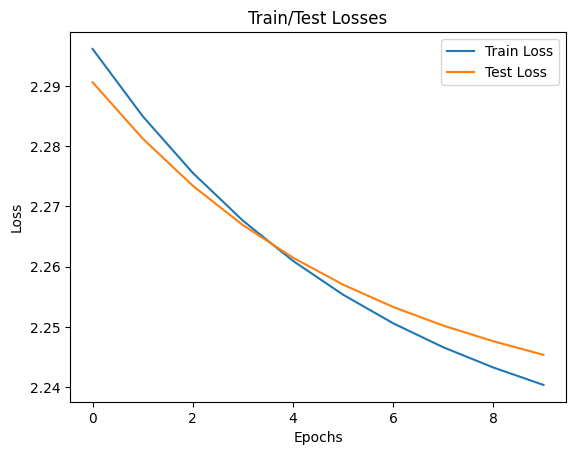

train_losses=[2.296123273955451, 2.2849632284376358, 2.275561983850267, 2.267634379704793, 2.2609635078642105, 2.2553459464179144, 2.250602854145898, 2.2466199311150445, 2.2432628673447503, 2.2403759644296435]
[2.290585699081421, 2.28125412940979, 2.2734250736236574, 2.266896728515625, 2.261490105628967, 2.2570150566101073, 2.2533080348968504, 2.2502166147232057, 2.2476220870018007, 2.245363845348358]
Params: lr=0.0001, w=0.001, opt=<class 'torch.optim.sgd.SGD'>


100%|██████████| 250/250 [00:00<00:00, 1353.39it/s]


Epoch [1/10], Train Loss: 2.2966, Train Accuracy: 12.76%, Test Loss: 2.2921, Test Accuracy: 13.55%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1368.80it/s]


Epoch [2/10], Train Loss: 2.2859, Train Accuracy: 15.29%, Test Loss: 2.2832, Test Accuracy: 15.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1018.73it/s]


Epoch [3/10], Train Loss: 2.2767, Train Accuracy: 17.94%, Test Loss: 2.2757, Test Accuracy: 18.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1456.14it/s]


Epoch [4/10], Train Loss: 2.2689, Train Accuracy: 19.78%, Test Loss: 2.2692, Test Accuracy: 19.20%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1411.62it/s]


Epoch [5/10], Train Loss: 2.2620, Train Accuracy: 20.46%, Test Loss: 2.2636, Test Accuracy: 20.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1049.12it/s]


Epoch [6/10], Train Loss: 2.2561, Train Accuracy: 20.33%, Test Loss: 2.2588, Test Accuracy: 19.80%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1348.55it/s]


Epoch [7/10], Train Loss: 2.2509, Train Accuracy: 20.13%, Test Loss: 2.2547, Test Accuracy: 19.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1426.78it/s]


Epoch [8/10], Train Loss: 2.2465, Train Accuracy: 20.09%, Test Loss: 2.2511, Test Accuracy: 19.60%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1066.86it/s]


Epoch [9/10], Train Loss: 2.2426, Train Accuracy: 19.92%, Test Loss: 2.2480, Test Accuracy: 19.55%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1436.72it/s]


Epoch [10/10], Train Loss: 2.2392, Train Accuracy: 19.81%, Test Loss: 2.2453, Test Accuracy: 19.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1577.47it/s]


Test Accuracy with learning rate 0.0001: 19.90%


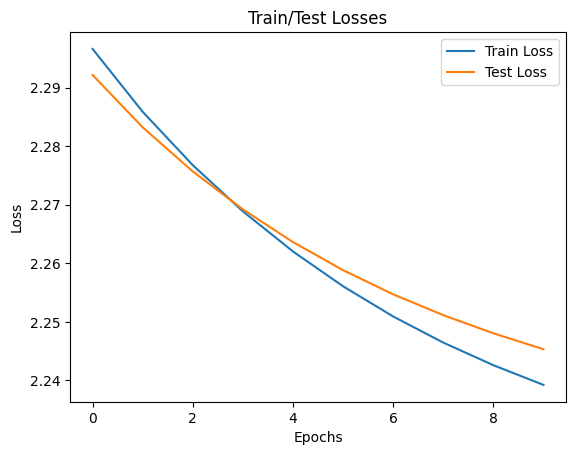

train_losses=[2.296591238975525, 2.2858594205644396, 2.276747793833415, 2.2688621672524345, 2.2620145877202353, 2.2560679652955797, 2.2509122506247627, 2.2464530771043565, 2.242593233267466, 2.239226095729404]
[2.2921495304107666, 2.2832033996582033, 2.275674348831177, 2.269197587013245, 2.2636119832992554, 2.258817693710327, 2.2546928186416624, 2.2511345071792603, 2.2480420684814453, 2.245318007946014]
Params: lr=0.0001, w=0.01, opt=<class 'torch.optim.sgd.SGD'>


100%|██████████| 250/250 [00:00<00:00, 1409.21it/s]


Epoch [1/10], Train Loss: 2.2971, Train Accuracy: 14.38%, Test Loss: 2.2920, Test Accuracy: 17.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 976.24it/s]


Epoch [2/10], Train Loss: 2.2869, Train Accuracy: 18.34%, Test Loss: 2.2834, Test Accuracy: 17.65%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1312.14it/s]


Epoch [3/10], Train Loss: 2.2779, Train Accuracy: 18.78%, Test Loss: 2.2759, Test Accuracy: 18.30%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1392.15it/s]


Epoch [4/10], Train Loss: 2.2701, Train Accuracy: 18.79%, Test Loss: 2.2693, Test Accuracy: 18.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1314.15it/s]


Epoch [5/10], Train Loss: 2.2633, Train Accuracy: 18.82%, Test Loss: 2.2637, Test Accuracy: 18.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1430.22it/s]


Epoch [6/10], Train Loss: 2.2574, Train Accuracy: 18.79%, Test Loss: 2.2590, Test Accuracy: 18.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1390.49it/s]


Epoch [7/10], Train Loss: 2.2524, Train Accuracy: 18.81%, Test Loss: 2.2549, Test Accuracy: 18.35%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1365.90it/s]


Epoch [8/10], Train Loss: 2.2481, Train Accuracy: 18.82%, Test Loss: 2.2515, Test Accuracy: 18.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1303.67it/s]


Epoch [9/10], Train Loss: 2.2444, Train Accuracy: 18.83%, Test Loss: 2.2486, Test Accuracy: 18.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1247.27it/s]


Epoch [10/10], Train Loss: 2.2411, Train Accuracy: 18.83%, Test Loss: 2.2460, Test Accuracy: 18.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1475.83it/s]


Test Accuracy with learning rate 0.0001: 18.70%


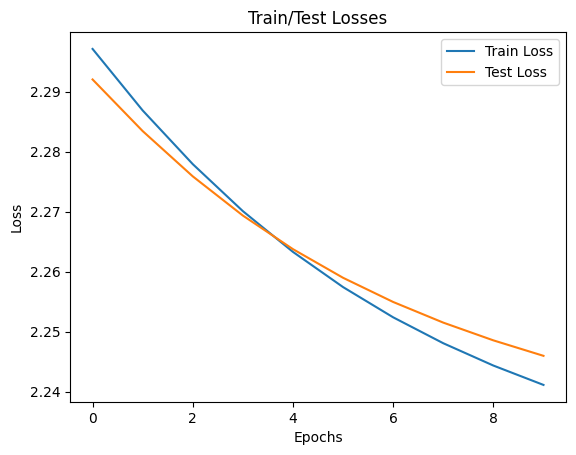

train_losses=[2.2971049824820624, 2.2868534883923, 2.2779087021085953, 2.2700790725284152, 2.263285718070136, 2.2574259583155314, 2.2523891563415526, 2.2480726556248136, 2.2443539236916434, 2.2411280646324157]
[2.29201673412323, 2.283416392326355, 2.2758731002807617, 2.269341727256775, 2.2637448501586914, 2.2589746570587157, 2.254946499824524, 2.251507170677185, 2.2485515689849853, 2.245973667144775]
Params: lr=0.001, w=0.0001, opt=<class 'torch.optim.sgd.SGD'>


100%|██████████| 250/250 [00:00<00:00, 1314.64it/s]


Epoch [1/10], Train Loss: 2.2676, Train Accuracy: 17.58%, Test Loss: 2.2479, Test Accuracy: 19.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1320.21it/s]


Epoch [2/10], Train Loss: 2.2301, Train Accuracy: 19.47%, Test Loss: 2.2255, Test Accuracy: 19.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1352.99it/s]


Epoch [3/10], Train Loss: 2.2065, Train Accuracy: 19.98%, Test Loss: 2.2002, Test Accuracy: 19.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1393.47it/s]


Epoch [4/10], Train Loss: 2.1771, Train Accuracy: 20.64%, Test Loss: 2.1660, Test Accuracy: 20.60%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1407.67it/s]


Epoch [5/10], Train Loss: 2.1400, Train Accuracy: 22.14%, Test Loss: 2.1237, Test Accuracy: 21.65%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1437.30it/s]


Epoch [6/10], Train Loss: 2.0953, Train Accuracy: 23.87%, Test Loss: 2.0744, Test Accuracy: 25.00%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1347.06it/s]


Epoch [7/10], Train Loss: 2.0444, Train Accuracy: 27.49%, Test Loss: 2.0209, Test Accuracy: 28.65%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1355.23it/s]


Epoch [8/10], Train Loss: 1.9885, Train Accuracy: 30.98%, Test Loss: 1.9621, Test Accuracy: 32.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1361.60it/s]


Epoch [9/10], Train Loss: 1.9284, Train Accuracy: 34.78%, Test Loss: 1.9014, Test Accuracy: 35.00%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1369.47it/s]


Epoch [10/10], Train Loss: 1.8659, Train Accuracy: 38.32%, Test Loss: 1.8387, Test Accuracy: 38.65%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1505.87it/s]


Test Accuracy with learning rate 0.001: 39.85%


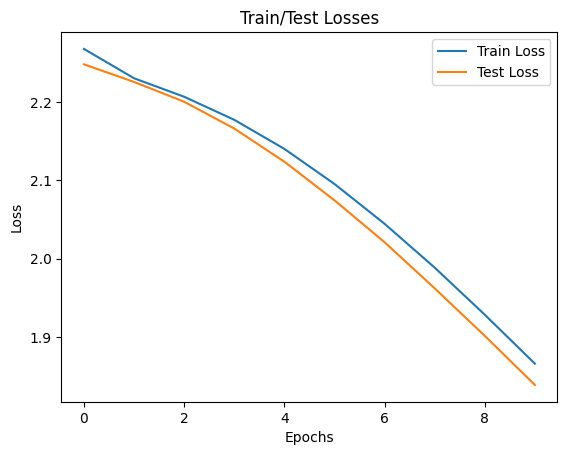

train_losses=[2.26759003633923, 2.2301348464753894, 2.206532452106476, 2.177111739264594, 2.1400142097473145, 2.095255846288469, 2.0444268625047473, 1.9884797836409676, 1.928354990058475, 1.865927336162991]
[2.247915342330933, 2.2254657702445986, 2.200171919822693, 2.1659901156425474, 2.123684913158417, 2.0744163823127746, 2.0209017424583435, 1.9620562071800232, 1.9014127984046936, 1.8387445931434632]
Params: lr=0.001, w=0.001, opt=<class 'torch.optim.sgd.SGD'>


100%|██████████| 250/250 [00:00<00:00, 1401.30it/s]


Epoch [1/10], Train Loss: 2.2655, Train Accuracy: 18.21%, Test Loss: 2.2462, Test Accuracy: 18.80%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1436.18it/s]


Epoch [2/10], Train Loss: 2.2278, Train Accuracy: 19.32%, Test Loss: 2.2249, Test Accuracy: 19.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1416.58it/s]


Epoch [3/10], Train Loss: 2.2034, Train Accuracy: 19.96%, Test Loss: 2.1985, Test Accuracy: 19.95%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1380.43it/s]


Epoch [4/10], Train Loss: 2.1733, Train Accuracy: 21.14%, Test Loss: 2.1625, Test Accuracy: 21.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1374.28it/s]


Epoch [5/10], Train Loss: 2.1354, Train Accuracy: 22.84%, Test Loss: 2.1203, Test Accuracy: 22.00%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1357.95it/s]


Epoch [6/10], Train Loss: 2.0908, Train Accuracy: 24.69%, Test Loss: 2.0722, Test Accuracy: 24.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1275.67it/s]


Epoch [7/10], Train Loss: 2.0400, Train Accuracy: 27.58%, Test Loss: 2.0177, Test Accuracy: 28.75%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1397.38it/s]


Epoch [8/10], Train Loss: 1.9840, Train Accuracy: 31.10%, Test Loss: 1.9591, Test Accuracy: 32.00%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1365.32it/s]


Epoch [9/10], Train Loss: 1.9241, Train Accuracy: 34.58%, Test Loss: 1.8970, Test Accuracy: 34.85%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1384.82it/s]


Epoch [10/10], Train Loss: 1.8622, Train Accuracy: 37.84%, Test Loss: 1.8339, Test Accuracy: 38.75%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1546.98it/s]


Test Accuracy with learning rate 0.001: 39.45%


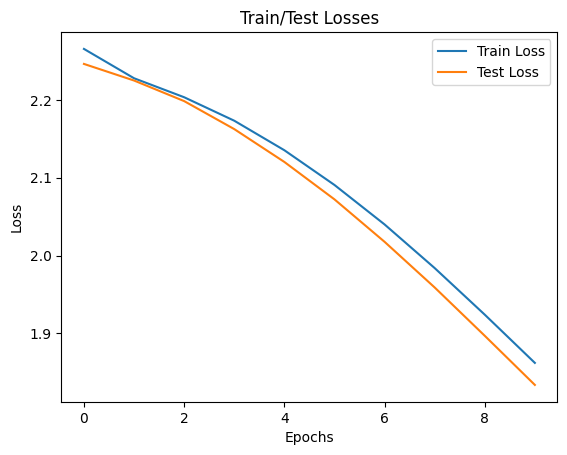

train_losses=[2.265480358335707, 2.2278038879500497, 2.2034133321444194, 2.1732699137793645, 2.1353503183258904, 2.0907527450985377, 2.040041874938541, 1.9839947130415174, 1.9241363842222425, 1.862188567850325]
[2.2462062492370607, 2.2248778457641603, 2.198455189704895, 2.1624933342933654, 2.120304141998291, 2.072242492675781, 2.0177241864204407, 1.959077036380768, 1.8970005116462707, 1.8338865594863891]
Params: lr=0.001, w=0.01, opt=<class 'torch.optim.sgd.SGD'>


100%|██████████| 250/250 [00:00<00:00, 1320.91it/s]


Epoch [1/10], Train Loss: 2.2650, Train Accuracy: 18.12%, Test Loss: 2.2474, Test Accuracy: 18.55%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1396.80it/s]


Epoch [2/10], Train Loss: 2.2318, Train Accuracy: 18.98%, Test Loss: 2.2292, Test Accuracy: 18.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1374.87it/s]


Epoch [3/10], Train Loss: 2.2126, Train Accuracy: 19.30%, Test Loss: 2.2098, Test Accuracy: 19.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1356.04it/s]


Epoch [4/10], Train Loss: 2.1905, Train Accuracy: 19.84%, Test Loss: 2.1850, Test Accuracy: 19.75%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1384.12it/s]


Epoch [5/10], Train Loss: 2.1629, Train Accuracy: 20.70%, Test Loss: 2.1537, Test Accuracy: 20.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1380.56it/s]


Epoch [6/10], Train Loss: 2.1295, Train Accuracy: 22.05%, Test Loss: 2.1178, Test Accuracy: 21.90%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1398.60it/s]


Epoch [7/10], Train Loss: 2.0918, Train Accuracy: 24.03%, Test Loss: 2.0773, Test Accuracy: 24.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1353.68it/s]


Epoch [8/10], Train Loss: 2.0509, Train Accuracy: 26.58%, Test Loss: 2.0341, Test Accuracy: 26.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1389.56it/s]


Epoch [9/10], Train Loss: 2.0067, Train Accuracy: 28.92%, Test Loss: 1.9880, Test Accuracy: 29.20%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1389.41it/s]


Epoch [10/10], Train Loss: 1.9595, Train Accuracy: 32.39%, Test Loss: 1.9398, Test Accuracy: 31.55%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1537.40it/s]


Test Accuracy with learning rate 0.001: 35.00%


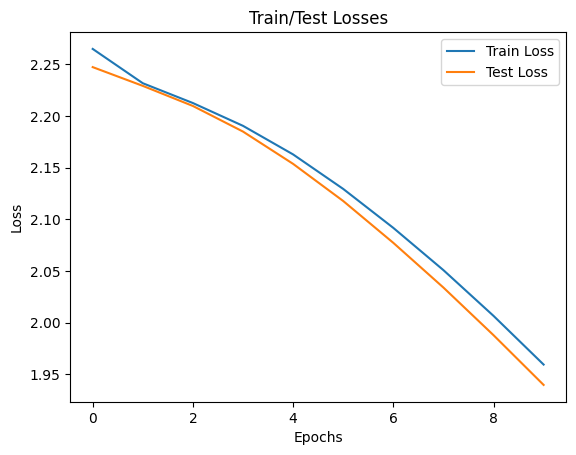

train_losses=[2.2649567954275343, 2.231754589398702, 2.2125840809080337, 2.1905303139686585, 2.1628634607526993, 2.129487965689765, 2.0917972458733454, 2.050914891825782, 2.006665019353231, 1.9595282413164774]
[2.2473510494232176, 2.229211483001709, 2.2097582912445066, 2.184971776485443, 2.1537313590049743, 2.1178014750480654, 2.077321918010712, 2.034062833786011, 1.9879825868606567, 1.939833411693573]
Params: lr=0.01, w=0.0001, opt=<class 'torch.optim.sgd.SGD'>


100%|██████████| 250/250 [00:00<00:00, 1404.27it/s]


Epoch [1/10], Train Loss: 2.1231, Train Accuracy: 24.29%, Test Loss: 1.8770, Test Accuracy: 36.25%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1373.06it/s]


Epoch [2/10], Train Loss: 1.6279, Train Accuracy: 48.71%, Test Loss: 1.4158, Test Accuracy: 56.30%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1257.08it/s]


Epoch [3/10], Train Loss: 1.2982, Train Accuracy: 61.28%, Test Loss: 1.1983, Test Accuracy: 64.30%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1385.53it/s]


Epoch [4/10], Train Loss: 1.1272, Train Accuracy: 66.86%, Test Loss: 1.1124, Test Accuracy: 66.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1336.83it/s]


Epoch [5/10], Train Loss: 1.0211, Train Accuracy: 69.93%, Test Loss: 1.0616, Test Accuracy: 66.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1002.18it/s]


Epoch [6/10], Train Loss: 0.9479, Train Accuracy: 71.51%, Test Loss: 0.9726, Test Accuracy: 70.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1366.01it/s]


Epoch [7/10], Train Loss: 0.8912, Train Accuracy: 73.26%, Test Loss: 0.9589, Test Accuracy: 70.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1372.62it/s]


Epoch [8/10], Train Loss: 0.8389, Train Accuracy: 74.58%, Test Loss: 0.9119, Test Accuracy: 71.60%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1063.11it/s]


Epoch [9/10], Train Loss: 0.7948, Train Accuracy: 75.87%, Test Loss: 0.8748, Test Accuracy: 73.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1396.99it/s]


Epoch [10/10], Train Loss: 0.7550, Train Accuracy: 77.19%, Test Loss: 0.8579, Test Accuracy: 73.35%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1552.52it/s]


Test Accuracy with learning rate 0.01: 70.40%


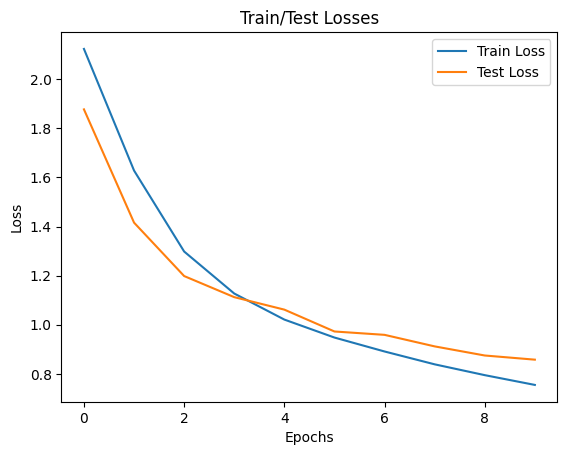

train_losses=[2.1231218608750235, 1.6278810102012422, 1.2981814456383387, 1.1271529357665115, 1.0210956111815241, 0.9479197533130646, 0.8911770156522592, 0.8388876573476527, 0.794839783112208, 0.7550387293861972]
[1.8770095410346985, 1.4157840754985809, 1.1983180470466614, 1.112418524980545, 1.0615985703468322, 0.9726191766262055, 0.9589248804450035, 0.9119393621087074, 0.8748254657387734, 0.8578841168880462]
Params: lr=0.01, w=0.001, opt=<class 'torch.optim.sgd.SGD'>


100%|██████████| 250/250 [00:00<00:00, 1414.96it/s]


Epoch [1/10], Train Loss: 2.1144, Train Accuracy: 24.82%, Test Loss: 1.8797, Test Accuracy: 36.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1019.45it/s]


Epoch [2/10], Train Loss: 1.6316, Train Accuracy: 48.12%, Test Loss: 1.4367, Test Accuracy: 55.55%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1386.21it/s]


Epoch [3/10], Train Loss: 1.3148, Train Accuracy: 61.20%, Test Loss: 1.2263, Test Accuracy: 63.35%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1372.54it/s]


Epoch [4/10], Train Loss: 1.1466, Train Accuracy: 66.45%, Test Loss: 1.1316, Test Accuracy: 65.55%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1130.81it/s]


Epoch [5/10], Train Loss: 1.0421, Train Accuracy: 69.39%, Test Loss: 1.0524, Test Accuracy: 68.25%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1353.00it/s]


Epoch [6/10], Train Loss: 0.9692, Train Accuracy: 71.32%, Test Loss: 1.0011, Test Accuracy: 69.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1288.39it/s]


Epoch [7/10], Train Loss: 0.9124, Train Accuracy: 72.83%, Test Loss: 0.9603, Test Accuracy: 71.55%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1018.11it/s]


Epoch [8/10], Train Loss: 0.8634, Train Accuracy: 74.34%, Test Loss: 0.9197, Test Accuracy: 72.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1343.70it/s]


Epoch [9/10], Train Loss: 0.8228, Train Accuracy: 75.38%, Test Loss: 0.9042, Test Accuracy: 71.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1378.21it/s]


Epoch [10/10], Train Loss: 0.7843, Train Accuracy: 76.66%, Test Loss: 0.8736, Test Accuracy: 73.65%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1457.68it/s]


Test Accuracy with learning rate 0.01: 69.95%


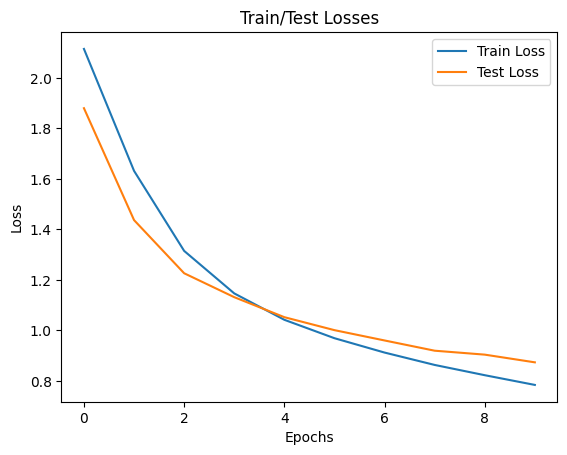

train_losses=[2.1143685699568855, 1.6316152502960628, 1.3148038265837563, 1.1465772222479185, 1.0420878809491794, 0.9692120824456215, 0.9123752038313283, 0.8633870513670975, 0.8227557929837042, 0.7842721895873547]
[1.8796855845451355, 1.436725857615471, 1.226324437379837, 1.1316266454458237, 1.0524458114504813, 1.0010978155732155, 0.9602678548693657, 0.9197354184389115, 0.9041648769378662, 0.8736489814519882]
Params: lr=0.01, w=0.01, opt=<class 'torch.optim.sgd.SGD'>


100%|██████████| 250/250 [00:00<00:00, 1005.35it/s]


Epoch [1/10], Train Loss: 2.1335, Train Accuracy: 23.16%, Test Loss: 1.9419, Test Accuracy: 32.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1404.34it/s]


Epoch [2/10], Train Loss: 1.7334, Train Accuracy: 43.04%, Test Loss: 1.5574, Test Accuracy: 50.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1263.08it/s]


Epoch [3/10], Train Loss: 1.4619, Train Accuracy: 55.83%, Test Loss: 1.3835, Test Accuracy: 57.90%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 923.84it/s]


Epoch [4/10], Train Loss: 1.3226, Train Accuracy: 61.23%, Test Loss: 1.2893, Test Accuracy: 62.60%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1416.79it/s]


Epoch [5/10], Train Loss: 1.2408, Train Accuracy: 64.58%, Test Loss: 1.2560, Test Accuracy: 61.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1359.99it/s]


Epoch [6/10], Train Loss: 1.1868, Train Accuracy: 66.61%, Test Loss: 1.1946, Test Accuracy: 64.55%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1006.27it/s]


Epoch [7/10], Train Loss: 1.1507, Train Accuracy: 67.67%, Test Loss: 1.1684, Test Accuracy: 65.75%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1334.01it/s]


Epoch [8/10], Train Loss: 1.1243, Train Accuracy: 68.63%, Test Loss: 1.1294, Test Accuracy: 67.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1315.82it/s]


Epoch [9/10], Train Loss: 1.1037, Train Accuracy: 69.37%, Test Loss: 1.1247, Test Accuracy: 67.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 982.69it/s] 


Epoch [10/10], Train Loss: 1.0900, Train Accuracy: 69.85%, Test Loss: 1.1082, Test Accuracy: 68.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1136.13it/s]


Test Accuracy with learning rate 0.01: 66.85%


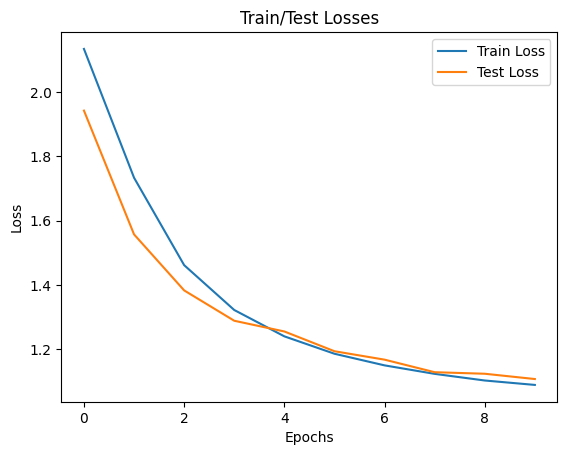

train_losses=[2.1334556937217712, 1.7333931125799815, 1.4619470029936896, 1.3226200575828553, 1.2408171305126614, 1.1867903823720085, 1.1506763279040655, 1.1242916487720278, 1.1036939020819134, 1.0899576463169522]
[1.9418676290512085, 1.5574418165683745, 1.3835184009075165, 1.289259787082672, 1.2559580632448197, 1.1945859216451644, 1.1684402296543122, 1.1294390604496003, 1.1246701109409332, 1.108237947821617]
Params: lr=0.0001, w=0.0001, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 250/250 [00:00<00:00, 1409.75it/s]


Epoch [1/10], Train Loss: 1.8458, Train Accuracy: 40.48%, Test Loss: 1.4743, Test Accuracy: 56.20%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1324.16it/s]


Epoch [2/10], Train Loss: 1.3182, Train Accuracy: 61.46%, Test Loss: 1.2060, Test Accuracy: 64.65%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1301.28it/s]


Epoch [3/10], Train Loss: 1.1209, Train Accuracy: 67.52%, Test Loss: 1.0847, Test Accuracy: 67.60%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1397.61it/s]


Epoch [4/10], Train Loss: 1.0103, Train Accuracy: 70.33%, Test Loss: 1.0199, Test Accuracy: 69.90%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1019.11it/s]


Epoch [5/10], Train Loss: 0.9319, Train Accuracy: 72.32%, Test Loss: 0.9637, Test Accuracy: 70.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1328.90it/s]


Epoch [6/10], Train Loss: 0.8693, Train Accuracy: 74.14%, Test Loss: 0.9196, Test Accuracy: 72.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1375.59it/s]


Epoch [7/10], Train Loss: 0.8194, Train Accuracy: 75.43%, Test Loss: 0.8812, Test Accuracy: 72.25%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 952.51it/s]


Epoch [8/10], Train Loss: 0.7752, Train Accuracy: 76.83%, Test Loss: 0.8451, Test Accuracy: 74.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1316.04it/s]


Epoch [9/10], Train Loss: 0.7356, Train Accuracy: 78.25%, Test Loss: 0.8217, Test Accuracy: 75.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1317.03it/s]


Epoch [10/10], Train Loss: 0.7002, Train Accuracy: 79.24%, Test Loss: 0.8136, Test Accuracy: 74.95%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1511.13it/s]


Test Accuracy with learning rate 0.0001: 72.25%


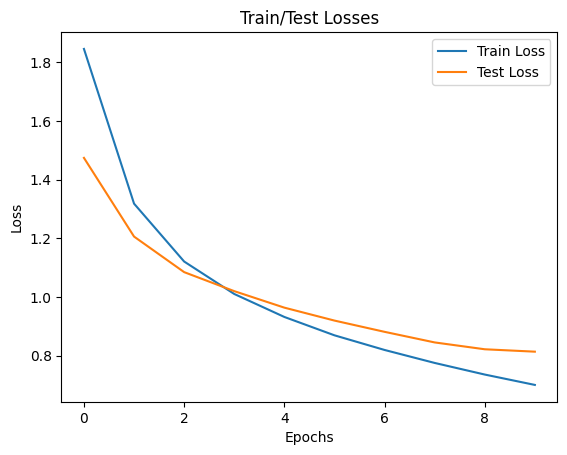

train_losses=[1.8457659453550974, 1.3182419066561593, 1.1208934796187613, 1.010269677804576, 0.931915538960033, 0.8693265095584922, 0.8193931609342495, 0.775154400749339, 0.7355519651282165, 0.7001858344359531]
[1.474302853822708, 1.205972912311554, 1.0847411189079286, 1.0199299325942994, 0.963661729156971, 0.9195628730654717, 0.8811976639330387, 0.845076882392168, 0.8217457566559315, 0.8135545055866241]
Params: lr=0.0001, w=0.001, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 250/250 [00:00<00:00, 1350.38it/s]


Epoch [1/10], Train Loss: 1.8508, Train Accuracy: 39.76%, Test Loss: 1.4880, Test Accuracy: 55.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1341.84it/s]


Epoch [2/10], Train Loss: 1.3416, Train Accuracy: 61.44%, Test Loss: 1.2396, Test Accuracy: 63.55%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1332.82it/s]


Epoch [3/10], Train Loss: 1.1523, Train Accuracy: 66.98%, Test Loss: 1.1022, Test Accuracy: 66.85%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1323.87it/s]


Epoch [4/10], Train Loss: 1.0479, Train Accuracy: 69.65%, Test Loss: 1.0580, Test Accuracy: 68.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1393.13it/s]


Epoch [5/10], Train Loss: 0.9763, Train Accuracy: 71.34%, Test Loss: 1.0067, Test Accuracy: 69.60%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1145.24it/s]


Epoch [6/10], Train Loss: 0.9198, Train Accuracy: 73.29%, Test Loss: 0.9725, Test Accuracy: 70.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1361.68it/s]


Epoch [7/10], Train Loss: 0.8762, Train Accuracy: 74.57%, Test Loss: 0.9135, Test Accuracy: 71.95%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1368.31it/s]


Epoch [8/10], Train Loss: 0.8375, Train Accuracy: 75.68%, Test Loss: 0.9267, Test Accuracy: 71.55%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 995.64it/s] 


Epoch [9/10], Train Loss: 0.8024, Train Accuracy: 76.43%, Test Loss: 0.8723, Test Accuracy: 73.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1398.27it/s]


Epoch [10/10], Train Loss: 0.7687, Train Accuracy: 77.52%, Test Loss: 0.8502, Test Accuracy: 74.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1563.93it/s]


Test Accuracy with learning rate 0.0001: 72.50%


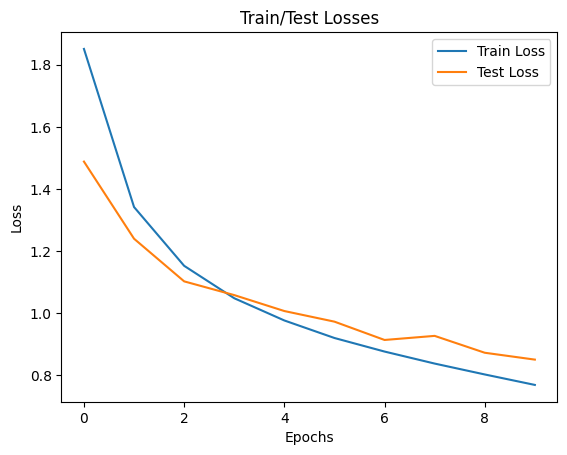

train_losses=[1.8508215953509013, 1.3415635584460364, 1.1523163317309486, 1.0479018426073923, 0.9762959625323614, 0.919845581445429, 0.8761771862076388, 0.8374997432331244, 0.8024339871042304, 0.7687318374315898]
[1.4879790024757384, 1.2395736845731735, 1.1022392506599425, 1.0580209106206895, 1.0066625773906708, 0.9725049048066139, 0.9135066262930631, 0.9266819121837616, 0.8723465262651443, 0.8502363029122353]
Params: lr=0.0001, w=0.01, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 250/250 [00:00<00:00, 1394.01it/s]


Epoch [1/10], Train Loss: 1.9307, Train Accuracy: 35.83%, Test Loss: 1.6540, Test Accuracy: 47.60%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1394.00it/s]


Epoch [2/10], Train Loss: 1.5516, Train Accuracy: 53.77%, Test Loss: 1.4638, Test Accuracy: 55.90%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1281.72it/s]


Epoch [3/10], Train Loss: 1.4099, Train Accuracy: 59.92%, Test Loss: 1.3632, Test Accuracy: 61.30%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1037.63it/s]


Epoch [4/10], Train Loss: 1.3299, Train Accuracy: 62.55%, Test Loss: 1.3184, Test Accuracy: 61.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1340.37it/s]


Epoch [5/10], Train Loss: 1.2774, Train Accuracy: 63.83%, Test Loss: 1.2669, Test Accuracy: 63.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1297.30it/s]


Epoch [6/10], Train Loss: 1.2393, Train Accuracy: 65.07%, Test Loss: 1.2375, Test Accuracy: 62.60%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1043.77it/s]


Epoch [7/10], Train Loss: 1.2114, Train Accuracy: 65.90%, Test Loss: 1.2320, Test Accuracy: 63.20%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1311.94it/s]


Epoch [8/10], Train Loss: 1.1872, Train Accuracy: 66.23%, Test Loss: 1.1768, Test Accuracy: 66.85%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1367.06it/s]


Epoch [9/10], Train Loss: 1.1694, Train Accuracy: 66.84%, Test Loss: 1.1743, Test Accuracy: 65.20%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1399.61it/s]


Epoch [10/10], Train Loss: 1.1553, Train Accuracy: 67.11%, Test Loss: 1.2150, Test Accuracy: 62.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1475.13it/s]


Test Accuracy with learning rate 0.0001: 60.70%


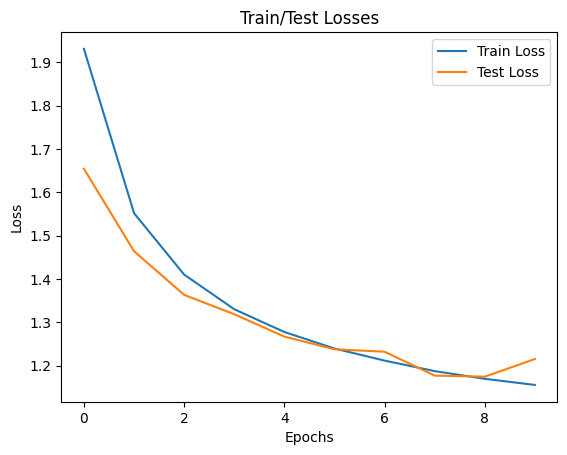

train_losses=[1.9306848529179892, 1.5516124413808188, 1.4099034877353245, 1.329949860519833, 1.2774121625820796, 1.2393258976803885, 1.2114243896272447, 1.1871580245494842, 1.169384323835373, 1.1552924062543446]
[1.6539711146354674, 1.4637700333595276, 1.3631557269096375, 1.318440738916397, 1.2668506430387496, 1.2374778035879135, 1.231954360485077, 1.1767856069803238, 1.1742682169675827, 1.2150220992565155]
Params: lr=0.001, w=0.0001, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 250/250 [00:00<00:00, 1317.99it/s]


Epoch [1/10], Train Loss: 1.5567, Train Accuracy: 49.67%, Test Loss: 1.3003, Test Accuracy: 58.95%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1001.41it/s]


Epoch [2/10], Train Loss: 1.1278, Train Accuracy: 64.87%, Test Loss: 1.1047, Test Accuracy: 65.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1397.73it/s]


Epoch [3/10], Train Loss: 0.9953, Train Accuracy: 69.14%, Test Loss: 1.0933, Test Accuracy: 66.90%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1357.31it/s]


Epoch [4/10], Train Loss: 0.9102, Train Accuracy: 72.04%, Test Loss: 0.9253, Test Accuracy: 71.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 980.08it/s] 


Epoch [5/10], Train Loss: 0.8521, Train Accuracy: 74.12%, Test Loss: 0.9567, Test Accuracy: 72.35%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1359.78it/s]


Epoch [6/10], Train Loss: 0.8111, Train Accuracy: 75.39%, Test Loss: 0.9001, Test Accuracy: 73.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1356.00it/s]


Epoch [7/10], Train Loss: 0.7747, Train Accuracy: 76.53%, Test Loss: 0.8711, Test Accuracy: 73.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1363.65it/s]


Epoch [8/10], Train Loss: 0.7463, Train Accuracy: 77.58%, Test Loss: 1.0487, Test Accuracy: 71.30%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1368.87it/s]


Epoch [9/10], Train Loss: 0.7236, Train Accuracy: 78.51%, Test Loss: 0.9350, Test Accuracy: 73.30%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 971.93it/s]


Epoch [10/10], Train Loss: 0.7011, Train Accuracy: 78.77%, Test Loss: 0.9941, Test Accuracy: 72.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1230.41it/s]


Test Accuracy with learning rate 0.001: 68.20%


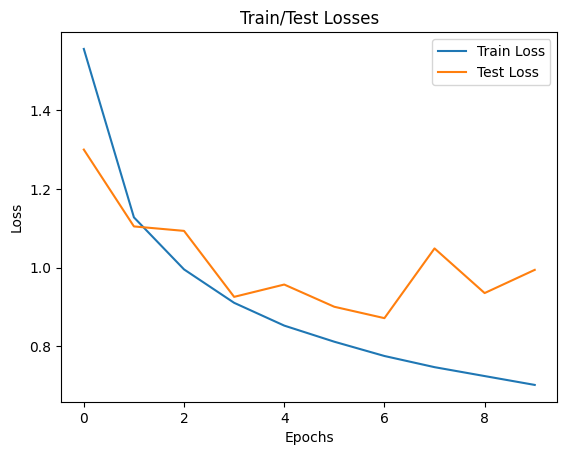

train_losses=[1.5566870279709497, 1.1277528747419516, 0.9952637887729539, 0.9101636627482044, 0.8521435253197948, 0.8110859804087215, 0.7747378396681613, 0.7463063611909747, 0.7236410727571282, 0.7010758620032834]
[1.3003313896656037, 1.1046744843125342, 1.0933358284831047, 0.9253120893836021, 0.9566878806650638, 0.9000812245607376, 0.8711074067354202, 1.0486604263857007, 0.9349795264005661, 0.9940712488293648]
Params: lr=0.001, w=0.001, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 250/250 [00:00<00:00, 1358.70it/s]


Epoch [1/10], Train Loss: 1.6230, Train Accuracy: 47.55%, Test Loss: 1.3033, Test Accuracy: 58.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1365.28it/s]


Epoch [2/10], Train Loss: 1.2584, Train Accuracy: 60.43%, Test Loss: 1.1851, Test Accuracy: 61.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 915.24it/s]


Epoch [3/10], Train Loss: 1.1591, Train Accuracy: 63.67%, Test Loss: 1.2438, Test Accuracy: 61.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1344.64it/s]


Epoch [4/10], Train Loss: 1.0981, Train Accuracy: 65.43%, Test Loss: 1.1023, Test Accuracy: 66.30%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1322.83it/s]


Epoch [5/10], Train Loss: 1.0523, Train Accuracy: 67.54%, Test Loss: 1.0994, Test Accuracy: 66.00%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1271.75it/s]


Epoch [6/10], Train Loss: 1.0152, Train Accuracy: 68.73%, Test Loss: 1.3311, Test Accuracy: 63.75%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1350.49it/s]


Epoch [7/10], Train Loss: 0.9897, Train Accuracy: 69.76%, Test Loss: 0.9796, Test Accuracy: 69.30%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1064.60it/s]


Epoch [8/10], Train Loss: 0.9750, Train Accuracy: 70.01%, Test Loss: 0.9834, Test Accuracy: 69.35%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1320.00it/s]


Epoch [9/10], Train Loss: 0.9566, Train Accuracy: 70.71%, Test Loss: 1.1578, Test Accuracy: 67.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1351.97it/s]


Epoch [10/10], Train Loss: 0.9472, Train Accuracy: 70.94%, Test Loss: 0.9289, Test Accuracy: 71.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1514.02it/s]


Test Accuracy with learning rate 0.001: 69.70%


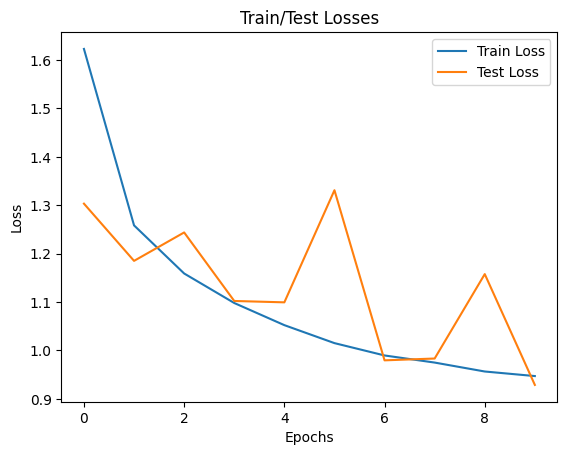

train_losses=[1.6229825104872386, 1.2584307245545918, 1.159066367248694, 1.0980730915996764, 1.052347961773475, 1.015213874893056, 0.989721551126904, 0.9750273129940032, 0.9565758033560382, 0.9471534032523632]
[1.303333411693573, 1.18512275660038, 1.2438376699686051, 1.102282319366932, 1.0994435532838107, 1.3310685321092606, 0.9796345175802708, 0.9833957546055317, 1.1577859731912612, 0.9288547729849815]
Params: lr=0.001, w=0.01, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 250/250 [00:00<00:00, 1261.96it/s]


Epoch [1/10], Train Loss: 1.9403, Train Accuracy: 33.98%, Test Loss: 1.6202, Test Accuracy: 48.85%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1331.99it/s]


Epoch [2/10], Train Loss: 1.6361, Train Accuracy: 45.76%, Test Loss: 1.5957, Test Accuracy: 48.30%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1308.62it/s]


Epoch [3/10], Train Loss: 1.5452, Train Accuracy: 49.23%, Test Loss: 1.5660, Test Accuracy: 48.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1268.77it/s]


Epoch [4/10], Train Loss: 1.5005, Train Accuracy: 51.92%, Test Loss: 1.4437, Test Accuracy: 53.95%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1363.98it/s]


Epoch [5/10], Train Loss: 1.4656, Train Accuracy: 53.43%, Test Loss: 1.4443, Test Accuracy: 53.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1154.78it/s]


Epoch [6/10], Train Loss: 1.4482, Train Accuracy: 53.80%, Test Loss: 1.4281, Test Accuracy: 53.00%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1316.49it/s]


Epoch [7/10], Train Loss: 1.4365, Train Accuracy: 54.14%, Test Loss: 1.4318, Test Accuracy: 54.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1317.64it/s]


Epoch [8/10], Train Loss: 1.4314, Train Accuracy: 54.43%, Test Loss: 1.5385, Test Accuracy: 49.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1060.82it/s]


Epoch [9/10], Train Loss: 1.4187, Train Accuracy: 54.69%, Test Loss: 1.4515, Test Accuracy: 53.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1341.21it/s]


Epoch [10/10], Train Loss: 1.4118, Train Accuracy: 55.84%, Test Loss: 1.6476, Test Accuracy: 48.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1453.68it/s]


Test Accuracy with learning rate 0.001: 45.00%


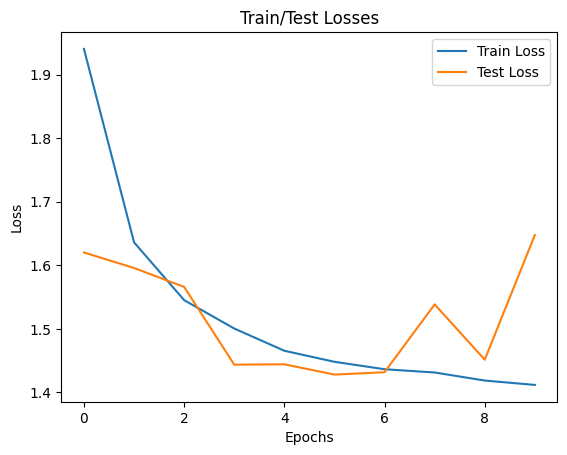

train_losses=[1.940347053050995, 1.6361104134188758, 1.5451716238392723, 1.5005309100813335, 1.465560458050834, 1.4481757682561875, 1.4364794219070012, 1.4313772814936108, 1.4186944297154744, 1.4118194540076785]
[1.6201738114356994, 1.5957351069450378, 1.565977857351303, 1.4436840345859527, 1.4442762389183044, 1.428088873386383, 1.4318100280761719, 1.5384720377922059, 1.451474955558777, 1.6476486043930054]
Params: lr=0.01, w=0.0001, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 250/250 [00:00<00:00, 1383.23it/s]


Epoch [1/10], Train Loss: 7.9144, Train Accuracy: 30.94%, Test Loss: 6.3642, Test Accuracy: 36.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1373.43it/s]


Epoch [2/10], Train Loss: 5.0035, Train Accuracy: 42.87%, Test Loss: 5.2471, Test Accuracy: 42.20%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1320.89it/s]


Epoch [3/10], Train Loss: 4.2863, Train Accuracy: 45.94%, Test Loss: 2.7690, Test Accuracy: 52.80%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1049.26it/s]


Epoch [4/10], Train Loss: 4.5440, Train Accuracy: 46.32%, Test Loss: 3.5514, Test Accuracy: 47.85%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1263.18it/s]


Epoch [5/10], Train Loss: 4.5864, Train Accuracy: 48.09%, Test Loss: 3.8924, Test Accuracy: 47.60%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1305.46it/s]


Epoch [6/10], Train Loss: 4.5781, Train Accuracy: 48.10%, Test Loss: 4.2868, Test Accuracy: 49.20%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 955.10it/s] 


Epoch [7/10], Train Loss: 4.5977, Train Accuracy: 48.64%, Test Loss: 3.5742, Test Accuracy: 49.65%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1325.67it/s]


Epoch [8/10], Train Loss: 4.5690, Train Accuracy: 49.10%, Test Loss: 8.1146, Test Accuracy: 38.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1362.58it/s]


Epoch [9/10], Train Loss: 4.5777, Train Accuracy: 48.15%, Test Loss: 2.9390, Test Accuracy: 51.80%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1327.80it/s]


Epoch [10/10], Train Loss: 4.5224, Train Accuracy: 48.67%, Test Loss: 2.6833, Test Accuracy: 54.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1525.75it/s]


Test Accuracy with learning rate 0.01: 49.85%


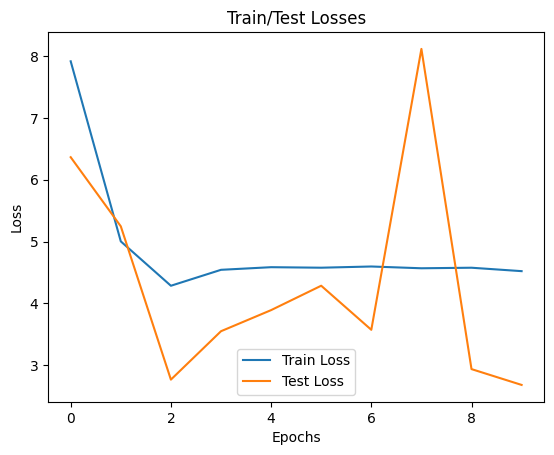

train_losses=[7.914357846948835, 5.0035027372969525, 4.286298616339763, 4.544014049460491, 4.586402240362743, 4.5780998489873275, 4.597668500445783, 4.568966972601083, 4.577740809927384, 4.522429378300905]
[6.364241751909256, 5.247085355520248, 2.7689883684311063, 3.5514232308268547, 3.892438958287239, 4.286794119000435, 3.5742400746792553, 8.114632921218872, 2.93904449057579, 2.6833320049345493]
Params: lr=0.01, w=0.001, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 250/250 [00:00<00:00, 1363.33it/s]


Epoch [1/10], Train Loss: 6.9815, Train Accuracy: 23.01%, Test Loss: 3.3535, Test Accuracy: 28.85%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1085.21it/s]


Epoch [2/10], Train Loss: 5.1035, Train Accuracy: 28.22%, Test Loss: 3.6071, Test Accuracy: 32.95%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1326.47it/s]


Epoch [3/10], Train Loss: 5.1130, Train Accuracy: 29.43%, Test Loss: 3.4219, Test Accuracy: 35.35%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1337.52it/s]


Epoch [4/10], Train Loss: 5.1592, Train Accuracy: 30.42%, Test Loss: 6.1711, Test Accuracy: 26.65%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1058.57it/s]


Epoch [5/10], Train Loss: 4.9279, Train Accuracy: 30.12%, Test Loss: 11.6194, Test Accuracy: 24.30%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1300.02it/s]


Epoch [6/10], Train Loss: 5.1543, Train Accuracy: 30.07%, Test Loss: 4.8885, Test Accuracy: 35.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1358.71it/s]


Epoch [7/10], Train Loss: 5.1328, Train Accuracy: 29.37%, Test Loss: 7.0055, Test Accuracy: 24.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1320.90it/s]


Epoch [8/10], Train Loss: 5.0634, Train Accuracy: 29.85%, Test Loss: 4.0531, Test Accuracy: 35.00%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1364.17it/s]


Epoch [9/10], Train Loss: 4.9492, Train Accuracy: 30.34%, Test Loss: 6.8369, Test Accuracy: 24.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1262.85it/s]


Epoch [10/10], Train Loss: 5.0415, Train Accuracy: 29.93%, Test Loss: 3.2221, Test Accuracy: 32.30%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1032.37it/s]


Test Accuracy with learning rate 0.01: 30.75%


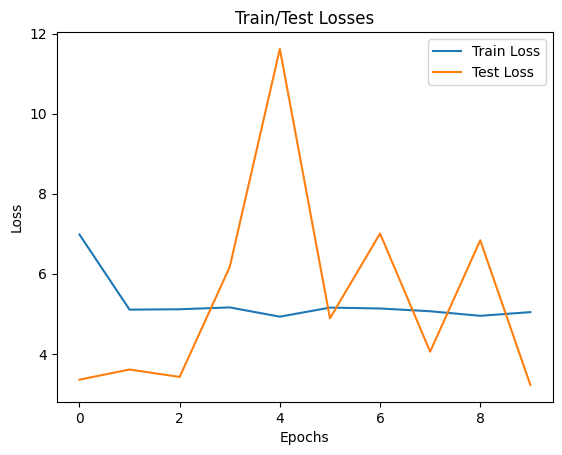

train_losses=[6.981544726663166, 5.103453096853362, 5.113000453657574, 5.159244733717706, 4.927905087285572, 5.154348634931776, 5.132808566424582, 5.063365297820833, 4.949195765200589, 5.041459662357966]
[3.3535315651893614, 3.6070560863018035, 3.4218554912805557, 6.171094166755676, 11.619448657989501, 4.888542376041412, 7.005467777252197, 4.053089738607406, 6.836933737754822, 3.2221351363658903]
Params: lr=0.01, w=0.01, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 250/250 [00:00<00:00, 1353.93it/s]


Epoch [1/10], Train Loss: 7.1182, Train Accuracy: 12.73%, Test Loss: 11.4721, Test Accuracy: 12.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1336.59it/s]


Epoch [2/10], Train Loss: 6.2403, Train Accuracy: 12.81%, Test Loss: 4.6550, Test Accuracy: 14.30%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 903.08it/s]


Epoch [3/10], Train Loss: 6.2399, Train Accuracy: 12.43%, Test Loss: 6.9455, Test Accuracy: 16.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1355.82it/s]


Epoch [4/10], Train Loss: 6.3543, Train Accuracy: 12.69%, Test Loss: 7.7229, Test Accuracy: 9.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1310.80it/s]


Epoch [5/10], Train Loss: 6.2286, Train Accuracy: 12.18%, Test Loss: 3.4506, Test Accuracy: 12.60%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1341.57it/s]


Epoch [6/10], Train Loss: 6.3371, Train Accuracy: 12.63%, Test Loss: 8.0142, Test Accuracy: 13.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1316.67it/s]


Epoch [7/10], Train Loss: 6.3127, Train Accuracy: 12.47%, Test Loss: 6.5582, Test Accuracy: 10.95%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1271.34it/s]


Epoch [8/10], Train Loss: 6.2444, Train Accuracy: 12.46%, Test Loss: 12.0283, Test Accuracy: 10.25%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1327.54it/s]


Epoch [9/10], Train Loss: 6.2025, Train Accuracy: 12.19%, Test Loss: 3.6220, Test Accuracy: 14.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1326.81it/s]


Epoch [10/10], Train Loss: 6.2451, Train Accuracy: 13.02%, Test Loss: 5.8630, Test Accuracy: 13.20%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1401.09it/s]


Test Accuracy with learning rate 0.01: 12.80%


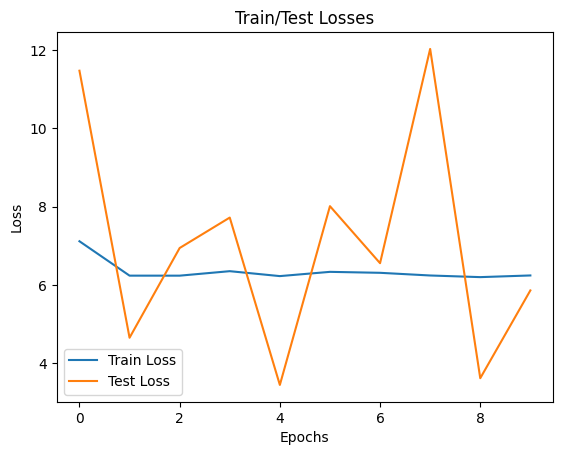

train_losses=[7.118187842316098, 6.240323010656569, 6.239878931840261, 6.354314905219608, 6.228590037504832, 6.337117732895745, 6.312660304440392, 6.244393338309394, 6.202453211466471, 6.24514955133862]
[11.472107424736024, 4.655041036605835, 6.94552349948883, 7.722869358062744, 3.450582287788391, 8.014151340484618, 6.558169532775879, 12.028267149925233, 3.6219773335456846, 5.862996539115906]


In [58]:
result = pd.DataFrame(columns=['optimizer', 'learning_rate', 'weight_decay', 'test_accuracy'])
num_epochs = 10
weight_decay_list = [0.0001, 0.001, 0.01]
learning_rates = [0.0001, 0.001, 0.01]
optimizers = [optim.SGD, optim.RMSprop]
params = [(x, y, z) for x in optimizers for y in learning_rates for z in weight_decay_list]

result = run(params, num_epochs, result)

In [59]:
result_sorted = result.sort_values(by=['test_accuracy'], ascending=False)
result_sorted

,optimizer,learning_rate,weight_decay,test_accuracy
0,RMSprop,0.0001,0.0001,0.7545
0,RMSprop,0.0001,0.0010,0.7405
0,RMSprop,0.0010,0.0001,0.7370
0,SGD,0.0100,0.0010,0.7365
0,SGD,0.0100,0.0001,0.7335
0,RMSprop,0.0010,0.0010,0.7140
0,SGD,0.0100,0.0100,0.6805
0,RMSprop,0.0001,0.0100,0.6685
0,RMSprop,0.0010,0.0100,0.5415
0,RMSprop,0.0100,0.0001,0.5415


Лучше всего себя показали модели с RMSprop оптимизатором. Обучим модели с лучшими параметрами на большем количестве эпох для улучшения результатов, а также для разнообразия добавим лучший SGD оптимизатор.

Params: lr=0.01, w=0.001, opt=<class 'torch.optim.sgd.SGD'>


100%|██████████| 250/250 [00:00<00:00, 1021.05it/s]


Epoch [1/50], Train Loss: 2.1134, Train Accuracy: 24.66%, Test Loss: 1.8726, Test Accuracy: 35.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1370.49it/s]


Epoch [2/50], Train Loss: 1.6246, Train Accuracy: 48.55%, Test Loss: 1.4205, Test Accuracy: 56.85%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1399.27it/s]


Epoch [3/50], Train Loss: 1.3137, Train Accuracy: 61.11%, Test Loss: 1.2334, Test Accuracy: 62.90%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1025.30it/s]


Epoch [4/50], Train Loss: 1.1525, Train Accuracy: 66.41%, Test Loss: 1.1339, Test Accuracy: 64.80%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1395.39it/s]


Epoch [5/50], Train Loss: 1.0463, Train Accuracy: 69.33%, Test Loss: 1.0569, Test Accuracy: 67.75%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1428.84it/s]


Epoch [6/50], Train Loss: 0.9762, Train Accuracy: 71.09%, Test Loss: 0.9927, Test Accuracy: 70.35%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1003.91it/s]


Epoch [7/50], Train Loss: 0.9191, Train Accuracy: 72.61%, Test Loss: 0.9619, Test Accuracy: 70.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1442.58it/s]


Epoch [8/50], Train Loss: 0.8714, Train Accuracy: 74.18%, Test Loss: 0.9179, Test Accuracy: 71.90%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1436.31it/s]


Epoch [9/50], Train Loss: 0.8286, Train Accuracy: 75.31%, Test Loss: 0.8845, Test Accuracy: 73.55%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1054.83it/s]


Epoch [10/50], Train Loss: 0.7903, Train Accuracy: 76.53%, Test Loss: 0.8747, Test Accuracy: 72.80%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1414.24it/s]


Epoch [11/50], Train Loss: 0.7556, Train Accuracy: 77.61%, Test Loss: 0.8540, Test Accuracy: 73.75%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1388.85it/s]


Epoch [12/50], Train Loss: 0.7243, Train Accuracy: 78.48%, Test Loss: 0.8089, Test Accuracy: 74.30%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1020.20it/s]


Epoch [13/50], Train Loss: 0.6965, Train Accuracy: 79.57%, Test Loss: 0.8157, Test Accuracy: 74.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1403.57it/s]


Epoch [14/50], Train Loss: 0.6684, Train Accuracy: 80.59%, Test Loss: 0.7835, Test Accuracy: 76.25%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1446.41it/s]


Epoch [15/50], Train Loss: 0.6457, Train Accuracy: 80.89%, Test Loss: 0.7741, Test Accuracy: 75.95%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1014.76it/s]


Epoch [16/50], Train Loss: 0.6232, Train Accuracy: 81.89%, Test Loss: 0.7636, Test Accuracy: 76.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1414.41it/s]


Epoch [17/50], Train Loss: 0.6041, Train Accuracy: 82.53%, Test Loss: 0.7475, Test Accuracy: 77.00%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1443.90it/s]


Epoch [18/50], Train Loss: 0.5869, Train Accuracy: 82.98%, Test Loss: 0.7349, Test Accuracy: 77.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1063.46it/s]


Epoch [19/50], Train Loss: 0.5694, Train Accuracy: 83.66%, Test Loss: 0.7112, Test Accuracy: 79.60%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1446.89it/s]


Epoch [20/50], Train Loss: 0.5518, Train Accuracy: 84.17%, Test Loss: 0.7543, Test Accuracy: 76.85%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1428.56it/s]


Epoch [21/50], Train Loss: 0.5397, Train Accuracy: 84.53%, Test Loss: 0.7331, Test Accuracy: 78.60%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1041.28it/s]


Epoch [22/50], Train Loss: 0.5270, Train Accuracy: 85.14%, Test Loss: 0.7243, Test Accuracy: 78.00%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1417.26it/s]


Epoch [23/50], Train Loss: 0.5135, Train Accuracy: 85.61%, Test Loss: 0.7026, Test Accuracy: 78.90%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1437.15it/s]


Epoch [24/50], Train Loss: 0.5017, Train Accuracy: 86.01%, Test Loss: 0.6966, Test Accuracy: 78.80%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1024.20it/s]


Epoch [25/50], Train Loss: 0.4932, Train Accuracy: 86.20%, Test Loss: 0.7050, Test Accuracy: 78.75%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1438.46it/s]


Epoch [26/50], Train Loss: 0.4828, Train Accuracy: 86.46%, Test Loss: 0.6865, Test Accuracy: 79.00%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1408.19it/s]


Epoch [27/50], Train Loss: 0.4728, Train Accuracy: 86.82%, Test Loss: 0.6912, Test Accuracy: 78.95%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1037.75it/s]


Epoch [28/50], Train Loss: 0.4658, Train Accuracy: 86.98%, Test Loss: 0.6805, Test Accuracy: 79.75%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1435.42it/s]


Epoch [29/50], Train Loss: 0.4574, Train Accuracy: 87.30%, Test Loss: 0.6824, Test Accuracy: 80.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1448.19it/s]


Epoch [30/50], Train Loss: 0.4485, Train Accuracy: 87.50%, Test Loss: 0.6941, Test Accuracy: 79.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1066.54it/s]


Epoch [31/50], Train Loss: 0.4433, Train Accuracy: 87.51%, Test Loss: 0.6932, Test Accuracy: 79.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1351.95it/s]


Epoch [32/50], Train Loss: 0.4347, Train Accuracy: 88.08%, Test Loss: 0.6778, Test Accuracy: 79.95%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1395.47it/s]


Epoch [33/50], Train Loss: 0.4289, Train Accuracy: 88.07%, Test Loss: 0.6720, Test Accuracy: 80.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 637.56it/s]


Epoch [34/50], Train Loss: 0.4229, Train Accuracy: 88.21%, Test Loss: 0.6737, Test Accuracy: 80.35%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1452.04it/s]


Epoch [35/50], Train Loss: 0.4142, Train Accuracy: 88.78%, Test Loss: 0.6870, Test Accuracy: 79.20%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1299.11it/s]


Epoch [36/50], Train Loss: 0.4091, Train Accuracy: 88.92%, Test Loss: 0.6669, Test Accuracy: 80.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1391.88it/s]


Epoch [37/50], Train Loss: 0.4033, Train Accuracy: 89.12%, Test Loss: 0.6622, Test Accuracy: 80.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1397.49it/s]


Epoch [38/50], Train Loss: 0.3993, Train Accuracy: 89.41%, Test Loss: 0.6779, Test Accuracy: 79.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1424.03it/s]


Epoch [39/50], Train Loss: 0.3954, Train Accuracy: 89.09%, Test Loss: 0.6731, Test Accuracy: 80.20%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1390.08it/s]


Epoch [40/50], Train Loss: 0.3916, Train Accuracy: 89.59%, Test Loss: 0.6706, Test Accuracy: 79.75%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1427.00it/s]


Epoch [41/50], Train Loss: 0.3857, Train Accuracy: 89.59%, Test Loss: 0.6934, Test Accuracy: 79.25%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1395.51it/s]


Epoch [42/50], Train Loss: 0.3822, Train Accuracy: 89.73%, Test Loss: 0.6876, Test Accuracy: 79.35%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1367.81it/s]


Epoch [43/50], Train Loss: 0.3784, Train Accuracy: 89.93%, Test Loss: 0.6665, Test Accuracy: 80.80%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1370.86it/s]


Epoch [44/50], Train Loss: 0.3729, Train Accuracy: 90.16%, Test Loss: 0.6574, Test Accuracy: 80.95%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1412.78it/s]


Epoch [45/50], Train Loss: 0.3701, Train Accuracy: 90.14%, Test Loss: 0.6758, Test Accuracy: 79.95%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1384.04it/s]


Epoch [46/50], Train Loss: 0.3679, Train Accuracy: 90.27%, Test Loss: 0.6563, Test Accuracy: 80.60%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1401.09it/s]


Epoch [47/50], Train Loss: 0.3616, Train Accuracy: 90.72%, Test Loss: 0.6778, Test Accuracy: 80.55%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1379.62it/s]


Epoch [48/50], Train Loss: 0.3589, Train Accuracy: 90.72%, Test Loss: 0.6477, Test Accuracy: 81.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1409.72it/s]


Epoch [49/50], Train Loss: 0.3564, Train Accuracy: 90.68%, Test Loss: 0.6745, Test Accuracy: 80.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1445.42it/s]


Epoch [50/50], Train Loss: 0.3528, Train Accuracy: 90.72%, Test Loss: 0.6706, Test Accuracy: 80.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1604.77it/s]


Test Accuracy with learning rate 0.01: 79.15%


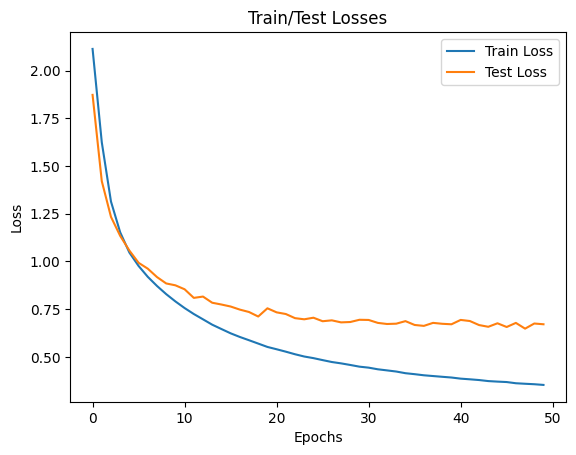

train_losses=[2.1133786053127714, 1.6245552070405749, 1.3137264558871586, 1.1524859278069601, 1.0463354247146182, 0.9761557482745913, 0.9190822066018979, 0.8713612803916136, 0.8285517668525378, 0.7903492160638174, 0.7555634075552226, 0.7243435968028175, 0.6965083355870512, 0.6684277233795988, 0.6456983623736434, 0.6232389842271805, 0.6041341844482554, 0.5869440794115265, 0.569445358377364, 0.55182001434101, 0.5396522089598907, 0.5269873314715094, 0.5135076817928089, 0.501656299131612, 0.4931918954046236, 0.4828137686525782, 0.47282153593086534, 0.46576107663744026, 0.45739316828507515, 0.4484802783942885, 0.44329496516618466, 0.4346941185614301, 0.4289088779890703, 0.42294771752465105, 0.41419024999708765, 0.40910435153999264, 0.40329295734771425, 0.39932260435033173, 0.3953664224487212, 0.3915669191082319, 0.385696235191077, 0.38220997674473456, 0.37838063455455834, 0.3729264579800268, 0.3701455239140325, 0.3678673691468106, 0.36156464455939, 0.35887056393548844, 0.3564409473929554, 0

100%|██████████| 250/250 [00:00<00:00, 1132.84it/s]


Epoch [1/50], Train Loss: 1.8409, Train Accuracy: 40.94%, Test Loss: 1.4679, Test Accuracy: 58.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1341.60it/s]


Epoch [2/50], Train Loss: 1.3085, Train Accuracy: 62.48%, Test Loss: 1.1870, Test Accuracy: 65.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1334.44it/s]


Epoch [3/50], Train Loss: 1.1135, Train Accuracy: 67.72%, Test Loss: 1.0845, Test Accuracy: 66.85%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 964.39it/s] 


Epoch [4/50], Train Loss: 1.0033, Train Accuracy: 70.57%, Test Loss: 1.0023, Test Accuracy: 69.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1380.22it/s]


Epoch [5/50], Train Loss: 0.9294, Train Accuracy: 72.29%, Test Loss: 0.9778, Test Accuracy: 70.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1388.64it/s]


Epoch [6/50], Train Loss: 0.8687, Train Accuracy: 74.19%, Test Loss: 0.9087, Test Accuracy: 71.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1347.17it/s]


Epoch [7/50], Train Loss: 0.8182, Train Accuracy: 75.78%, Test Loss: 0.8769, Test Accuracy: 73.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1413.58it/s]


Epoch [8/50], Train Loss: 0.7725, Train Accuracy: 77.03%, Test Loss: 0.8762, Test Accuracy: 72.95%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1035.84it/s]


Epoch [9/50], Train Loss: 0.7356, Train Accuracy: 78.06%, Test Loss: 0.8399, Test Accuracy: 74.00%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1395.78it/s]


Epoch [10/50], Train Loss: 0.6977, Train Accuracy: 79.56%, Test Loss: 0.8101, Test Accuracy: 75.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1414.64it/s]


Epoch [11/50], Train Loss: 0.6669, Train Accuracy: 80.31%, Test Loss: 0.7848, Test Accuracy: 76.25%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1052.56it/s]


Epoch [12/50], Train Loss: 0.6376, Train Accuracy: 81.19%, Test Loss: 0.7749, Test Accuracy: 75.65%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1371.61it/s]


Epoch [13/50], Train Loss: 0.6102, Train Accuracy: 81.83%, Test Loss: 0.7641, Test Accuracy: 76.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1396.82it/s]


Epoch [14/50], Train Loss: 0.5879, Train Accuracy: 82.72%, Test Loss: 0.7486, Test Accuracy: 76.90%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1408.99it/s]


Epoch [15/50], Train Loss: 0.5627, Train Accuracy: 83.34%, Test Loss: 0.7284, Test Accuracy: 77.80%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1414.64it/s]


Epoch [16/50], Train Loss: 0.5444, Train Accuracy: 84.13%, Test Loss: 0.7419, Test Accuracy: 77.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1405.87it/s]


Epoch [17/50], Train Loss: 0.5230, Train Accuracy: 84.81%, Test Loss: 0.7309, Test Accuracy: 77.85%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1438.67it/s]


Epoch [18/50], Train Loss: 0.5048, Train Accuracy: 85.48%, Test Loss: 0.7366, Test Accuracy: 77.85%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1346.79it/s]


Epoch [19/50], Train Loss: 0.4901, Train Accuracy: 85.65%, Test Loss: 0.7119, Test Accuracy: 78.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1038.88it/s]


Epoch [20/50], Train Loss: 0.4728, Train Accuracy: 86.40%, Test Loss: 0.7060, Test Accuracy: 78.85%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1323.59it/s]


Epoch [21/50], Train Loss: 0.4578, Train Accuracy: 86.92%, Test Loss: 0.6880, Test Accuracy: 78.95%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1423.91it/s]


Epoch [22/50], Train Loss: 0.4434, Train Accuracy: 87.13%, Test Loss: 0.6858, Test Accuracy: 79.60%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1435.09it/s]


Epoch [23/50], Train Loss: 0.4302, Train Accuracy: 87.63%, Test Loss: 0.7184, Test Accuracy: 78.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1434.52it/s]


Epoch [24/50], Train Loss: 0.4185, Train Accuracy: 88.10%, Test Loss: 0.6914, Test Accuracy: 80.90%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1390.03it/s]


Epoch [25/50], Train Loss: 0.4069, Train Accuracy: 88.12%, Test Loss: 0.6931, Test Accuracy: 80.20%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1435.30it/s]


Epoch [26/50], Train Loss: 0.3966, Train Accuracy: 88.68%, Test Loss: 0.7155, Test Accuracy: 79.65%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1423.99it/s]


Epoch [27/50], Train Loss: 0.3854, Train Accuracy: 88.93%, Test Loss: 0.6874, Test Accuracy: 80.85%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1100.04it/s]


Epoch [28/50], Train Loss: 0.3748, Train Accuracy: 89.46%, Test Loss: 0.7067, Test Accuracy: 80.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1332.24it/s]


Epoch [29/50], Train Loss: 0.3650, Train Accuracy: 89.68%, Test Loss: 0.6761, Test Accuracy: 81.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1407.38it/s]


Epoch [30/50], Train Loss: 0.3567, Train Accuracy: 89.90%, Test Loss: 0.7052, Test Accuracy: 80.25%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1402.61it/s]


Epoch [31/50], Train Loss: 0.3471, Train Accuracy: 90.21%, Test Loss: 0.7070, Test Accuracy: 79.80%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1356.08it/s]


Epoch [32/50], Train Loss: 0.3369, Train Accuracy: 90.63%, Test Loss: 0.6972, Test Accuracy: 80.00%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1363.91it/s]


Epoch [33/50], Train Loss: 0.3312, Train Accuracy: 90.77%, Test Loss: 0.6895, Test Accuracy: 80.75%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1346.52it/s]


Epoch [34/50], Train Loss: 0.3239, Train Accuracy: 91.06%, Test Loss: 0.6762, Test Accuracy: 81.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1358.47it/s]


Epoch [35/50], Train Loss: 0.3145, Train Accuracy: 91.42%, Test Loss: 0.7107, Test Accuracy: 80.30%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1125.23it/s]


Epoch [36/50], Train Loss: 0.3088, Train Accuracy: 91.43%, Test Loss: 0.6827, Test Accuracy: 81.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1348.11it/s]


Epoch [37/50], Train Loss: 0.3020, Train Accuracy: 91.59%, Test Loss: 0.7168, Test Accuracy: 79.35%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1350.39it/s]


Epoch [38/50], Train Loss: 0.2968, Train Accuracy: 91.86%, Test Loss: 0.7030, Test Accuracy: 80.90%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 946.17it/s]


Epoch [39/50], Train Loss: 0.2880, Train Accuracy: 92.07%, Test Loss: 0.6888, Test Accuracy: 81.95%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1357.30it/s]


Epoch [40/50], Train Loss: 0.2843, Train Accuracy: 92.20%, Test Loss: 0.6934, Test Accuracy: 81.30%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1372.63it/s]


Epoch [41/50], Train Loss: 0.2760, Train Accuracy: 92.48%, Test Loss: 0.6950, Test Accuracy: 81.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1370.39it/s]


Epoch [42/50], Train Loss: 0.2710, Train Accuracy: 92.52%, Test Loss: 0.7288, Test Accuracy: 80.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1361.97it/s]


Epoch [43/50], Train Loss: 0.2662, Train Accuracy: 92.93%, Test Loss: 0.7036, Test Accuracy: 81.20%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1046.35it/s]


Epoch [44/50], Train Loss: 0.2578, Train Accuracy: 93.03%, Test Loss: 0.7011, Test Accuracy: 82.30%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1447.49it/s]


Epoch [45/50], Train Loss: 0.2527, Train Accuracy: 93.37%, Test Loss: 0.7267, Test Accuracy: 80.35%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1301.20it/s]


Epoch [46/50], Train Loss: 0.2483, Train Accuracy: 93.33%, Test Loss: 0.7109, Test Accuracy: 81.20%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1024.20it/s]


Epoch [47/50], Train Loss: 0.2448, Train Accuracy: 93.34%, Test Loss: 0.7056, Test Accuracy: 81.30%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1422.13it/s]


Epoch [48/50], Train Loss: 0.2401, Train Accuracy: 93.48%, Test Loss: 0.7158, Test Accuracy: 81.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1383.00it/s]


Epoch [49/50], Train Loss: 0.2335, Train Accuracy: 93.64%, Test Loss: 0.7261, Test Accuracy: 80.90%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1439.05it/s]


Epoch [50/50], Train Loss: 0.2309, Train Accuracy: 93.88%, Test Loss: 0.7169, Test Accuracy: 81.75%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1473.71it/s]


Test Accuracy with learning rate 0.0001: 80.30%


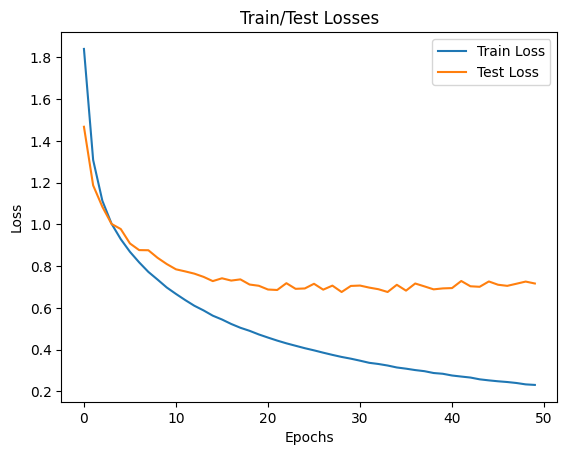

train_losses=[1.8408616341220008, 1.308513478755951, 1.1134513822396597, 1.0032521975040436, 0.9294128374258677, 0.8686604056027201, 0.8181503431830142, 0.7724576090044446, 0.7355990438510974, 0.6976976138593423, 0.6668658767955171, 0.6376156852261887, 0.6101710315984157, 0.5878782811533245, 0.5627146713650889, 0.5443929762811297, 0.5230444834782846, 0.5047534626341529, 0.4901354260552261, 0.4728223820990986, 0.457779860150069, 0.44335031888965104, 0.43021288775714733, 0.4184941902346909, 0.406893014214312, 0.3965534731513924, 0.3854152580013292, 0.3748389085022112, 0.3649779214334364, 0.3567003798119517, 0.3471007967061984, 0.3368507024008367, 0.3312112137412445, 0.3238867345982645, 0.3145265930238594, 0.30879157781538863, 0.3020428880101277, 0.29676784712345233, 0.2879663643909153, 0.28431249942164866, 0.2760481861227502, 0.27100940893295533, 0.26624037190058475, 0.257769136838201, 0.25270501603561246, 0.2483460186286312, 0.24482238651615465, 0.2401457770213019, 0.23353671256990896, 

100%|██████████| 250/250 [00:00<00:00, 1393.34it/s]


Epoch [1/50], Train Loss: 1.8675, Train Accuracy: 39.28%, Test Loss: 1.5136, Test Accuracy: 54.55%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1070.98it/s]


Epoch [2/50], Train Loss: 1.3411, Train Accuracy: 61.41%, Test Loss: 1.2305, Test Accuracy: 63.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1353.31it/s]


Epoch [3/50], Train Loss: 1.1471, Train Accuracy: 67.12%, Test Loss: 1.1133, Test Accuracy: 66.35%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1389.78it/s]


Epoch [4/50], Train Loss: 1.0420, Train Accuracy: 69.77%, Test Loss: 1.0354, Test Accuracy: 68.55%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 966.87it/s]


Epoch [5/50], Train Loss: 0.9717, Train Accuracy: 71.85%, Test Loss: 0.9997, Test Accuracy: 69.20%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1325.38it/s]


Epoch [6/50], Train Loss: 0.9172, Train Accuracy: 73.06%, Test Loss: 0.9419, Test Accuracy: 71.60%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1325.65it/s]


Epoch [7/50], Train Loss: 0.8717, Train Accuracy: 74.56%, Test Loss: 0.9096, Test Accuracy: 73.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1426.73it/s]


Epoch [8/50], Train Loss: 0.8330, Train Accuracy: 75.73%, Test Loss: 0.8982, Test Accuracy: 72.90%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1352.15it/s]


Epoch [9/50], Train Loss: 0.7976, Train Accuracy: 76.64%, Test Loss: 0.8492, Test Accuracy: 73.85%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1392.36it/s]


Epoch [10/50], Train Loss: 0.7654, Train Accuracy: 77.72%, Test Loss: 0.8662, Test Accuracy: 73.80%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1364.37it/s]


Epoch [11/50], Train Loss: 0.7381, Train Accuracy: 78.50%, Test Loss: 0.8476, Test Accuracy: 74.25%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1399.90it/s]


Epoch [12/50], Train Loss: 0.7151, Train Accuracy: 79.23%, Test Loss: 0.8357, Test Accuracy: 74.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1152.84it/s]


Epoch [13/50], Train Loss: 0.6901, Train Accuracy: 79.79%, Test Loss: 0.7937, Test Accuracy: 76.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1409.03it/s]


Epoch [14/50], Train Loss: 0.6700, Train Accuracy: 80.66%, Test Loss: 0.7931, Test Accuracy: 74.95%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1388.72it/s]


Epoch [15/50], Train Loss: 0.6511, Train Accuracy: 81.24%, Test Loss: 0.7730, Test Accuracy: 77.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1004.79it/s]


Epoch [16/50], Train Loss: 0.6343, Train Accuracy: 81.57%, Test Loss: 0.7805, Test Accuracy: 75.20%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1330.45it/s]


Epoch [17/50], Train Loss: 0.6189, Train Accuracy: 82.33%, Test Loss: 0.7646, Test Accuracy: 77.20%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1366.58it/s]


Epoch [18/50], Train Loss: 0.6048, Train Accuracy: 82.83%, Test Loss: 0.7257, Test Accuracy: 77.65%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1339.32it/s]


Epoch [19/50], Train Loss: 0.5904, Train Accuracy: 83.15%, Test Loss: 0.7328, Test Accuracy: 78.35%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1388.82it/s]


Epoch [20/50], Train Loss: 0.5777, Train Accuracy: 83.57%, Test Loss: 0.7314, Test Accuracy: 77.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1129.15it/s]


Epoch [21/50], Train Loss: 0.5697, Train Accuracy: 83.90%, Test Loss: 0.6989, Test Accuracy: 78.80%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1417.16it/s]


Epoch [22/50], Train Loss: 0.5551, Train Accuracy: 84.32%, Test Loss: 0.7120, Test Accuracy: 78.90%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1292.34it/s]


Epoch [23/50], Train Loss: 0.5471, Train Accuracy: 84.48%, Test Loss: 0.7233, Test Accuracy: 78.65%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 987.27it/s] 


Epoch [24/50], Train Loss: 0.5372, Train Accuracy: 84.88%, Test Loss: 0.7280, Test Accuracy: 77.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1414.00it/s]


Epoch [25/50], Train Loss: 0.5266, Train Accuracy: 85.16%, Test Loss: 0.7068, Test Accuracy: 78.90%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1366.59it/s]


Epoch [26/50], Train Loss: 0.5174, Train Accuracy: 85.51%, Test Loss: 0.6892, Test Accuracy: 79.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1423.44it/s]


Epoch [27/50], Train Loss: 0.5126, Train Accuracy: 85.36%, Test Loss: 0.7037, Test Accuracy: 78.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1299.69it/s]


Epoch [28/50], Train Loss: 0.5044, Train Accuracy: 85.83%, Test Loss: 0.7347, Test Accuracy: 77.55%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1068.71it/s]


Epoch [29/50], Train Loss: 0.4970, Train Accuracy: 86.10%, Test Loss: 0.7103, Test Accuracy: 78.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1400.40it/s]


Epoch [30/50], Train Loss: 0.4896, Train Accuracy: 86.33%, Test Loss: 0.7613, Test Accuracy: 77.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1348.88it/s]


Epoch [31/50], Train Loss: 0.4854, Train Accuracy: 86.74%, Test Loss: 0.6871, Test Accuracy: 79.35%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1033.62it/s]


Epoch [32/50], Train Loss: 0.4786, Train Accuracy: 86.82%, Test Loss: 0.6810, Test Accuracy: 80.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1386.05it/s]


Epoch [33/50], Train Loss: 0.4717, Train Accuracy: 86.67%, Test Loss: 0.6753, Test Accuracy: 80.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1367.07it/s]


Epoch [34/50], Train Loss: 0.4664, Train Accuracy: 86.98%, Test Loss: 0.6683, Test Accuracy: 79.95%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1322.40it/s]


Epoch [35/50], Train Loss: 0.4622, Train Accuracy: 87.15%, Test Loss: 0.7023, Test Accuracy: 78.90%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1261.19it/s]


Epoch [36/50], Train Loss: 0.4577, Train Accuracy: 87.32%, Test Loss: 0.6548, Test Accuracy: 80.85%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1341.16it/s]


Epoch [37/50], Train Loss: 0.4511, Train Accuracy: 87.59%, Test Loss: 0.6500, Test Accuracy: 81.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1362.59it/s]


Epoch [38/50], Train Loss: 0.4463, Train Accuracy: 87.41%, Test Loss: 0.6613, Test Accuracy: 80.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1421.77it/s]


Epoch [39/50], Train Loss: 0.4431, Train Accuracy: 87.66%, Test Loss: 0.6908, Test Accuracy: 79.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 962.97it/s]


Epoch [40/50], Train Loss: 0.4401, Train Accuracy: 87.97%, Test Loss: 0.6383, Test Accuracy: 82.20%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1370.43it/s]


Epoch [41/50], Train Loss: 0.4360, Train Accuracy: 87.80%, Test Loss: 0.6691, Test Accuracy: 80.85%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1400.49it/s]


Epoch [42/50], Train Loss: 0.4315, Train Accuracy: 87.96%, Test Loss: 0.6785, Test Accuracy: 80.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1371.11it/s]


Epoch [43/50], Train Loss: 0.4278, Train Accuracy: 88.26%, Test Loss: 0.6738, Test Accuracy: 80.35%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1386.11it/s]


Epoch [44/50], Train Loss: 0.4233, Train Accuracy: 88.31%, Test Loss: 0.6487, Test Accuracy: 81.35%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1297.30it/s]


Epoch [45/50], Train Loss: 0.4217, Train Accuracy: 88.28%, Test Loss: 0.7022, Test Accuracy: 80.30%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1282.96it/s]


Epoch [46/50], Train Loss: 0.4197, Train Accuracy: 88.38%, Test Loss: 0.6672, Test Accuracy: 79.65%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1375.07it/s]


Epoch [47/50], Train Loss: 0.4146, Train Accuracy: 88.45%, Test Loss: 0.6825, Test Accuracy: 79.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1094.91it/s]


Epoch [48/50], Train Loss: 0.4097, Train Accuracy: 88.76%, Test Loss: 0.6802, Test Accuracy: 80.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1377.68it/s]


Epoch [49/50], Train Loss: 0.4101, Train Accuracy: 88.66%, Test Loss: 0.6577, Test Accuracy: 81.00%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1336.52it/s]


Epoch [50/50], Train Loss: 0.4081, Train Accuracy: 88.80%, Test Loss: 0.6467, Test Accuracy: 81.25%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1552.82it/s]


Test Accuracy with learning rate 0.0001: 80.00%


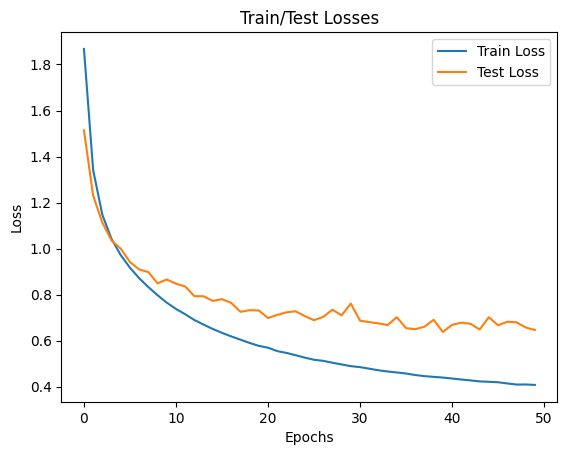

train_losses=[1.8674967857201894, 1.341124296453264, 1.147067075424724, 1.0420471891827054, 0.9716636932657825, 0.9171910515626271, 0.8716761390931076, 0.833010792930921, 0.797558139834139, 0.7654255714582072, 0.7381005980802907, 0.7151170885496669, 0.6900762588679791, 0.6700226945132017, 0.6511103837738434, 0.6343378074119489, 0.6189066469868024, 0.6047868094899588, 0.5904197672357162, 0.5776988931612836, 0.5697068301704195, 0.5550825390749508, 0.5471223645922211, 0.5372274866104126, 0.5266477853871054, 0.5173569242192639, 0.5126230446443789, 0.5044300832913982, 0.49704531993965306, 0.48959219808876514, 0.48542690364105834, 0.4786271408134037, 0.4717283326966895, 0.46641485877997346, 0.4622074462585151, 0.45768061716895964, 0.4510986832400991, 0.44625310209393504, 0.44311313862870966, 0.4401065335438276, 0.43599559633019896, 0.43151565064407055, 0.42779248446557255, 0.42331099694304997, 0.4216612546874417, 0.41967469272928104, 0.4145608020275831, 0.40969862713892424, 0.410050910853677

100%|██████████| 250/250 [00:00<00:00, 1331.02it/s]


Epoch [1/50], Train Loss: 1.5554, Train Accuracy: 49.88%, Test Loss: 1.3313, Test Accuracy: 57.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1388.19it/s]


Epoch [2/50], Train Loss: 1.1303, Train Accuracy: 64.74%, Test Loss: 0.9943, Test Accuracy: 70.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1008.96it/s]


Epoch [3/50], Train Loss: 0.9977, Train Accuracy: 69.53%, Test Loss: 1.0228, Test Accuracy: 69.25%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1448.75it/s]


Epoch [4/50], Train Loss: 0.9051, Train Accuracy: 72.08%, Test Loss: 0.9850, Test Accuracy: 71.00%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1367.55it/s]


Epoch [5/50], Train Loss: 0.8467, Train Accuracy: 74.27%, Test Loss: 0.9713, Test Accuracy: 71.20%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 952.88it/s]


Epoch [6/50], Train Loss: 0.8076, Train Accuracy: 75.61%, Test Loss: 0.9712, Test Accuracy: 72.00%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1388.18it/s]


Epoch [7/50], Train Loss: 0.7694, Train Accuracy: 76.87%, Test Loss: 1.0322, Test Accuracy: 70.95%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1390.37it/s]


Epoch [8/50], Train Loss: 0.7533, Train Accuracy: 77.09%, Test Loss: 0.8412, Test Accuracy: 75.65%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1427.43it/s]


Epoch [9/50], Train Loss: 0.7189, Train Accuracy: 78.08%, Test Loss: 0.8150, Test Accuracy: 75.85%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1437.12it/s]


Epoch [10/50], Train Loss: 0.7076, Train Accuracy: 78.76%, Test Loss: 0.8266, Test Accuracy: 76.55%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1371.33it/s]


Epoch [11/50], Train Loss: 0.6828, Train Accuracy: 79.18%, Test Loss: 0.8502, Test Accuracy: 75.30%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1297.07it/s]


Epoch [12/50], Train Loss: 0.6796, Train Accuracy: 79.73%, Test Loss: 0.9925, Test Accuracy: 74.00%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1313.34it/s]


Epoch [13/50], Train Loss: 0.6683, Train Accuracy: 79.98%, Test Loss: 1.0010, Test Accuracy: 73.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1104.86it/s]


Epoch [14/50], Train Loss: 0.6551, Train Accuracy: 80.34%, Test Loss: 0.9498, Test Accuracy: 73.90%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1421.48it/s]


Epoch [15/50], Train Loss: 0.6404, Train Accuracy: 80.80%, Test Loss: 0.9024, Test Accuracy: 74.35%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1376.68it/s]


Epoch [16/50], Train Loss: 0.6299, Train Accuracy: 80.90%, Test Loss: 0.9424, Test Accuracy: 75.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1114.62it/s]


Epoch [17/50], Train Loss: 0.6281, Train Accuracy: 80.98%, Test Loss: 0.9921, Test Accuracy: 74.85%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1384.23it/s]


Epoch [18/50], Train Loss: 0.6261, Train Accuracy: 81.11%, Test Loss: 0.7792, Test Accuracy: 78.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1371.46it/s]


Epoch [19/50], Train Loss: 0.6146, Train Accuracy: 81.92%, Test Loss: 0.8404, Test Accuracy: 77.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1319.49it/s]


Epoch [20/50], Train Loss: 0.6066, Train Accuracy: 82.04%, Test Loss: 0.8608, Test Accuracy: 76.95%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1348.47it/s]


Epoch [21/50], Train Loss: 0.6054, Train Accuracy: 82.01%, Test Loss: 0.9828, Test Accuracy: 75.00%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1129.93it/s]


Epoch [22/50], Train Loss: 0.5991, Train Accuracy: 81.95%, Test Loss: 0.8789, Test Accuracy: 76.35%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1362.04it/s]


Epoch [23/50], Train Loss: 0.5994, Train Accuracy: 81.94%, Test Loss: 1.1721, Test Accuracy: 71.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1397.56it/s]


Epoch [24/50], Train Loss: 0.5860, Train Accuracy: 82.21%, Test Loss: 0.9043, Test Accuracy: 76.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 978.85it/s]


Epoch [25/50], Train Loss: 0.5794, Train Accuracy: 82.58%, Test Loss: 1.0676, Test Accuracy: 75.20%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1390.01it/s]


Epoch [26/50], Train Loss: 0.5817, Train Accuracy: 82.77%, Test Loss: 1.2165, Test Accuracy: 72.75%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1419.93it/s]


Epoch [27/50], Train Loss: 0.5765, Train Accuracy: 82.65%, Test Loss: 1.0513, Test Accuracy: 73.80%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1303.39it/s]


Epoch [28/50], Train Loss: 0.5731, Train Accuracy: 82.71%, Test Loss: 0.9765, Test Accuracy: 75.75%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1323.10it/s]


Epoch [29/50], Train Loss: 0.5693, Train Accuracy: 82.62%, Test Loss: 0.8887, Test Accuracy: 76.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1105.58it/s]


Epoch [30/50], Train Loss: 0.5744, Train Accuracy: 83.21%, Test Loss: 0.9671, Test Accuracy: 75.25%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1396.94it/s]


Epoch [31/50], Train Loss: 0.5640, Train Accuracy: 83.02%, Test Loss: 1.0645, Test Accuracy: 74.20%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1341.39it/s]


Epoch [32/50], Train Loss: 0.5663, Train Accuracy: 83.18%, Test Loss: 1.0140, Test Accuracy: 74.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1070.13it/s]


Epoch [33/50], Train Loss: 0.5583, Train Accuracy: 83.29%, Test Loss: 0.8399, Test Accuracy: 78.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1384.74it/s]


Epoch [34/50], Train Loss: 0.5585, Train Accuracy: 83.49%, Test Loss: 0.9813, Test Accuracy: 74.90%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1362.10it/s]


Epoch [35/50], Train Loss: 0.5458, Train Accuracy: 83.63%, Test Loss: 0.9757, Test Accuracy: 75.60%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1379.22it/s]


Epoch [36/50], Train Loss: 0.5531, Train Accuracy: 83.28%, Test Loss: 0.9096, Test Accuracy: 76.60%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1310.19it/s]


Epoch [37/50], Train Loss: 0.5562, Train Accuracy: 83.78%, Test Loss: 0.9601, Test Accuracy: 75.35%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1012.52it/s]


Epoch [38/50], Train Loss: 0.5459, Train Accuracy: 83.66%, Test Loss: 0.9174, Test Accuracy: 76.90%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1367.73it/s]


Epoch [39/50], Train Loss: 0.5590, Train Accuracy: 83.63%, Test Loss: 0.9879, Test Accuracy: 74.80%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1392.08it/s]


Epoch [40/50], Train Loss: 0.5425, Train Accuracy: 83.98%, Test Loss: 0.8973, Test Accuracy: 77.35%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1051.17it/s]


Epoch [41/50], Train Loss: 0.5450, Train Accuracy: 83.83%, Test Loss: 0.9174, Test Accuracy: 77.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1369.79it/s]


Epoch [42/50], Train Loss: 0.5454, Train Accuracy: 83.81%, Test Loss: 0.9752, Test Accuracy: 74.90%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1318.32it/s]


Epoch [43/50], Train Loss: 0.5483, Train Accuracy: 83.93%, Test Loss: 1.0289, Test Accuracy: 75.00%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1308.54it/s]


Epoch [44/50], Train Loss: 0.5404, Train Accuracy: 83.76%, Test Loss: 0.8465, Test Accuracy: 77.80%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1335.43it/s]


Epoch [45/50], Train Loss: 0.5375, Train Accuracy: 84.04%, Test Loss: 1.0856, Test Accuracy: 73.80%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1333.90it/s]


Epoch [46/50], Train Loss: 0.5437, Train Accuracy: 83.96%, Test Loss: 1.0134, Test Accuracy: 75.75%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1402.25it/s]


Epoch [47/50], Train Loss: 0.5369, Train Accuracy: 84.13%, Test Loss: 0.8300, Test Accuracy: 78.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1346.93it/s]


Epoch [48/50], Train Loss: 0.5348, Train Accuracy: 83.89%, Test Loss: 1.0620, Test Accuracy: 74.35%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1097.10it/s]


Epoch [49/50], Train Loss: 0.5327, Train Accuracy: 84.03%, Test Loss: 0.9682, Test Accuracy: 76.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1369.60it/s]


Epoch [50/50], Train Loss: 0.5305, Train Accuracy: 84.21%, Test Loss: 1.0737, Test Accuracy: 73.85%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1505.80it/s]


Test Accuracy with learning rate 0.001: 73.80%


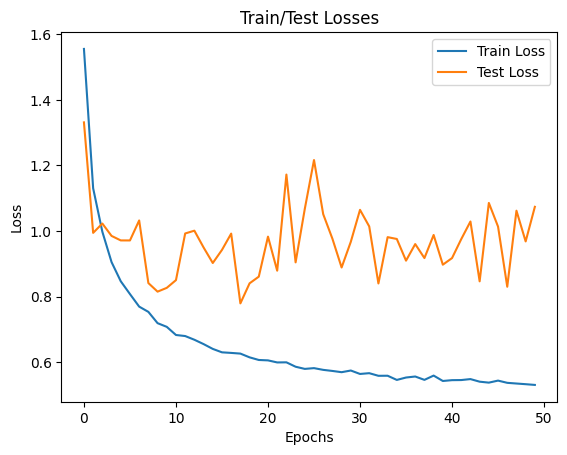

train_losses=[1.5553560968107647, 1.1302817383772796, 0.9976538153654999, 0.9051286360149582, 0.8466958210319281, 0.8076454492857059, 0.769375002188815, 0.7533321011772173, 0.7189074054020974, 0.7076337690879073, 0.6828053844542139, 0.6796056188233197, 0.6683002271020992, 0.6550532187345541, 0.640371291536217, 0.6299272545215984, 0.6281481564727922, 0.6260673172749682, 0.6146131906650133, 0.6065986923875494, 0.6053848164308195, 0.5990954982540053, 0.5994183595136532, 0.586001380929206, 0.5793956991532921, 0.5817272962696023, 0.5764622509594386, 0.5731411832218162, 0.5693443729351793, 0.574441923416737, 0.563965340263676, 0.5663341240230948, 0.5583356490081383, 0.5585393745786407, 0.5457507693324394, 0.5530806099162955, 0.5561799673375984, 0.5459357359181676, 0.5589921434317819, 0.5425323135697593, 0.545046154117729, 0.5453606382788987, 0.5483005444449373, 0.5404054221593672, 0.5374866955341875, 0.5436860048495971, 0.5368939789690647, 0.5347867835897228, 0.5327369877473037, 0.5305157419

In [60]:
result_50 = pd.DataFrame(columns=['optimizer', 'learning_rate', 'weight_decay', 'test_accuracy'])
num_epochs = 50
params = [(optim.SGD, 0.01, 0.001), (optim.RMSprop, 0.0001, 0.0001), (optim.RMSprop, 0.0001, 0.0010), (optim.RMSprop, 0.0010, 0.0001)]

result_50 = run(params, num_epochs, result_50)

In [62]:
result_50_sorted = result_50.sort_values(by=['test_accuracy'], ascending=False)
result_50_sorted

,optimizer,learning_rate,weight_decay,test_accuracy
0,RMSprop,0.0001,0.0001,0.8230
0,RMSprop,0.0001,0.0010,0.8220
0,SGD,0.0100,0.0010,0.8105
0,RMSprop,0.0010,0.0001,0.7870


На 50-ти эпохах модель с SGD оптимизатором оказалось не самой худшей. Однако лучшими по метрикам остались модели с RMSprop оптимизатором.

# **Batch normalization**

Добавим в нейронную сеть нормализацию батчей и обучим ее на разных параметрах.

In [64]:
class SimpleClassificationNetBatchNorm(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleClassificationNetBatchNorm, self).__init__()
        self.fc1 = CustomFullyConnectedLayer(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = CustomReluLayer()
        self.fc2 = CustomFullyConnectedLayer(hidden_size, output_size)
        self.bn2 = nn.BatchNorm1d(output_size)

    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.bn1.forward(x)
        x = self.relu.forward(x)
        x = self.fc2.forward(x)
        x = self.bn2.forward(x)
        return x

In [65]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

def run_batch_norm(params, num_epochs, res):
  for param in params:
    opt = param[0]
    lr = param[1]
    w = param[2]
    model = SimpleClassificationNetBatchNorm(input_size=3072, hidden_size=256, output_size=10).to(device)

    print(f"Params: lr={lr}, w={w}, opt={opt}")
    train_losses, test_losses, res = train(model, opt, train_loader, val_loader, num_epochs, lr, w, res)

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(tqdm(test_loader)):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f"Test Accuracy with learning rate {lr}: {100 * accuracy:.2f}%")

    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Train/Test Losses')
    plt.legend()
    plt.show()

    print(f"{train_losses=}\n{test_losses}")

  return res

Params: lr=0.0001, w=0.0001, opt=<class 'torch.optim.sgd.SGD'>


100%|██████████| 250/250 [00:00<00:00, 1358.48it/s]


Epoch [1/10], Train Loss: 2.3073, Train Accuracy: 9.26%, Test Loss: 2.3013, Test Accuracy: 12.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1307.21it/s]


Epoch [2/10], Train Loss: 2.2947, Train Accuracy: 15.44%, Test Loss: 2.2907, Test Accuracy: 17.20%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1026.12it/s]


Epoch [3/10], Train Loss: 2.2840, Train Accuracy: 18.59%, Test Loss: 2.2817, Test Accuracy: 18.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1400.60it/s]


Epoch [4/10], Train Loss: 2.2749, Train Accuracy: 18.96%, Test Loss: 2.2740, Test Accuracy: 18.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1450.42it/s]


Epoch [5/10], Train Loss: 2.2671, Train Accuracy: 18.89%, Test Loss: 2.2675, Test Accuracy: 18.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1071.99it/s]


Epoch [6/10], Train Loss: 2.2604, Train Accuracy: 18.83%, Test Loss: 2.2620, Test Accuracy: 18.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1405.04it/s]


Epoch [7/10], Train Loss: 2.2548, Train Accuracy: 18.83%, Test Loss: 2.2574, Test Accuracy: 18.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1426.68it/s]


Epoch [8/10], Train Loss: 2.2499, Train Accuracy: 18.86%, Test Loss: 2.2534, Test Accuracy: 18.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1094.83it/s]


Epoch [9/10], Train Loss: 2.2458, Train Accuracy: 18.89%, Test Loss: 2.2501, Test Accuracy: 18.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1387.12it/s]


Epoch [10/10], Train Loss: 2.2423, Train Accuracy: 18.87%, Test Loss: 2.2472, Test Accuracy: 18.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1498.64it/s]


Test Accuracy with learning rate 0.0001: 19.15%


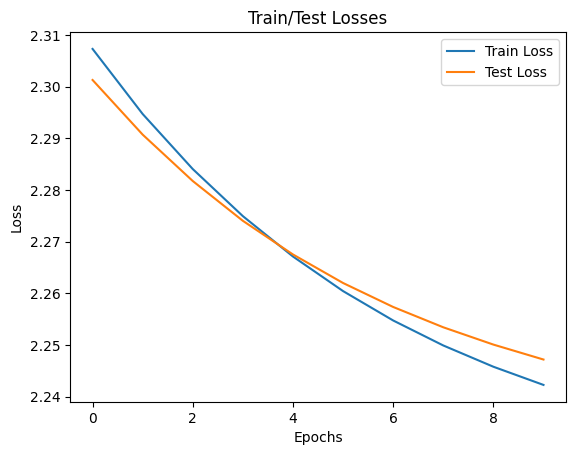

train_losses=[2.3072917868296305, 2.2947003099653456, 2.284049409124586, 2.2749414239459567, 2.26713098971049, 2.2604414040777416, 2.2547563830481634, 2.2499235377841527, 2.2458101935386656, 2.2422911377482944]
[2.3012816524505615, 2.290711480140686, 2.281734079360962, 2.2740367603302003, 2.2675256299972535, 2.2620070648193358, 2.257369941711426, 2.253440114021301, 2.2500945286750795, 2.247203161239624]
Params: lr=0.0001, w=0.001, opt=<class 'torch.optim.sgd.SGD'>


100%|██████████| 250/250 [00:00<00:00, 1373.22it/s]


Epoch [1/10], Train Loss: 2.2991, Train Accuracy: 15.49%, Test Loss: 2.2949, Test Accuracy: 17.35%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1082.83it/s]


Epoch [2/10], Train Loss: 2.2886, Train Accuracy: 18.18%, Test Loss: 2.2860, Test Accuracy: 18.00%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1417.56it/s]


Epoch [3/10], Train Loss: 2.2796, Train Accuracy: 18.64%, Test Loss: 2.2783, Test Accuracy: 18.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1419.14it/s]


Epoch [4/10], Train Loss: 2.2718, Train Accuracy: 18.78%, Test Loss: 2.2718, Test Accuracy: 18.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1058.88it/s]


Epoch [5/10], Train Loss: 2.2651, Train Accuracy: 18.80%, Test Loss: 2.2661, Test Accuracy: 18.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1410.81it/s]


Epoch [6/10], Train Loss: 2.2592, Train Accuracy: 18.80%, Test Loss: 2.2613, Test Accuracy: 18.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1405.33it/s]


Epoch [7/10], Train Loss: 2.2540, Train Accuracy: 18.80%, Test Loss: 2.2571, Test Accuracy: 18.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 935.07it/s]


Epoch [8/10], Train Loss: 2.2496, Train Accuracy: 18.80%, Test Loss: 2.2534, Test Accuracy: 18.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1342.07it/s]


Epoch [9/10], Train Loss: 2.2457, Train Accuracy: 18.81%, Test Loss: 2.2502, Test Accuracy: 18.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1366.39it/s]


Epoch [10/10], Train Loss: 2.2423, Train Accuracy: 18.81%, Test Loss: 2.2474, Test Accuracy: 18.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1541.12it/s]


Test Accuracy with learning rate 0.0001: 18.65%


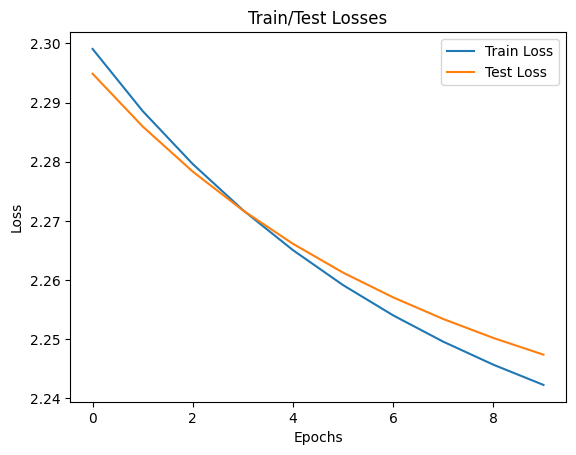

train_losses=[2.299059469964769, 2.2885645700030857, 2.27960521613227, 2.271835589726766, 2.2650581805970935, 2.259152467833625, 2.254037849850125, 2.2495909223026698, 2.24570206340154, 2.2422863083415563]
[2.2948696613311768, 2.2859583530426026, 2.2783329582214353, 2.271783862113953, 2.2661324682235717, 2.2612600450515745, 2.2570771589279173, 2.2534214572906492, 2.2502213430404665, 2.2473956694602966]
Params: lr=0.0001, w=0.01, opt=<class 'torch.optim.sgd.SGD'>


100%|██████████| 250/250 [00:00<00:00, 1374.55it/s]


Epoch [1/10], Train Loss: 2.2929, Train Accuracy: 16.10%, Test Loss: 2.2905, Test Accuracy: 17.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1386.92it/s]


Epoch [2/10], Train Loss: 2.2820, Train Accuracy: 18.38%, Test Loss: 2.2814, Test Accuracy: 17.85%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1366.96it/s]


Epoch [3/10], Train Loss: 2.2732, Train Accuracy: 18.76%, Test Loss: 2.2741, Test Accuracy: 18.25%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1320.97it/s]


Epoch [4/10], Train Loss: 2.2658, Train Accuracy: 18.81%, Test Loss: 2.2679, Test Accuracy: 18.30%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1396.11it/s]


Epoch [5/10], Train Loss: 2.2596, Train Accuracy: 18.84%, Test Loss: 2.2627, Test Accuracy: 18.35%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1393.75it/s]


Epoch [6/10], Train Loss: 2.2543, Train Accuracy: 18.81%, Test Loss: 2.2584, Test Accuracy: 18.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1406.44it/s]


Epoch [7/10], Train Loss: 2.2498, Train Accuracy: 18.83%, Test Loss: 2.2547, Test Accuracy: 18.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1379.62it/s]


Epoch [8/10], Train Loss: 2.2459, Train Accuracy: 18.84%, Test Loss: 2.2515, Test Accuracy: 18.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1389.81it/s]


Epoch [9/10], Train Loss: 2.2425, Train Accuracy: 18.84%, Test Loss: 2.2488, Test Accuracy: 18.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1401.67it/s]


Epoch [10/10], Train Loss: 2.2396, Train Accuracy: 18.86%, Test Loss: 2.2463, Test Accuracy: 18.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1449.48it/s]


Test Accuracy with learning rate 0.0001: 18.70%


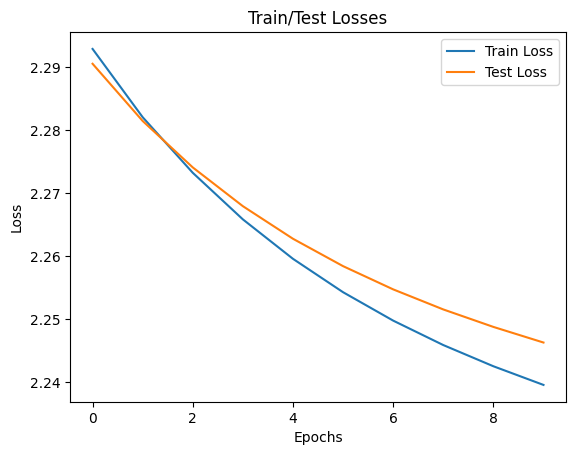

train_losses=[2.2928524869283042, 2.282019578615824, 2.2732016281551783, 2.265813181877136, 2.2595562636057536, 2.2542590993245444, 2.2497534963289896, 2.2458773010041977, 2.2425155998865764, 2.2395534471405876]
[2.2904976959228516, 2.2814198312759397, 2.2740545711517335, 2.267907286643982, 2.262738850593567, 2.258393578529358, 2.254709758758545, 2.2515273332595824, 2.2487557625770567, 2.2462771520614626]
Params: lr=0.001, w=0.0001, opt=<class 'torch.optim.sgd.SGD'>


100%|██████████| 250/250 [00:00<00:00, 1357.65it/s]


Epoch [1/10], Train Loss: 2.2643, Train Accuracy: 18.19%, Test Loss: 2.2473, Test Accuracy: 18.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1009.40it/s]


Epoch [2/10], Train Loss: 2.2299, Train Accuracy: 18.87%, Test Loss: 2.2270, Test Accuracy: 18.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1389.31it/s]


Epoch [3/10], Train Loss: 2.2080, Train Accuracy: 19.16%, Test Loss: 2.2033, Test Accuracy: 19.25%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1386.99it/s]


Epoch [4/10], Train Loss: 2.1811, Train Accuracy: 20.05%, Test Loss: 2.1729, Test Accuracy: 20.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1085.15it/s]


Epoch [5/10], Train Loss: 2.1465, Train Accuracy: 21.77%, Test Loss: 2.1341, Test Accuracy: 21.25%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1468.21it/s]


Epoch [6/10], Train Loss: 2.1038, Train Accuracy: 23.93%, Test Loss: 2.0861, Test Accuracy: 23.95%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1412.30it/s]


Epoch [7/10], Train Loss: 2.0544, Train Accuracy: 27.07%, Test Loss: 2.0333, Test Accuracy: 28.00%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1106.97it/s]


Epoch [8/10], Train Loss: 1.9990, Train Accuracy: 30.26%, Test Loss: 1.9735, Test Accuracy: 31.90%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1325.25it/s]


Epoch [9/10], Train Loss: 1.9389, Train Accuracy: 34.44%, Test Loss: 1.9112, Test Accuracy: 34.80%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1381.70it/s]


Epoch [10/10], Train Loss: 1.8760, Train Accuracy: 37.71%, Test Loss: 1.8476, Test Accuracy: 38.55%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1471.70it/s]


Test Accuracy with learning rate 0.001: 40.00%


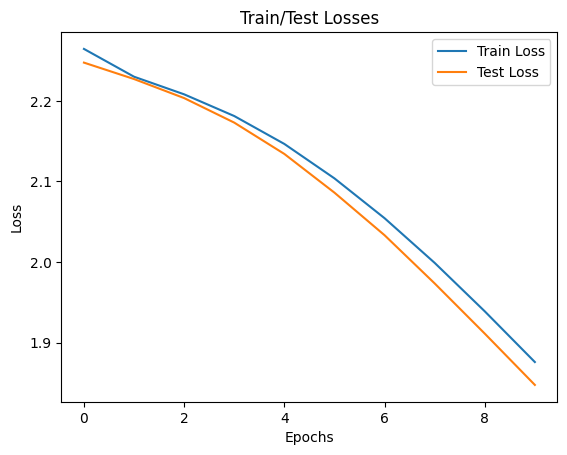

train_losses=[2.2643313327365453, 2.229854416900211, 2.2080141491889953, 2.1810986140039232, 2.146476662794749, 2.10377595143848, 2.0544057512813145, 1.99898789162106, 1.938900116496616, 1.8759876754018996]
[2.2473464283943176, 2.226976041793823, 2.2033480134010315, 2.17292107629776, 2.134072144508362, 2.086067157745361, 2.033289179801941, 1.9735022478103639, 1.9112473163604737, 1.8476100358963012]
Params: lr=0.001, w=0.001, opt=<class 'torch.optim.sgd.SGD'>


100%|██████████| 250/250 [00:00<00:00, 1019.56it/s]


Epoch [1/10], Train Loss: 2.2615, Train Accuracy: 18.13%, Test Loss: 2.2466, Test Accuracy: 18.80%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1363.18it/s]


Epoch [2/10], Train Loss: 2.2273, Train Accuracy: 19.23%, Test Loss: 2.2256, Test Accuracy: 18.75%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1349.76it/s]


Epoch [3/10], Train Loss: 2.2053, Train Accuracy: 19.29%, Test Loss: 2.2016, Test Accuracy: 19.60%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1035.27it/s]


Epoch [4/10], Train Loss: 2.1776, Train Accuracy: 20.72%, Test Loss: 2.1690, Test Accuracy: 20.30%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1301.25it/s]


Epoch [5/10], Train Loss: 2.1410, Train Accuracy: 22.22%, Test Loss: 2.1272, Test Accuracy: 21.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1383.06it/s]


Epoch [6/10], Train Loss: 2.0959, Train Accuracy: 24.31%, Test Loss: 2.0776, Test Accuracy: 24.60%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1013.15it/s]


Epoch [7/10], Train Loss: 2.0439, Train Accuracy: 27.50%, Test Loss: 2.0224, Test Accuracy: 28.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1398.15it/s]


Epoch [8/10], Train Loss: 1.9862, Train Accuracy: 31.01%, Test Loss: 1.9620, Test Accuracy: 31.90%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1378.82it/s]


Epoch [9/10], Train Loss: 1.9249, Train Accuracy: 34.59%, Test Loss: 1.8995, Test Accuracy: 34.85%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 947.09it/s]


Epoch [10/10], Train Loss: 1.8620, Train Accuracy: 38.07%, Test Loss: 1.8358, Test Accuracy: 38.20%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1149.60it/s]


Test Accuracy with learning rate 0.001: 40.00%


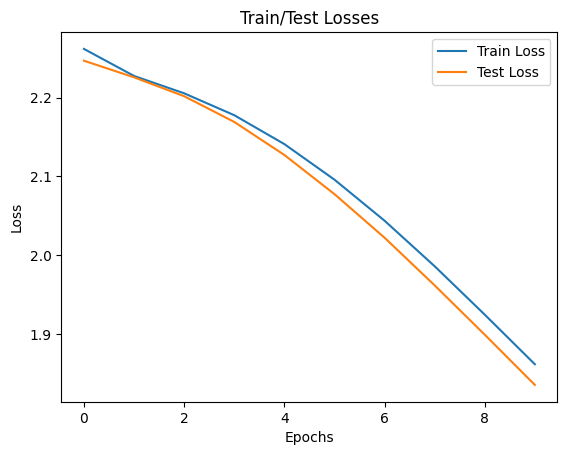

train_losses=[2.2615476812256707, 2.2272855780919394, 2.205322339322832, 2.1775656802919174, 2.1409626788563196, 2.0959151973724364, 2.0439105983310277, 1.9861844220691256, 1.9248657598495484, 1.8620279348161486]
[2.246592257499695, 2.225576781749725, 2.2016399579048156, 2.169048282146454, 2.127211769104004, 2.077586177825928, 2.0223571724891665, 1.9619762487411498, 1.8994543862342834, 1.8358414120674134]
Params: lr=0.001, w=0.01, opt=<class 'torch.optim.sgd.SGD'>


100%|██████████| 250/250 [00:00<00:00, 1356.50it/s]


Epoch [1/10], Train Loss: 2.2650, Train Accuracy: 18.38%, Test Loss: 2.2472, Test Accuracy: 18.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1276.48it/s]


Epoch [2/10], Train Loss: 2.2312, Train Accuracy: 18.87%, Test Loss: 2.2287, Test Accuracy: 18.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1028.82it/s]


Epoch [3/10], Train Loss: 2.2118, Train Accuracy: 19.13%, Test Loss: 2.2085, Test Accuracy: 19.25%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1367.65it/s]


Epoch [4/10], Train Loss: 2.1892, Train Accuracy: 19.99%, Test Loss: 2.1829, Test Accuracy: 19.55%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1379.26it/s]


Epoch [5/10], Train Loss: 2.1615, Train Accuracy: 20.90%, Test Loss: 2.1517, Test Accuracy: 20.55%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 868.91it/s]


Epoch [6/10], Train Loss: 2.1278, Train Accuracy: 22.44%, Test Loss: 2.1148, Test Accuracy: 23.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1383.28it/s]


Epoch [7/10], Train Loss: 2.0890, Train Accuracy: 24.95%, Test Loss: 2.0730, Test Accuracy: 25.30%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1378.73it/s]


Epoch [8/10], Train Loss: 2.0462, Train Accuracy: 27.43%, Test Loss: 2.0284, Test Accuracy: 28.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1368.48it/s]


Epoch [9/10], Train Loss: 2.0006, Train Accuracy: 30.56%, Test Loss: 1.9809, Test Accuracy: 31.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1299.59it/s]


Epoch [10/10], Train Loss: 1.9530, Train Accuracy: 33.70%, Test Loss: 1.9324, Test Accuracy: 33.80%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1471.82it/s]


Test Accuracy with learning rate 0.001: 36.25%


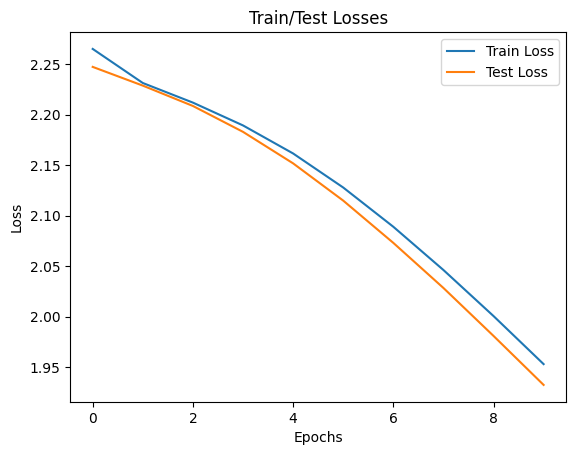

train_losses=[2.2649684391551546, 2.2312420161565143, 2.211832866721683, 2.189246596654256, 2.1614899661276077, 2.127797901418474, 2.0889677952130636, 2.0461721039877996, 2.000597082773844, 1.9530078335338168]
[2.247184289932251, 2.228654876708984, 2.2085121383666992, 2.1828912529945375, 2.1517059888839722, 2.1148442063331605, 2.0730135531425478, 2.0283983345031737, 1.9809374713897705, 1.9324176321029662]
Params: lr=0.01, w=0.0001, opt=<class 'torch.optim.sgd.SGD'>


100%|██████████| 250/250 [00:00<00:00, 1333.10it/s]


Epoch [1/10], Train Loss: 2.1086, Train Accuracy: 24.62%, Test Loss: 1.8665, Test Accuracy: 34.95%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1403.72it/s]


Epoch [2/10], Train Loss: 1.6092, Train Accuracy: 49.25%, Test Loss: 1.4194, Test Accuracy: 56.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1361.40it/s]


Epoch [3/10], Train Loss: 1.2951, Train Accuracy: 61.73%, Test Loss: 1.2188, Test Accuracy: 63.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1329.09it/s]


Epoch [4/10], Train Loss: 1.1295, Train Accuracy: 67.13%, Test Loss: 1.0946, Test Accuracy: 66.30%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1350.01it/s]


Epoch [5/10], Train Loss: 1.0223, Train Accuracy: 69.54%, Test Loss: 1.0273, Test Accuracy: 68.55%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1333.58it/s]


Epoch [6/10], Train Loss: 0.9481, Train Accuracy: 71.48%, Test Loss: 0.9749, Test Accuracy: 70.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1414.82it/s]


Epoch [7/10], Train Loss: 0.8904, Train Accuracy: 73.11%, Test Loss: 0.9406, Test Accuracy: 70.85%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1430.65it/s]


Epoch [8/10], Train Loss: 0.8387, Train Accuracy: 74.76%, Test Loss: 0.9026, Test Accuracy: 72.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1332.41it/s]


Epoch [9/10], Train Loss: 0.7935, Train Accuracy: 75.88%, Test Loss: 0.8779, Test Accuracy: 73.35%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1371.48it/s]


Epoch [10/10], Train Loss: 0.7501, Train Accuracy: 77.55%, Test Loss: 0.8646, Test Accuracy: 73.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1505.74it/s]


Test Accuracy with learning rate 0.01: 68.70%


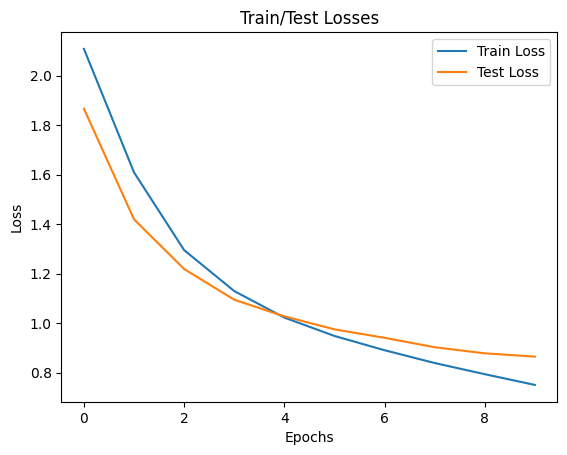

train_losses=[2.108580078866747, 1.6092415506574842, 1.2950815268357594, 1.1295224097834693, 1.0223350865840912, 0.9480590560204453, 0.8904260149068303, 0.8386917579935657, 0.7935397893637419, 0.7501373072142402]
[1.8665378618240356, 1.4194224076271058, 1.2187615597248078, 1.0946096028089523, 1.0273020614981652, 0.9748557552099227, 0.9406465807557106, 0.9025981408357621, 0.8778949953019619, 0.8645545749366284]
Params: lr=0.01, w=0.001, opt=<class 'torch.optim.sgd.SGD'>


100%|██████████| 250/250 [00:00<00:00, 1413.08it/s]


Epoch [1/10], Train Loss: 2.1125, Train Accuracy: 25.29%, Test Loss: 1.8681, Test Accuracy: 37.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1327.59it/s]


Epoch [2/10], Train Loss: 1.6248, Train Accuracy: 48.40%, Test Loss: 1.4274, Test Accuracy: 55.90%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1394.21it/s]


Epoch [3/10], Train Loss: 1.3150, Train Accuracy: 60.77%, Test Loss: 1.2215, Test Accuracy: 63.25%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1305.35it/s]


Epoch [4/10], Train Loss: 1.1497, Train Accuracy: 66.41%, Test Loss: 1.1213, Test Accuracy: 67.55%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1369.01it/s]


Epoch [5/10], Train Loss: 1.0457, Train Accuracy: 69.13%, Test Loss: 1.0364, Test Accuracy: 69.20%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1375.44it/s]


Epoch [6/10], Train Loss: 0.9701, Train Accuracy: 71.18%, Test Loss: 1.0080, Test Accuracy: 69.35%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1380.74it/s]


Epoch [7/10], Train Loss: 0.9131, Train Accuracy: 72.94%, Test Loss: 0.9554, Test Accuracy: 71.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1317.86it/s]


Epoch [8/10], Train Loss: 0.8636, Train Accuracy: 74.15%, Test Loss: 0.9225, Test Accuracy: 71.65%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1298.89it/s]


Epoch [9/10], Train Loss: 0.8230, Train Accuracy: 75.48%, Test Loss: 0.9050, Test Accuracy: 72.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1366.08it/s]


Epoch [10/10], Train Loss: 0.7835, Train Accuracy: 76.78%, Test Loss: 0.8605, Test Accuracy: 73.85%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1528.58it/s]


Test Accuracy with learning rate 0.01: 70.60%


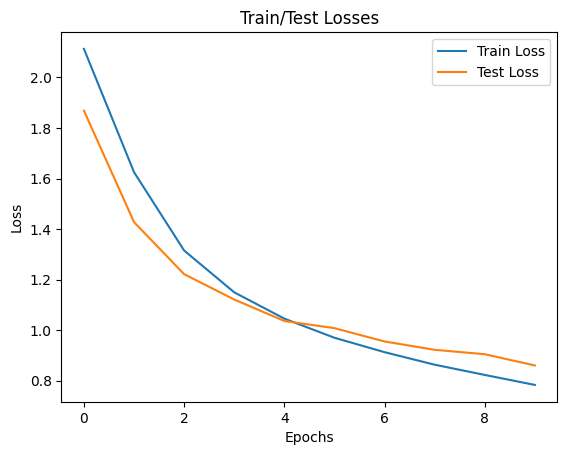

train_losses=[2.112526267157661, 1.624825703912311, 1.315013134876887, 1.149722680793868, 1.0457178158495162, 0.9700640352964401, 0.9131055240399307, 0.8635630138549539, 0.8230408962733216, 0.7835460239681933]
[1.8681243114471435, 1.4274411845207213, 1.2215329929590226, 1.1213384935855866, 1.0363967964649201, 1.0080319019556045, 0.9553792670965194, 0.9224642100930214, 0.9050151219367981, 0.8605324928462506]
Params: lr=0.01, w=0.01, opt=<class 'torch.optim.sgd.SGD'>


100%|██████████| 250/250 [00:00<00:00, 1323.52it/s]


Epoch [1/10], Train Loss: 2.1374, Train Accuracy: 23.49%, Test Loss: 1.9406, Test Accuracy: 33.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1056.59it/s]


Epoch [2/10], Train Loss: 1.7327, Train Accuracy: 43.66%, Test Loss: 1.5588, Test Accuracy: 53.20%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1413.97it/s]


Epoch [3/10], Train Loss: 1.4606, Train Accuracy: 55.73%, Test Loss: 1.3770, Test Accuracy: 59.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1307.70it/s]


Epoch [4/10], Train Loss: 1.3205, Train Accuracy: 61.54%, Test Loss: 1.2888, Test Accuracy: 62.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1070.41it/s]


Epoch [5/10], Train Loss: 1.2375, Train Accuracy: 65.08%, Test Loss: 1.2228, Test Accuracy: 63.55%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1409.12it/s]


Epoch [6/10], Train Loss: 1.1821, Train Accuracy: 66.86%, Test Loss: 1.1902, Test Accuracy: 64.65%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1349.08it/s]


Epoch [7/10], Train Loss: 1.1468, Train Accuracy: 67.88%, Test Loss: 1.1709, Test Accuracy: 66.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1070.20it/s]


Epoch [8/10], Train Loss: 1.1211, Train Accuracy: 68.84%, Test Loss: 1.1542, Test Accuracy: 66.65%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1257.91it/s]


Epoch [9/10], Train Loss: 1.1015, Train Accuracy: 69.25%, Test Loss: 1.1298, Test Accuracy: 68.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1366.55it/s]


Epoch [10/10], Train Loss: 1.0880, Train Accuracy: 69.82%, Test Loss: 1.1165, Test Accuracy: 68.80%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1498.89it/s]


Test Accuracy with learning rate 0.01: 65.75%


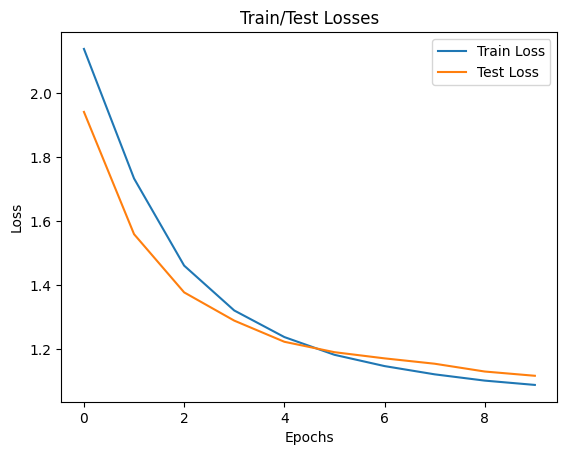

train_losses=[2.1373637363645765, 1.7327059404585097, 1.4605808236863878, 1.3204995762904486, 1.237493589176072, 1.1820713973177803, 1.1468339816596773, 1.1210623937182955, 1.1014510179890526, 1.088005150616169]
[1.9406195826530457, 1.5588122820854187, 1.3770231993198394, 1.288819112420082, 1.2227679182291031, 1.190246920824051, 1.1709360284805297, 1.1542100310325623, 1.1298356790542603, 1.1165491505861282]
Params: lr=0.0001, w=0.0001, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 250/250 [00:00<00:00, 938.47it/s]


Epoch [1/10], Train Loss: 1.8461, Train Accuracy: 39.91%, Test Loss: 1.4712, Test Accuracy: 57.00%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1314.53it/s]


Epoch [2/10], Train Loss: 1.3131, Train Accuracy: 62.24%, Test Loss: 1.2109, Test Accuracy: 63.75%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1352.51it/s]


Epoch [3/10], Train Loss: 1.1159, Train Accuracy: 67.77%, Test Loss: 1.0725, Test Accuracy: 67.55%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1342.58it/s]


Epoch [4/10], Train Loss: 1.0065, Train Accuracy: 70.62%, Test Loss: 1.0078, Test Accuracy: 69.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1369.60it/s]


Epoch [5/10], Train Loss: 0.9304, Train Accuracy: 72.41%, Test Loss: 0.9535, Test Accuracy: 70.85%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1113.85it/s]


Epoch [6/10], Train Loss: 0.8714, Train Accuracy: 74.00%, Test Loss: 0.9241, Test Accuracy: 71.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1354.65it/s]


Epoch [7/10], Train Loss: 0.8200, Train Accuracy: 75.65%, Test Loss: 0.8931, Test Accuracy: 72.85%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1351.62it/s]


Epoch [8/10], Train Loss: 0.7765, Train Accuracy: 76.77%, Test Loss: 0.8810, Test Accuracy: 71.85%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1020.59it/s]


Epoch [9/10], Train Loss: 0.7373, Train Accuracy: 78.32%, Test Loss: 0.8455, Test Accuracy: 73.60%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1381.73it/s]


Epoch [10/10], Train Loss: 0.7042, Train Accuracy: 79.11%, Test Loss: 0.8192, Test Accuracy: 75.00%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1502.37it/s]


Test Accuracy with learning rate 0.0001: 71.55%


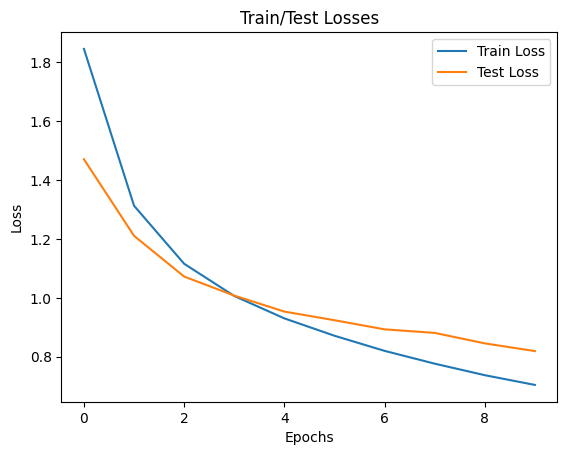

train_losses=[1.846120238966412, 1.3131371097167333, 1.1159316899114184, 1.0064900326099662, 0.9303687442276213, 0.8713619310855866, 0.8199649960464901, 0.7764837069544527, 0.7373168349828985, 0.7042144226862325]
[1.4711522617340087, 1.210905632853508, 1.072510294675827, 1.0078010140657425, 0.9535071505308151, 0.9241145679354668, 0.8930939653813839, 0.8810131482779979, 0.8454564436078071, 0.8192262279391289]
Params: lr=0.0001, w=0.001, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 250/250 [00:00<00:00, 1378.90it/s]


Epoch [1/10], Train Loss: 1.8533, Train Accuracy: 39.66%, Test Loss: 1.4910, Test Accuracy: 55.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1365.33it/s]


Epoch [2/10], Train Loss: 1.3430, Train Accuracy: 61.18%, Test Loss: 1.2232, Test Accuracy: 63.85%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1301.73it/s]


Epoch [3/10], Train Loss: 1.1544, Train Accuracy: 66.77%, Test Loss: 1.1145, Test Accuracy: 66.85%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 969.50it/s] 


Epoch [4/10], Train Loss: 1.0513, Train Accuracy: 69.38%, Test Loss: 1.0410, Test Accuracy: 69.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1327.40it/s]


Epoch [5/10], Train Loss: 0.9780, Train Accuracy: 71.17%, Test Loss: 0.9803, Test Accuracy: 70.25%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1328.77it/s]


Epoch [6/10], Train Loss: 0.9237, Train Accuracy: 73.23%, Test Loss: 0.9756, Test Accuracy: 70.90%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 996.14it/s] 


Epoch [7/10], Train Loss: 0.8788, Train Accuracy: 74.32%, Test Loss: 0.9230, Test Accuracy: 72.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1391.51it/s]


Epoch [8/10], Train Loss: 0.8377, Train Accuracy: 75.53%, Test Loss: 0.9095, Test Accuracy: 72.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1388.43it/s]


Epoch [9/10], Train Loss: 0.8051, Train Accuracy: 76.42%, Test Loss: 0.8860, Test Accuracy: 73.20%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1355.13it/s]


Epoch [10/10], Train Loss: 0.7719, Train Accuracy: 77.58%, Test Loss: 0.8527, Test Accuracy: 73.80%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1492.88it/s]


Test Accuracy with learning rate 0.0001: 71.75%


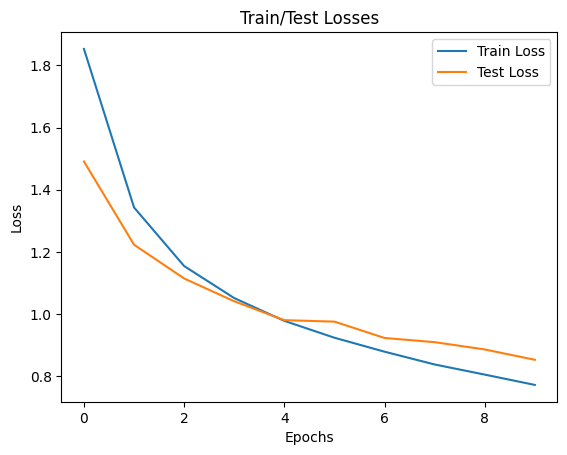

train_losses=[1.853316085020701, 1.3429845259189606, 1.1544262053171794, 1.051333080874549, 0.9780154643389913, 0.9237432217531734, 0.8787903077536159, 0.837684554129839, 0.8050746897392803, 0.7718679287019703]
[1.4909674084186555, 1.2231599456071853, 1.1144689809083939, 1.041002050280571, 0.9802568172216415, 0.9755620876550675, 0.9229713227152825, 0.909473346889019, 0.8860304605364799, 0.8527235945463181]
Params: lr=0.0001, w=0.01, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 250/250 [00:00<00:00, 1335.16it/s]


Epoch [1/10], Train Loss: 1.9223, Train Accuracy: 36.41%, Test Loss: 1.6754, Test Accuracy: 48.60%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1133.63it/s]


Epoch [2/10], Train Loss: 1.5418, Train Accuracy: 54.33%, Test Loss: 1.4573, Test Accuracy: 58.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1348.20it/s]


Epoch [3/10], Train Loss: 1.4081, Train Accuracy: 59.83%, Test Loss: 1.3604, Test Accuracy: 60.80%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1376.20it/s]


Epoch [4/10], Train Loss: 1.3299, Train Accuracy: 62.18%, Test Loss: 1.3084, Test Accuracy: 62.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1007.41it/s]


Epoch [5/10], Train Loss: 1.2775, Train Accuracy: 64.00%, Test Loss: 1.2643, Test Accuracy: 64.30%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1366.17it/s]


Epoch [6/10], Train Loss: 1.2393, Train Accuracy: 64.97%, Test Loss: 1.2578, Test Accuracy: 62.85%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1332.51it/s]


Epoch [7/10], Train Loss: 1.2082, Train Accuracy: 65.66%, Test Loss: 1.2288, Test Accuracy: 62.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1301.96it/s]


Epoch [8/10], Train Loss: 1.1866, Train Accuracy: 66.52%, Test Loss: 1.2010, Test Accuracy: 65.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1401.33it/s]


Epoch [9/10], Train Loss: 1.1667, Train Accuracy: 67.32%, Test Loss: 1.1708, Test Accuracy: 65.55%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1122.74it/s]


Epoch [10/10], Train Loss: 1.1526, Train Accuracy: 67.57%, Test Loss: 1.1479, Test Accuracy: 67.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1245.24it/s]


Test Accuracy with learning rate 0.0001: 65.60%


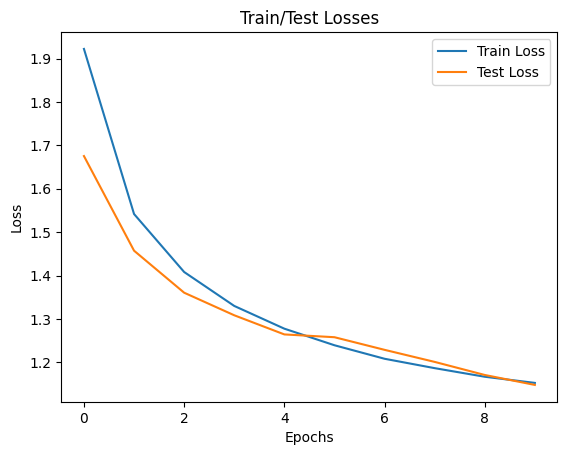

train_losses=[1.9222872105439504, 1.5417850540743934, 1.4081456923219893, 1.329920789361, 1.2775266452497906, 1.239328035765224, 1.208188231839074, 1.1865502954588996, 1.1667413292394744, 1.1525524363650217]
[1.6753721866607667, 1.4572759182453157, 1.360442949771881, 1.3084158720970154, 1.2642824339866638, 1.2578493576049805, 1.2287637040615083, 1.2009630179405213, 1.1708216104507447, 1.1478968393802642]
Params: lr=0.001, w=0.0001, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 250/250 [00:00<00:00, 1361.18it/s]


Epoch [1/10], Train Loss: 1.5435, Train Accuracy: 50.05%, Test Loss: 1.1816, Test Accuracy: 62.75%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1373.00it/s]


Epoch [2/10], Train Loss: 1.1237, Train Accuracy: 64.81%, Test Loss: 1.0000, Test Accuracy: 68.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 965.85it/s]


Epoch [3/10], Train Loss: 0.9923, Train Accuracy: 69.54%, Test Loss: 0.9075, Test Accuracy: 72.95%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1224.75it/s]


Epoch [4/10], Train Loss: 0.9141, Train Accuracy: 72.41%, Test Loss: 0.9637, Test Accuracy: 70.55%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1343.56it/s]


Epoch [5/10], Train Loss: 0.8530, Train Accuracy: 74.07%, Test Loss: 0.9117, Test Accuracy: 73.20%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1377.64it/s]


Epoch [6/10], Train Loss: 0.8050, Train Accuracy: 75.61%, Test Loss: 0.8543, Test Accuracy: 74.60%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1400.11it/s]


Epoch [7/10], Train Loss: 0.7742, Train Accuracy: 76.16%, Test Loss: 0.8514, Test Accuracy: 74.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 994.89it/s]


Epoch [8/10], Train Loss: 0.7467, Train Accuracy: 77.61%, Test Loss: 0.8783, Test Accuracy: 74.35%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1350.58it/s]


Epoch [9/10], Train Loss: 0.7298, Train Accuracy: 78.09%, Test Loss: 0.9987, Test Accuracy: 71.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1352.17it/s]


Epoch [10/10], Train Loss: 0.7082, Train Accuracy: 78.59%, Test Loss: 0.8884, Test Accuracy: 74.35%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1457.80it/s]


Test Accuracy with learning rate 0.001: 69.95%


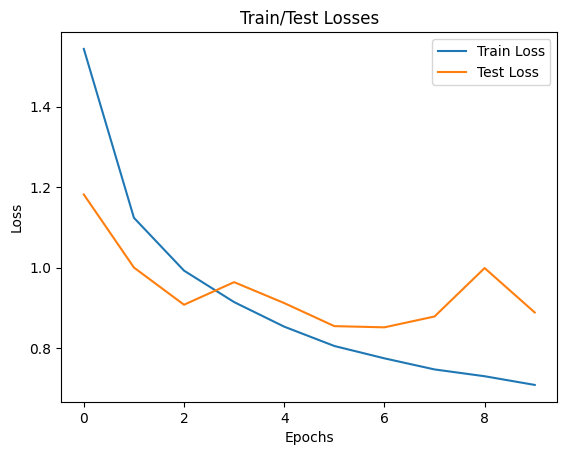

train_losses=[1.5435429754787022, 1.1236978314485815, 0.9923112579766247, 0.9141222548352348, 0.8530464436552591, 0.8049872655980289, 0.7742498759569393, 0.7467111949668163, 0.7297871721660097, 0.7081983581172924]
[1.181628151834011, 1.0000460951328278, 0.9075297866165638, 0.9637010227739811, 0.9116694110184907, 0.8543421623837203, 0.8513805319778621, 0.8783410249575972, 0.9987199167013169, 0.8883531710356474]
Params: lr=0.001, w=0.001, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 250/250 [00:00<00:00, 1018.92it/s]


Epoch [1/10], Train Loss: 1.6141, Train Accuracy: 47.72%, Test Loss: 1.4253, Test Accuracy: 53.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1383.33it/s]


Epoch [2/10], Train Loss: 1.2539, Train Accuracy: 60.26%, Test Loss: 1.2937, Test Accuracy: 59.65%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1328.68it/s]


Epoch [3/10], Train Loss: 1.1651, Train Accuracy: 63.46%, Test Loss: 1.1972, Test Accuracy: 61.65%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1374.62it/s]


Epoch [4/10], Train Loss: 1.1065, Train Accuracy: 65.82%, Test Loss: 1.0717, Test Accuracy: 66.80%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1282.06it/s]


Epoch [5/10], Train Loss: 1.0572, Train Accuracy: 67.19%, Test Loss: 1.0962, Test Accuracy: 65.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1036.81it/s]


Epoch [6/10], Train Loss: 1.0162, Train Accuracy: 68.79%, Test Loss: 1.1060, Test Accuracy: 65.30%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1349.18it/s]


Epoch [7/10], Train Loss: 0.9830, Train Accuracy: 69.54%, Test Loss: 1.0355, Test Accuracy: 67.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1316.92it/s]


Epoch [8/10], Train Loss: 0.9721, Train Accuracy: 69.96%, Test Loss: 0.9963, Test Accuracy: 69.20%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 966.08it/s]


Epoch [9/10], Train Loss: 0.9517, Train Accuracy: 70.61%, Test Loss: 1.0747, Test Accuracy: 68.75%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1345.34it/s]


Epoch [10/10], Train Loss: 0.9449, Train Accuracy: 70.98%, Test Loss: 1.2763, Test Accuracy: 63.00%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1518.35it/s]


Test Accuracy with learning rate 0.001: 60.85%


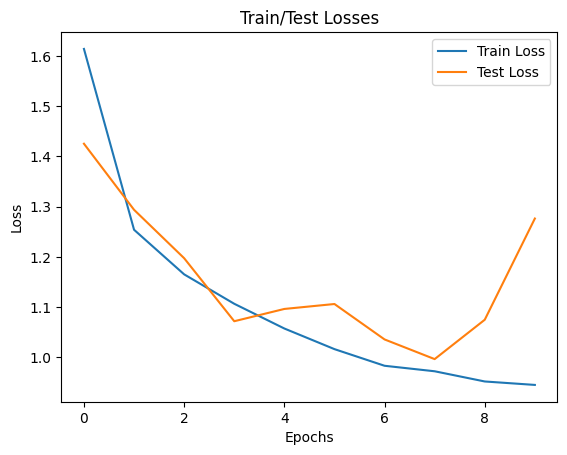

train_losses=[1.614058139403661, 1.2539166693025166, 1.1650884387161997, 1.1064925240476926, 1.057231638610363, 1.0161634657250511, 0.9830249367786779, 0.9720718357430564, 0.9517428700460328, 0.9448792478864392]
[1.425252115368843, 1.2936708186864854, 1.1972384425401688, 1.0717224081754684, 1.0961939307451247, 1.1060250322222709, 1.0354790719151497, 0.9962998227179051, 1.0747010841965676, 1.2762568098902702]
Params: lr=0.001, w=0.01, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 250/250 [00:00<00:00, 1318.22it/s]


Epoch [1/10], Train Loss: 1.9387, Train Accuracy: 34.43%, Test Loss: 1.6565, Test Accuracy: 43.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1350.22it/s]


Epoch [2/10], Train Loss: 1.6332, Train Accuracy: 45.64%, Test Loss: 1.5420, Test Accuracy: 49.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1321.32it/s]


Epoch [3/10], Train Loss: 1.5406, Train Accuracy: 50.06%, Test Loss: 1.5475, Test Accuracy: 50.30%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1343.10it/s]


Epoch [4/10], Train Loss: 1.4834, Train Accuracy: 52.64%, Test Loss: 1.5603, Test Accuracy: 49.35%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1340.88it/s]


Epoch [5/10], Train Loss: 1.4607, Train Accuracy: 53.36%, Test Loss: 1.3747, Test Accuracy: 55.20%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1256.83it/s]


Epoch [6/10], Train Loss: 1.4428, Train Accuracy: 53.89%, Test Loss: 1.4434, Test Accuracy: 54.30%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1088.32it/s]


Epoch [7/10], Train Loss: 1.4296, Train Accuracy: 54.84%, Test Loss: 1.3229, Test Accuracy: 59.65%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1346.84it/s]


Epoch [8/10], Train Loss: 1.4152, Train Accuracy: 55.50%, Test Loss: 1.4175, Test Accuracy: 54.55%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1260.70it/s]


Epoch [9/10], Train Loss: 1.4156, Train Accuracy: 55.57%, Test Loss: 1.3747, Test Accuracy: 57.30%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 961.37it/s] 


Epoch [10/10], Train Loss: 1.4090, Train Accuracy: 55.93%, Test Loss: 1.3526, Test Accuracy: 58.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1049.02it/s]


Test Accuracy with learning rate 0.001: 54.70%


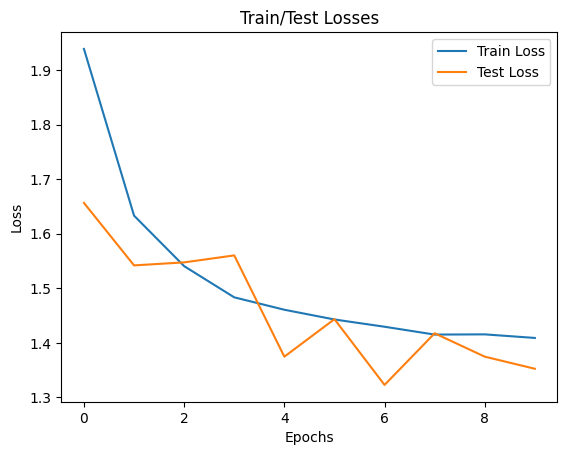

train_losses=[1.9387195490201314, 1.633168237845103, 1.5406128475003773, 1.4834286396900813, 1.460700115998586, 1.4428411073552239, 1.429550455570221, 1.4151853566169739, 1.4155619171592924, 1.4090165031221178]
[1.6565145370960235, 1.5419866359233856, 1.5474949569702148, 1.560298565864563, 1.3747101888656617, 1.4434118142127992, 1.322914605140686, 1.417524147748947, 1.3746946964263915, 1.3525529268980025]
Params: lr=0.01, w=0.0001, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 250/250 [00:00<00:00, 1264.70it/s]


Epoch [1/10], Train Loss: 7.7454, Train Accuracy: 30.39%, Test Loss: 4.1009, Test Accuracy: 38.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1295.94it/s]


Epoch [2/10], Train Loss: 4.9893, Train Accuracy: 42.42%, Test Loss: 3.2814, Test Accuracy: 47.30%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1320.44it/s]


Epoch [3/10], Train Loss: 4.3534, Train Accuracy: 45.41%, Test Loss: 4.9698, Test Accuracy: 43.90%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1170.10it/s]


Epoch [4/10], Train Loss: 4.1439, Train Accuracy: 45.88%, Test Loss: 5.0189, Test Accuracy: 41.30%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1119.07it/s]


Epoch [5/10], Train Loss: 4.6741, Train Accuracy: 45.69%, Test Loss: 11.4952, Test Accuracy: 31.90%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1285.62it/s]


Epoch [6/10], Train Loss: 4.6878, Train Accuracy: 46.58%, Test Loss: 4.0100, Test Accuracy: 47.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1319.10it/s]


Epoch [7/10], Train Loss: 4.5565, Train Accuracy: 46.54%, Test Loss: 3.6720, Test Accuracy: 47.60%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 998.28it/s]


Epoch [8/10], Train Loss: 4.5945, Train Accuracy: 47.60%, Test Loss: 3.1683, Test Accuracy: 46.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1373.80it/s]


Epoch [9/10], Train Loss: 4.4335, Train Accuracy: 47.77%, Test Loss: 4.4692, Test Accuracy: 45.90%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1396.36it/s]


Epoch [10/10], Train Loss: 4.5707, Train Accuracy: 47.44%, Test Loss: 3.6864, Test Accuracy: 50.00%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1544.09it/s]


Test Accuracy with learning rate 0.01: 44.90%


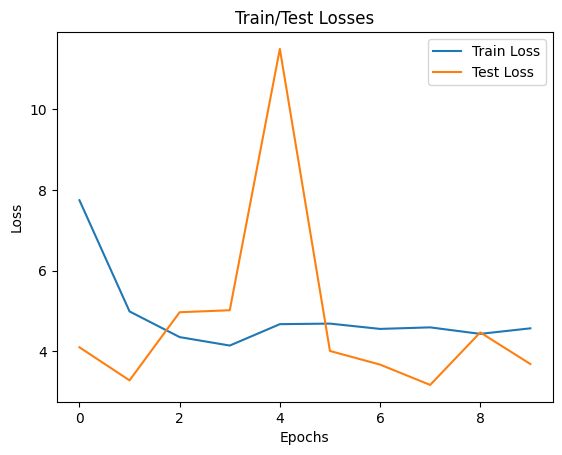

train_losses=[7.74538254203399, 4.989328323046366, 4.353362592879269, 4.143867031498088, 4.674067999416199, 4.687816406869226, 4.556541673890418, 4.594549733622206, 4.433469154758586, 4.570653143785066]
[4.100895661473274, 3.281404717683792, 4.969776325583458, 5.018871139764785, 11.49517957687378, 4.010002008318901, 3.672005277991295, 3.168316272735596, 4.469201535463333, 3.6863545055538416]
Params: lr=0.01, w=0.001, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 250/250 [00:00<00:00, 1343.99it/s]


Epoch [1/10], Train Loss: 6.7825, Train Accuracy: 22.91%, Test Loss: 10.0709, Test Accuracy: 25.25%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1301.92it/s]


Epoch [2/10], Train Loss: 4.9771, Train Accuracy: 27.36%, Test Loss: 8.1695, Test Accuracy: 18.25%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1011.93it/s]


Epoch [3/10], Train Loss: 5.0590, Train Accuracy: 28.36%, Test Loss: 5.7642, Test Accuracy: 26.00%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1275.31it/s]


Epoch [4/10], Train Loss: 5.1816, Train Accuracy: 28.61%, Test Loss: 3.4833, Test Accuracy: 31.35%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1319.23it/s]


Epoch [5/10], Train Loss: 4.9753, Train Accuracy: 28.48%, Test Loss: 7.7257, Test Accuracy: 26.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 985.12it/s]


Epoch [6/10], Train Loss: 5.1337, Train Accuracy: 28.60%, Test Loss: 3.9598, Test Accuracy: 29.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1355.90it/s]


Epoch [7/10], Train Loss: 5.1622, Train Accuracy: 28.77%, Test Loss: 3.9280, Test Accuracy: 28.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1309.68it/s]


Epoch [8/10], Train Loss: 5.0244, Train Accuracy: 29.68%, Test Loss: 9.7873, Test Accuracy: 19.85%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1247.00it/s]


Epoch [9/10], Train Loss: 4.9755, Train Accuracy: 29.24%, Test Loss: 6.5096, Test Accuracy: 23.35%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1365.23it/s]


Epoch [10/10], Train Loss: 5.0894, Train Accuracy: 28.61%, Test Loss: 2.8905, Test Accuracy: 34.55%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1508.76it/s]


Test Accuracy with learning rate 0.01: 30.95%


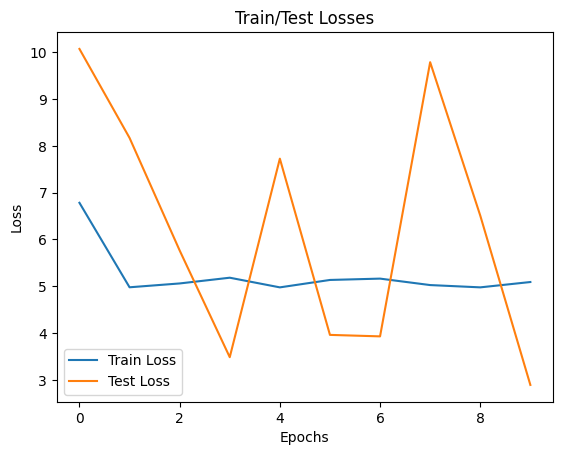

train_losses=[6.782518837372462, 4.977064687331517, 5.0590359862777925, 5.181615755001704, 4.975290177928077, 5.133740338537428, 5.162249869452583, 5.024375921408335, 4.9754818772077565, 5.0893781115478935]
[10.070897134304047, 8.16951453113556, 5.764199165821076, 3.483320239543915, 7.725734693288803, 3.9597734401226043, 3.928025258541107, 9.787296970367432, 6.509625609159469, 2.8905201761722563]
Params: lr=0.01, w=0.01, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 250/250 [00:00<00:00, 994.96it/s]


Epoch [1/10], Train Loss: 7.1110, Train Accuracy: 12.67%, Test Loss: 7.9719, Test Accuracy: 14.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1354.30it/s]


Epoch [2/10], Train Loss: 6.3011, Train Accuracy: 12.30%, Test Loss: 5.6328, Test Accuracy: 13.75%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1365.85it/s]


Epoch [3/10], Train Loss: 6.2457, Train Accuracy: 12.57%, Test Loss: 6.3861, Test Accuracy: 8.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 917.85it/s]


Epoch [4/10], Train Loss: 6.2207, Train Accuracy: 12.82%, Test Loss: 6.7057, Test Accuracy: 10.55%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1354.67it/s]


Epoch [5/10], Train Loss: 6.1942, Train Accuracy: 13.03%, Test Loss: 9.8028, Test Accuracy: 8.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1326.84it/s]


Epoch [6/10], Train Loss: 6.2368, Train Accuracy: 12.40%, Test Loss: 4.7789, Test Accuracy: 12.60%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1359.20it/s]


Epoch [7/10], Train Loss: 6.2967, Train Accuracy: 12.80%, Test Loss: 6.8716, Test Accuracy: 10.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1335.31it/s]


Epoch [8/10], Train Loss: 6.2870, Train Accuracy: 12.39%, Test Loss: 3.0652, Test Accuracy: 12.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1339.90it/s]


Epoch [9/10], Train Loss: 6.1980, Train Accuracy: 12.66%, Test Loss: 4.7449, Test Accuracy: 14.85%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1332.13it/s]


Epoch [10/10], Train Loss: 6.1711, Train Accuracy: 12.67%, Test Loss: 11.0738, Test Accuracy: 9.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1467.73it/s]


Test Accuracy with learning rate 0.01: 8.95%


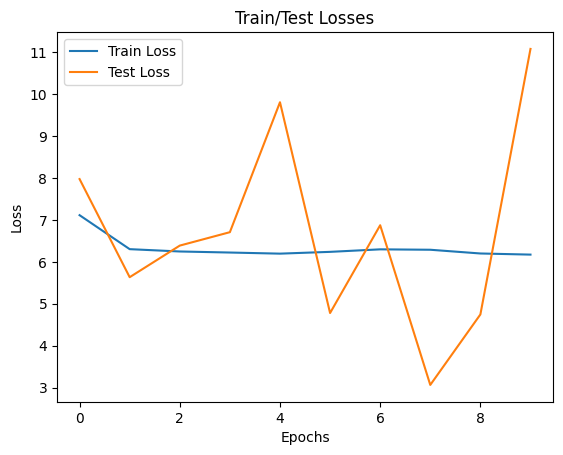

train_losses=[7.110958720101251, 6.301149980121188, 6.245728546407488, 6.2206846474541555, 6.194221831109789, 6.236781467914581, 6.296729897499085, 6.286959421316783, 6.1980387845569185, 6.171149269845751]
[7.9718881578445435, 5.6328375782966615, 6.386053543090821, 6.705737864494323, 9.802837850570679, 4.778905010223388, 6.871623861312866, 3.06516428565979, 4.744924864292145, 11.073773859977722]


In [66]:
result_batch_norm = pd.DataFrame(columns=['optimizer', 'learning_rate', 'weight_decay', 'test_accuracy'])
num_epochs = 10
weight_decay_list = [0.0001, 0.001, 0.01]
learning_rates = [0.0001, 0.001, 0.01]
optimizers = [optim.SGD, optim.RMSprop]
params = [(x, y, z) for x in optimizers for y in learning_rates for z in weight_decay_list]

result_batch_norm = run(params, num_epochs, result_batch_norm)

In [67]:
result_batch_norm_sorted = result_batch_norm.sort_values(by=['test_accuracy'], ascending=False)
result_batch_norm_sorted

,optimizer,learning_rate,weight_decay,test_accuracy
0,RMSprop,0.0001,0.0001,0.7500
0,RMSprop,0.0010,0.0001,0.7460
0,SGD,0.0100,0.0010,0.7385
0,RMSprop,0.0001,0.0010,0.7380
0,SGD,0.0100,0.0001,0.7335
0,RMSprop,0.0010,0.0010,0.6920
0,SGD,0.0100,0.0100,0.6880
0,RMSprop,0.0001,0.0100,0.6740
0,RMSprop,0.0010,0.0100,0.5965
0,RMSprop,0.0100,0.0001,0.5000


Как и раньше, лучшими оказались модели с RMSprop и SGD. Дообучим их на 50-ти эпохах для улучшения показателей.

Params: lr=0.01, w=0.001, opt=<class 'torch.optim.sgd.SGD'>


100%|██████████| 250/250 [00:00<00:00, 311.58it/s]


Epoch [1/50], Train Loss: 2.1188, Train Accuracy: 24.44%, Test Loss: 1.8746, Test Accuracy: 37.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1388.83it/s]


Epoch [2/50], Train Loss: 1.6273, Train Accuracy: 48.38%, Test Loss: 1.4387, Test Accuracy: 55.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1433.12it/s]


Epoch [3/50], Train Loss: 1.3122, Train Accuracy: 61.39%, Test Loss: 1.2543, Test Accuracy: 61.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1374.68it/s]


Epoch [4/50], Train Loss: 1.1444, Train Accuracy: 66.54%, Test Loss: 1.1201, Test Accuracy: 66.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1333.08it/s]


Epoch [5/50], Train Loss: 1.0397, Train Accuracy: 69.53%, Test Loss: 1.0556, Test Accuracy: 67.60%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1422.24it/s]


Epoch [6/50], Train Loss: 0.9688, Train Accuracy: 71.33%, Test Loss: 1.0196, Test Accuracy: 68.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1398.68it/s]


Epoch [7/50], Train Loss: 0.9100, Train Accuracy: 72.82%, Test Loss: 0.9837, Test Accuracy: 69.30%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1385.92it/s]


Epoch [8/50], Train Loss: 0.8616, Train Accuracy: 74.39%, Test Loss: 0.9251, Test Accuracy: 71.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1334.72it/s]


Epoch [9/50], Train Loss: 0.8187, Train Accuracy: 75.58%, Test Loss: 0.9054, Test Accuracy: 72.20%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1457.18it/s]


Epoch [10/50], Train Loss: 0.7798, Train Accuracy: 76.90%, Test Loss: 0.8589, Test Accuracy: 73.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1424.93it/s]


Epoch [11/50], Train Loss: 0.7454, Train Accuracy: 77.98%, Test Loss: 0.8526, Test Accuracy: 73.55%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1409.02it/s]


Epoch [12/50], Train Loss: 0.7135, Train Accuracy: 78.92%, Test Loss: 0.8005, Test Accuracy: 76.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1425.36it/s]


Epoch [13/50], Train Loss: 0.6855, Train Accuracy: 79.78%, Test Loss: 0.8038, Test Accuracy: 75.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1419.92it/s]


Epoch [14/50], Train Loss: 0.6596, Train Accuracy: 80.66%, Test Loss: 0.7862, Test Accuracy: 75.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1455.21it/s]


Epoch [15/50], Train Loss: 0.6368, Train Accuracy: 81.58%, Test Loss: 0.7721, Test Accuracy: 76.65%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1411.60it/s]


Epoch [16/50], Train Loss: 0.6140, Train Accuracy: 82.33%, Test Loss: 0.7572, Test Accuracy: 77.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1424.83it/s]


Epoch [17/50], Train Loss: 0.5984, Train Accuracy: 82.55%, Test Loss: 0.7454, Test Accuracy: 76.85%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1402.88it/s]


Epoch [18/50], Train Loss: 0.5817, Train Accuracy: 83.32%, Test Loss: 0.7462, Test Accuracy: 77.25%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1378.25it/s]


Epoch [19/50], Train Loss: 0.5658, Train Accuracy: 83.79%, Test Loss: 0.7521, Test Accuracy: 76.65%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1429.11it/s]


Epoch [20/50], Train Loss: 0.5496, Train Accuracy: 84.27%, Test Loss: 0.7407, Test Accuracy: 77.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1462.65it/s]


Epoch [21/50], Train Loss: 0.5367, Train Accuracy: 84.61%, Test Loss: 0.7542, Test Accuracy: 76.90%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1419.86it/s]


Epoch [22/50], Train Loss: 0.5244, Train Accuracy: 85.13%, Test Loss: 0.7166, Test Accuracy: 78.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1427.20it/s]


Epoch [23/50], Train Loss: 0.5128, Train Accuracy: 85.34%, Test Loss: 0.7085, Test Accuracy: 78.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1438.19it/s]


Epoch [24/50], Train Loss: 0.5011, Train Accuracy: 85.78%, Test Loss: 0.7214, Test Accuracy: 78.20%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1439.69it/s]


Epoch [25/50], Train Loss: 0.4944, Train Accuracy: 86.14%, Test Loss: 0.6941, Test Accuracy: 79.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1385.03it/s]


Epoch [26/50], Train Loss: 0.4831, Train Accuracy: 86.43%, Test Loss: 0.6866, Test Accuracy: 79.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1392.42it/s]


Epoch [27/50], Train Loss: 0.4737, Train Accuracy: 86.57%, Test Loss: 0.6985, Test Accuracy: 78.65%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1404.45it/s]


Epoch [28/50], Train Loss: 0.4639, Train Accuracy: 87.26%, Test Loss: 0.6963, Test Accuracy: 79.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1420.22it/s]


Epoch [29/50], Train Loss: 0.4571, Train Accuracy: 87.21%, Test Loss: 0.7112, Test Accuracy: 78.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1454.46it/s]


Epoch [30/50], Train Loss: 0.4496, Train Accuracy: 87.55%, Test Loss: 0.6873, Test Accuracy: 79.75%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1387.12it/s]


Epoch [31/50], Train Loss: 0.4388, Train Accuracy: 87.81%, Test Loss: 0.6819, Test Accuracy: 79.95%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1395.51it/s]


Epoch [32/50], Train Loss: 0.4374, Train Accuracy: 87.92%, Test Loss: 0.6760, Test Accuracy: 80.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1013.77it/s]


Epoch [33/50], Train Loss: 0.4277, Train Accuracy: 88.39%, Test Loss: 0.6659, Test Accuracy: 80.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1411.44it/s]


Epoch [34/50], Train Loss: 0.4214, Train Accuracy: 88.44%, Test Loss: 0.6636, Test Accuracy: 80.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1404.87it/s]


Epoch [35/50], Train Loss: 0.4152, Train Accuracy: 88.79%, Test Loss: 0.7216, Test Accuracy: 78.75%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1096.32it/s]


Epoch [36/50], Train Loss: 0.4093, Train Accuracy: 89.13%, Test Loss: 0.6611, Test Accuracy: 80.55%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1393.13it/s]


Epoch [37/50], Train Loss: 0.4043, Train Accuracy: 88.91%, Test Loss: 0.6626, Test Accuracy: 80.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1459.84it/s]


Epoch [38/50], Train Loss: 0.4007, Train Accuracy: 89.32%, Test Loss: 0.7141, Test Accuracy: 78.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1116.28it/s]


Epoch [39/50], Train Loss: 0.3952, Train Accuracy: 89.42%, Test Loss: 0.6566, Test Accuracy: 80.95%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1411.09it/s]


Epoch [40/50], Train Loss: 0.3918, Train Accuracy: 89.64%, Test Loss: 0.6804, Test Accuracy: 80.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1444.13it/s]


Epoch [41/50], Train Loss: 0.3854, Train Accuracy: 89.82%, Test Loss: 0.6683, Test Accuracy: 80.90%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1179.18it/s]


Epoch [42/50], Train Loss: 0.3825, Train Accuracy: 89.78%, Test Loss: 0.6886, Test Accuracy: 79.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1348.37it/s]


Epoch [43/50], Train Loss: 0.3786, Train Accuracy: 90.09%, Test Loss: 0.6615, Test Accuracy: 80.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1441.60it/s]


Epoch [44/50], Train Loss: 0.3750, Train Accuracy: 90.15%, Test Loss: 0.6911, Test Accuracy: 79.75%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1127.00it/s]


Epoch [45/50], Train Loss: 0.3715, Train Accuracy: 90.00%, Test Loss: 0.6773, Test Accuracy: 79.30%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1433.12it/s]


Epoch [46/50], Train Loss: 0.3674, Train Accuracy: 90.24%, Test Loss: 0.6544, Test Accuracy: 81.30%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1439.70it/s]


Epoch [47/50], Train Loss: 0.3620, Train Accuracy: 90.60%, Test Loss: 0.6619, Test Accuracy: 81.35%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1157.57it/s]


Epoch [48/50], Train Loss: 0.3600, Train Accuracy: 90.56%, Test Loss: 0.6499, Test Accuracy: 81.20%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1352.70it/s]


Epoch [49/50], Train Loss: 0.3579, Train Accuracy: 90.49%, Test Loss: 0.6562, Test Accuracy: 81.55%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1356.93it/s]


Epoch [50/50], Train Loss: 0.3540, Train Accuracy: 90.97%, Test Loss: 0.6709, Test Accuracy: 80.75%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1580.54it/s]


Test Accuracy with learning rate 0.01: 77.95%


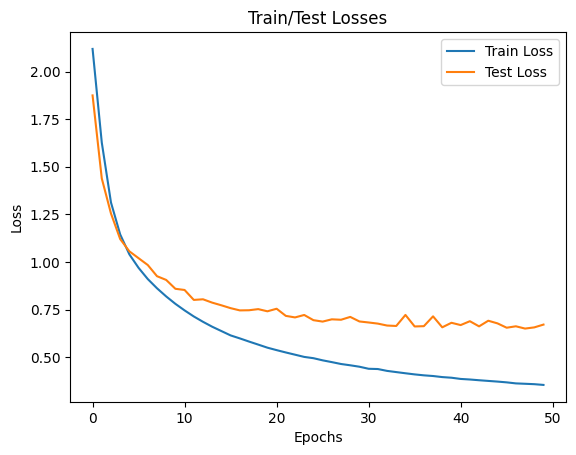

train_losses=[2.118788163450029, 1.6272660065756903, 1.312171693417761, 1.1444091917276382, 1.0396810415850746, 0.9687936362557941, 0.9099832396672831, 0.8616388544970088, 0.8187141825805108, 0.779828241907888, 0.7453745686262846, 0.7135299601107836, 0.6854724049452279, 0.6596455604102877, 0.6368398696482181, 0.6140405808339516, 0.598351436075651, 0.5817451555679242, 0.5657922712382343, 0.5496175487803089, 0.536712152282397, 0.524432884277569, 0.5127896064888272, 0.5010960367313689, 0.4943962227470345, 0.4831160513361295, 0.47374045876827503, 0.46387318549801904, 0.457091614563432, 0.44957256460107037, 0.4387721700217161, 0.4374289241246879, 0.42769982587670285, 0.42137918522933293, 0.4151894268025127, 0.40927598830395273, 0.40433850321918724, 0.40073963364337883, 0.3951516590706176, 0.3917898810988085, 0.38541687031214433, 0.38247844779243073, 0.37855448956580623, 0.37503797297428054, 0.3715059186514053, 0.36742904643103896, 0.36199686467544073, 0.35998252812110715, 0.3578740523904562

100%|██████████| 250/250 [00:00<00:00, 925.86it/s]


Epoch [1/50], Train Loss: 1.8603, Train Accuracy: 39.87%, Test Loss: 1.4833, Test Accuracy: 56.65%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1343.06it/s]


Epoch [2/50], Train Loss: 1.3150, Train Accuracy: 62.12%, Test Loss: 1.2160, Test Accuracy: 64.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1449.58it/s]


Epoch [3/50], Train Loss: 1.1155, Train Accuracy: 67.88%, Test Loss: 1.0733, Test Accuracy: 67.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1374.02it/s]


Epoch [4/50], Train Loss: 1.0056, Train Accuracy: 70.61%, Test Loss: 1.0137, Test Accuracy: 69.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1401.20it/s]


Epoch [5/50], Train Loss: 0.9287, Train Accuracy: 72.43%, Test Loss: 0.9690, Test Accuracy: 69.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 956.10it/s]


Epoch [6/50], Train Loss: 0.8679, Train Accuracy: 74.33%, Test Loss: 0.9085, Test Accuracy: 72.00%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1361.85it/s]


Epoch [7/50], Train Loss: 0.8182, Train Accuracy: 75.34%, Test Loss: 0.8872, Test Accuracy: 72.55%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1373.70it/s]


Epoch [8/50], Train Loss: 0.7721, Train Accuracy: 76.86%, Test Loss: 0.8689, Test Accuracy: 73.00%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 980.56it/s]


Epoch [9/50], Train Loss: 0.7330, Train Accuracy: 78.33%, Test Loss: 0.8332, Test Accuracy: 74.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1432.23it/s]


Epoch [10/50], Train Loss: 0.7010, Train Accuracy: 79.08%, Test Loss: 0.7840, Test Accuracy: 76.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1392.93it/s]


Epoch [11/50], Train Loss: 0.6663, Train Accuracy: 80.41%, Test Loss: 0.7904, Test Accuracy: 75.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1258.79it/s]


Epoch [12/50], Train Loss: 0.6380, Train Accuracy: 81.07%, Test Loss: 0.7878, Test Accuracy: 75.60%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1439.17it/s]


Epoch [13/50], Train Loss: 0.6121, Train Accuracy: 82.11%, Test Loss: 0.7641, Test Accuracy: 76.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1311.08it/s]


Epoch [14/50], Train Loss: 0.5882, Train Accuracy: 82.83%, Test Loss: 0.7384, Test Accuracy: 78.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1382.41it/s]


Epoch [15/50], Train Loss: 0.5656, Train Accuracy: 83.24%, Test Loss: 0.7549, Test Accuracy: 76.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1375.00it/s]


Epoch [16/50], Train Loss: 0.5450, Train Accuracy: 84.03%, Test Loss: 0.7506, Test Accuracy: 76.65%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1107.21it/s]


Epoch [17/50], Train Loss: 0.5263, Train Accuracy: 84.68%, Test Loss: 0.7568, Test Accuracy: 77.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1387.98it/s]


Epoch [18/50], Train Loss: 0.5094, Train Accuracy: 85.29%, Test Loss: 0.7037, Test Accuracy: 79.35%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1372.26it/s]


Epoch [19/50], Train Loss: 0.4925, Train Accuracy: 85.76%, Test Loss: 0.7083, Test Accuracy: 78.90%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 982.93it/s]


Epoch [20/50], Train Loss: 0.4751, Train Accuracy: 86.50%, Test Loss: 0.7179, Test Accuracy: 78.25%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1319.77it/s]


Epoch [21/50], Train Loss: 0.4625, Train Accuracy: 86.62%, Test Loss: 0.7287, Test Accuracy: 78.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1377.72it/s]


Epoch [22/50], Train Loss: 0.4459, Train Accuracy: 87.04%, Test Loss: 0.6984, Test Accuracy: 79.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1407.33it/s]


Epoch [23/50], Train Loss: 0.4358, Train Accuracy: 87.53%, Test Loss: 0.6916, Test Accuracy: 80.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1348.16it/s]


Epoch [24/50], Train Loss: 0.4218, Train Accuracy: 88.11%, Test Loss: 0.6930, Test Accuracy: 80.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1154.26it/s]


Epoch [25/50], Train Loss: 0.4095, Train Accuracy: 88.28%, Test Loss: 0.6773, Test Accuracy: 80.30%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1384.44it/s]


Epoch [26/50], Train Loss: 0.4001, Train Accuracy: 88.52%, Test Loss: 0.7005, Test Accuracy: 79.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1384.19it/s]


Epoch [27/50], Train Loss: 0.3884, Train Accuracy: 88.89%, Test Loss: 0.6904, Test Accuracy: 80.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1058.35it/s]


Epoch [28/50], Train Loss: 0.3774, Train Accuracy: 89.35%, Test Loss: 0.6925, Test Accuracy: 80.30%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1399.53it/s]


Epoch [29/50], Train Loss: 0.3679, Train Accuracy: 89.88%, Test Loss: 0.6885, Test Accuracy: 81.35%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1388.61it/s]


Epoch [30/50], Train Loss: 0.3601, Train Accuracy: 89.96%, Test Loss: 0.6831, Test Accuracy: 81.00%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1386.90it/s]


Epoch [31/50], Train Loss: 0.3488, Train Accuracy: 90.34%, Test Loss: 0.6701, Test Accuracy: 81.20%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1364.82it/s]


Epoch [32/50], Train Loss: 0.3443, Train Accuracy: 90.13%, Test Loss: 0.6936, Test Accuracy: 80.95%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1005.73it/s]


Epoch [33/50], Train Loss: 0.3343, Train Accuracy: 90.73%, Test Loss: 0.7151, Test Accuracy: 80.25%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1398.09it/s]


Epoch [34/50], Train Loss: 0.3253, Train Accuracy: 90.97%, Test Loss: 0.6838, Test Accuracy: 80.85%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1320.19it/s]


Epoch [35/50], Train Loss: 0.3185, Train Accuracy: 91.14%, Test Loss: 0.7068, Test Accuracy: 80.60%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 959.90it/s]


Epoch [36/50], Train Loss: 0.3094, Train Accuracy: 91.53%, Test Loss: 0.7038, Test Accuracy: 80.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1406.47it/s]


Epoch [37/50], Train Loss: 0.3051, Train Accuracy: 91.30%, Test Loss: 0.6904, Test Accuracy: 81.60%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1439.52it/s]


Epoch [38/50], Train Loss: 0.2996, Train Accuracy: 91.59%, Test Loss: 0.6796, Test Accuracy: 81.00%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1412.35it/s]


Epoch [39/50], Train Loss: 0.2922, Train Accuracy: 91.74%, Test Loss: 0.6992, Test Accuracy: 80.95%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1426.82it/s]


Epoch [40/50], Train Loss: 0.2862, Train Accuracy: 92.14%, Test Loss: 0.7158, Test Accuracy: 80.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1068.87it/s]


Epoch [41/50], Train Loss: 0.2792, Train Accuracy: 92.37%, Test Loss: 0.6892, Test Accuracy: 81.90%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1421.09it/s]


Epoch [42/50], Train Loss: 0.2754, Train Accuracy: 92.34%, Test Loss: 0.7075, Test Accuracy: 81.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1374.41it/s]


Epoch [43/50], Train Loss: 0.2696, Train Accuracy: 92.63%, Test Loss: 0.6971, Test Accuracy: 81.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1044.19it/s]


Epoch [44/50], Train Loss: 0.2639, Train Accuracy: 92.67%, Test Loss: 0.7123, Test Accuracy: 80.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1449.96it/s]


Epoch [45/50], Train Loss: 0.2564, Train Accuracy: 93.04%, Test Loss: 0.7401, Test Accuracy: 80.60%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1325.47it/s]


Epoch [46/50], Train Loss: 0.2522, Train Accuracy: 93.07%, Test Loss: 0.7083, Test Accuracy: 80.75%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1264.81it/s]


Epoch [47/50], Train Loss: 0.2458, Train Accuracy: 93.42%, Test Loss: 0.7077, Test Accuracy: 81.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1306.18it/s]


Epoch [48/50], Train Loss: 0.2434, Train Accuracy: 93.37%, Test Loss: 0.7168, Test Accuracy: 81.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1179.72it/s]


Epoch [49/50], Train Loss: 0.2370, Train Accuracy: 93.71%, Test Loss: 0.7222, Test Accuracy: 81.60%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1399.38it/s]


Epoch [50/50], Train Loss: 0.2340, Train Accuracy: 93.65%, Test Loss: 0.7054, Test Accuracy: 82.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1491.75it/s]


Test Accuracy with learning rate 0.0001: 79.70%


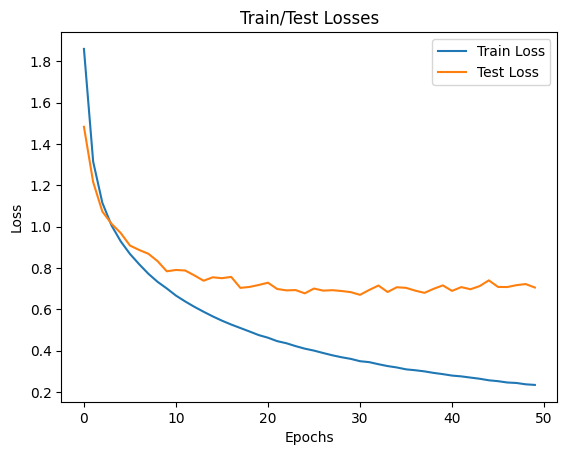

train_losses=[1.860250024371677, 1.314956610944536, 1.1155451912151442, 1.0055790476600328, 0.9286938728657034, 0.8679412425425318, 0.8182495067881214, 0.7721051307121912, 0.7330020217299461, 0.7009660405897432, 0.6662822302877903, 0.6380474046741923, 0.6120552594454752, 0.5882197491708729, 0.5656408252956139, 0.5449595705701246, 0.526304321705881, 0.5093963823459214, 0.49249040705689956, 0.4751080428303944, 0.4624727560960584, 0.44587899024536215, 0.4357943055259271, 0.42181048588020104, 0.4095347796074218, 0.40011136913110706, 0.3884399459477928, 0.37736095434986056, 0.3678888221398617, 0.3600640799091715, 0.3488004099699772, 0.3443029446412499, 0.334270370302101, 0.3252664761908559, 0.31852616760724534, 0.3094475910555468, 0.3050721282434857, 0.2996359860363106, 0.29221057458351263, 0.2862488450113063, 0.2792373393572246, 0.2754152001619546, 0.2695556613861376, 0.2639356716285563, 0.256430340221695, 0.2521593765070041, 0.24576606699053405, 0.24344783424399793, 0.23700498310828375, 0

100%|██████████| 250/250 [00:00<00:00, 1356.49it/s]


Epoch [1/50], Train Loss: 1.8506, Train Accuracy: 40.13%, Test Loss: 1.5005, Test Accuracy: 55.90%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1084.13it/s]


Epoch [2/50], Train Loss: 1.3444, Train Accuracy: 61.15%, Test Loss: 1.2295, Test Accuracy: 64.95%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1371.52it/s]


Epoch [3/50], Train Loss: 1.1517, Train Accuracy: 66.93%, Test Loss: 1.1381, Test Accuracy: 65.55%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1320.52it/s]


Epoch [4/50], Train Loss: 1.0465, Train Accuracy: 69.81%, Test Loss: 1.0514, Test Accuracy: 68.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1403.82it/s]


Epoch [5/50], Train Loss: 0.9772, Train Accuracy: 71.26%, Test Loss: 0.9843, Test Accuracy: 70.75%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1386.70it/s]


Epoch [6/50], Train Loss: 0.9230, Train Accuracy: 72.99%, Test Loss: 0.9581, Test Accuracy: 71.00%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1396.58it/s]


Epoch [7/50], Train Loss: 0.8774, Train Accuracy: 74.28%, Test Loss: 0.9096, Test Accuracy: 73.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1375.82it/s]


Epoch [8/50], Train Loss: 0.8375, Train Accuracy: 75.64%, Test Loss: 0.8935, Test Accuracy: 72.65%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1365.07it/s]


Epoch [9/50], Train Loss: 0.8027, Train Accuracy: 76.49%, Test Loss: 0.9010, Test Accuracy: 71.55%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1019.25it/s]


Epoch [10/50], Train Loss: 0.7716, Train Accuracy: 77.57%, Test Loss: 0.8482, Test Accuracy: 73.60%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1355.65it/s]


Epoch [11/50], Train Loss: 0.7447, Train Accuracy: 78.32%, Test Loss: 0.8356, Test Accuracy: 74.20%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1379.12it/s]


Epoch [12/50], Train Loss: 0.7188, Train Accuracy: 79.22%, Test Loss: 0.8043, Test Accuracy: 75.75%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1033.23it/s]


Epoch [13/50], Train Loss: 0.6952, Train Accuracy: 79.73%, Test Loss: 0.8097, Test Accuracy: 75.25%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1326.27it/s]


Epoch [14/50], Train Loss: 0.6741, Train Accuracy: 80.55%, Test Loss: 0.8019, Test Accuracy: 75.75%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1384.19it/s]


Epoch [15/50], Train Loss: 0.6571, Train Accuracy: 81.09%, Test Loss: 0.7756, Test Accuracy: 76.60%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1318.02it/s]


Epoch [16/50], Train Loss: 0.6383, Train Accuracy: 81.69%, Test Loss: 0.7724, Test Accuracy: 76.75%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1358.67it/s]


Epoch [17/50], Train Loss: 0.6231, Train Accuracy: 82.23%, Test Loss: 0.7522, Test Accuracy: 77.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1154.81it/s]


Epoch [18/50], Train Loss: 0.6098, Train Accuracy: 82.71%, Test Loss: 0.7414, Test Accuracy: 77.25%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1404.65it/s]


Epoch [19/50], Train Loss: 0.5944, Train Accuracy: 83.06%, Test Loss: 0.7561, Test Accuracy: 77.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1399.05it/s]


Epoch [20/50], Train Loss: 0.5826, Train Accuracy: 83.60%, Test Loss: 0.7516, Test Accuracy: 76.55%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1060.74it/s]


Epoch [21/50], Train Loss: 0.5694, Train Accuracy: 84.01%, Test Loss: 0.7418, Test Accuracy: 77.80%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1383.90it/s]


Epoch [22/50], Train Loss: 0.5599, Train Accuracy: 84.17%, Test Loss: 0.7185, Test Accuracy: 77.90%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1356.30it/s]


Epoch [23/50], Train Loss: 0.5492, Train Accuracy: 84.59%, Test Loss: 0.7113, Test Accuracy: 79.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1360.88it/s]


Epoch [24/50], Train Loss: 0.5396, Train Accuracy: 84.94%, Test Loss: 0.7336, Test Accuracy: 78.00%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1348.35it/s]


Epoch [25/50], Train Loss: 0.5315, Train Accuracy: 84.78%, Test Loss: 0.7139, Test Accuracy: 78.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1098.02it/s]


Epoch [26/50], Train Loss: 0.5217, Train Accuracy: 85.32%, Test Loss: 0.7090, Test Accuracy: 78.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1371.21it/s]


Epoch [27/50], Train Loss: 0.5149, Train Accuracy: 85.50%, Test Loss: 0.7160, Test Accuracy: 79.25%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1269.77it/s]


Epoch [28/50], Train Loss: 0.5064, Train Accuracy: 85.78%, Test Loss: 0.7373, Test Accuracy: 77.75%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 994.23it/s]


Epoch [29/50], Train Loss: 0.5012, Train Accuracy: 86.14%, Test Loss: 0.7075, Test Accuracy: 78.20%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1398.04it/s]


Epoch [30/50], Train Loss: 0.4919, Train Accuracy: 86.24%, Test Loss: 0.6980, Test Accuracy: 79.25%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1394.33it/s]


Epoch [31/50], Train Loss: 0.4868, Train Accuracy: 86.47%, Test Loss: 0.7017, Test Accuracy: 79.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1364.35it/s]


Epoch [32/50], Train Loss: 0.4801, Train Accuracy: 86.74%, Test Loss: 0.6766, Test Accuracy: 80.00%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1390.21it/s]


Epoch [33/50], Train Loss: 0.4749, Train Accuracy: 86.78%, Test Loss: 0.7505, Test Accuracy: 77.30%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 990.43it/s] 


Epoch [34/50], Train Loss: 0.4691, Train Accuracy: 87.12%, Test Loss: 0.6973, Test Accuracy: 78.80%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1333.46it/s]


Epoch [35/50], Train Loss: 0.4642, Train Accuracy: 87.17%, Test Loss: 0.6805, Test Accuracy: 80.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1378.04it/s]


Epoch [36/50], Train Loss: 0.4595, Train Accuracy: 87.32%, Test Loss: 0.6988, Test Accuracy: 78.80%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1073.42it/s]


Epoch [37/50], Train Loss: 0.4569, Train Accuracy: 87.23%, Test Loss: 0.6664, Test Accuracy: 80.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1394.57it/s]


Epoch [38/50], Train Loss: 0.4505, Train Accuracy: 87.53%, Test Loss: 0.6608, Test Accuracy: 80.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1394.58it/s]


Epoch [39/50], Train Loss: 0.4487, Train Accuracy: 87.56%, Test Loss: 0.6767, Test Accuracy: 80.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1391.43it/s]


Epoch [40/50], Train Loss: 0.4435, Train Accuracy: 87.98%, Test Loss: 0.6907, Test Accuracy: 78.80%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1399.69it/s]


Epoch [41/50], Train Loss: 0.4398, Train Accuracy: 87.73%, Test Loss: 0.6734, Test Accuracy: 80.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1423.71it/s]


Epoch [42/50], Train Loss: 0.4345, Train Accuracy: 88.04%, Test Loss: 0.6783, Test Accuracy: 80.65%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1349.67it/s]


Epoch [43/50], Train Loss: 0.4318, Train Accuracy: 87.96%, Test Loss: 0.6723, Test Accuracy: 79.60%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1311.50it/s]


Epoch [44/50], Train Loss: 0.4262, Train Accuracy: 88.31%, Test Loss: 0.7553, Test Accuracy: 77.25%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1033.13it/s]


Epoch [45/50], Train Loss: 0.4238, Train Accuracy: 88.29%, Test Loss: 0.6826, Test Accuracy: 79.65%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1273.90it/s]


Epoch [46/50], Train Loss: 0.4201, Train Accuracy: 88.55%, Test Loss: 0.6696, Test Accuracy: 80.55%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1333.89it/s]


Epoch [47/50], Train Loss: 0.4184, Train Accuracy: 88.30%, Test Loss: 0.6535, Test Accuracy: 80.90%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1369.17it/s]


Epoch [48/50], Train Loss: 0.4144, Train Accuracy: 88.65%, Test Loss: 0.6774, Test Accuracy: 80.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1382.53it/s]


Epoch [49/50], Train Loss: 0.4113, Train Accuracy: 88.64%, Test Loss: 0.6817, Test Accuracy: 79.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1373.71it/s]


Epoch [50/50], Train Loss: 0.4094, Train Accuracy: 88.83%, Test Loss: 0.6663, Test Accuracy: 80.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1532.50it/s]


Test Accuracy with learning rate 0.0001: 78.55%


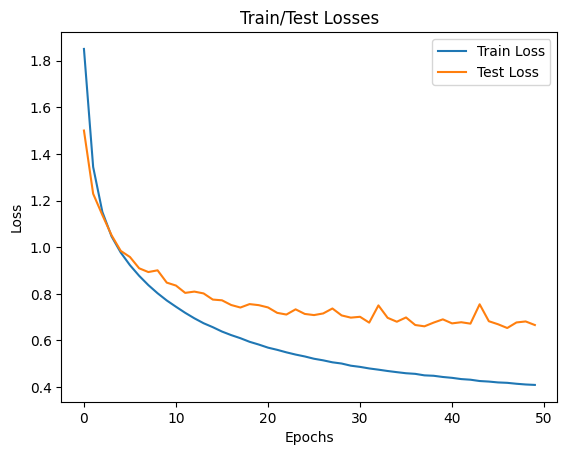

train_losses=[1.8506102966202629, 1.3443797169791327, 1.1517379102839365, 1.0465207440257072, 0.9771547113292747, 0.9230269017020861, 0.8774142571489016, 0.8375200056069427, 0.8026833093696171, 0.7716465240923894, 0.7447282744116254, 0.7187564847005738, 0.6951804067591826, 0.674081320034133, 0.657142218372888, 0.6383495824072096, 0.6231302338867551, 0.6098382786835234, 0.5943960232867135, 0.5825666792910132, 0.5693536689782308, 0.5599299346688721, 0.5491706741634342, 0.5396343733742833, 0.5315165251427226, 0.5217012051733003, 0.5148666682646921, 0.5064312412552535, 0.5011939479990138, 0.4919189846354226, 0.48682694186187453, 0.4800910263715519, 0.4748864799804158, 0.46914845594598187, 0.4641750087324116, 0.45952972133002346, 0.4569103144332767, 0.4504688906520605, 0.44869512524207433, 0.4434794719124006, 0.43981531451104416, 0.4344695583391521, 0.4318046155360838, 0.42615580564571753, 0.4238140673384898, 0.42010509585092465, 0.4184111201767292, 0.4144061909822954, 0.4113200565216442, 0

100%|██████████| 250/250 [00:00<00:00, 1400.65it/s]


Epoch [1/50], Train Loss: 1.5429, Train Accuracy: 50.26%, Test Loss: 1.3443, Test Accuracy: 59.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1354.37it/s]


Epoch [2/50], Train Loss: 1.1254, Train Accuracy: 65.01%, Test Loss: 1.0278, Test Accuracy: 68.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 908.58it/s]


Epoch [3/50], Train Loss: 0.9887, Train Accuracy: 69.43%, Test Loss: 0.9605, Test Accuracy: 70.95%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1379.61it/s]


Epoch [4/50], Train Loss: 0.9112, Train Accuracy: 72.03%, Test Loss: 0.9900, Test Accuracy: 69.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1357.46it/s]


Epoch [5/50], Train Loss: 0.8455, Train Accuracy: 74.18%, Test Loss: 0.8648, Test Accuracy: 75.40%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1368.34it/s]


Epoch [6/50], Train Loss: 0.8068, Train Accuracy: 75.66%, Test Loss: 0.9723, Test Accuracy: 71.85%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1399.58it/s]


Epoch [7/50], Train Loss: 0.7736, Train Accuracy: 76.60%, Test Loss: 0.9002, Test Accuracy: 74.20%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1288.94it/s]


Epoch [8/50], Train Loss: 0.7438, Train Accuracy: 77.53%, Test Loss: 0.8921, Test Accuracy: 74.70%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1317.93it/s]


Epoch [9/50], Train Loss: 0.7272, Train Accuracy: 77.74%, Test Loss: 0.8895, Test Accuracy: 74.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1315.94it/s]


Epoch [10/50], Train Loss: 0.7095, Train Accuracy: 78.59%, Test Loss: 0.8821, Test Accuracy: 74.85%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1025.85it/s]


Epoch [11/50], Train Loss: 0.6948, Train Accuracy: 79.03%, Test Loss: 0.9185, Test Accuracy: 73.60%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1305.67it/s]


Epoch [12/50], Train Loss: 0.6887, Train Accuracy: 79.68%, Test Loss: 1.0165, Test Accuracy: 73.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1329.46it/s]


Epoch [13/50], Train Loss: 0.6658, Train Accuracy: 79.98%, Test Loss: 0.9260, Test Accuracy: 74.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1374.17it/s]


Epoch [14/50], Train Loss: 0.6545, Train Accuracy: 80.16%, Test Loss: 0.9093, Test Accuracy: 75.35%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1265.03it/s]


Epoch [15/50], Train Loss: 0.6423, Train Accuracy: 80.73%, Test Loss: 0.9220, Test Accuracy: 75.00%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1038.89it/s]


Epoch [16/50], Train Loss: 0.6333, Train Accuracy: 80.92%, Test Loss: 0.9343, Test Accuracy: 74.60%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1315.35it/s]


Epoch [17/50], Train Loss: 0.6268, Train Accuracy: 80.88%, Test Loss: 0.9786, Test Accuracy: 74.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1407.18it/s]


Epoch [18/50], Train Loss: 0.6131, Train Accuracy: 81.52%, Test Loss: 0.8970, Test Accuracy: 76.00%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1015.61it/s]


Epoch [19/50], Train Loss: 0.6120, Train Accuracy: 81.70%, Test Loss: 1.2974, Test Accuracy: 70.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1352.48it/s]


Epoch [20/50], Train Loss: 0.6165, Train Accuracy: 81.73%, Test Loss: 0.9324, Test Accuracy: 75.90%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1370.96it/s]


Epoch [21/50], Train Loss: 0.6057, Train Accuracy: 81.83%, Test Loss: 0.8904, Test Accuracy: 76.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1385.72it/s]


Epoch [22/50], Train Loss: 0.5916, Train Accuracy: 82.02%, Test Loss: 0.8816, Test Accuracy: 76.95%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1387.40it/s]


Epoch [23/50], Train Loss: 0.5920, Train Accuracy: 82.38%, Test Loss: 1.0363, Test Accuracy: 73.85%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1056.23it/s]


Epoch [24/50], Train Loss: 0.5899, Train Accuracy: 82.42%, Test Loss: 0.9468, Test Accuracy: 75.35%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1320.29it/s]


Epoch [25/50], Train Loss: 0.5846, Train Accuracy: 82.38%, Test Loss: 0.9644, Test Accuracy: 75.75%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1353.83it/s]


Epoch [26/50], Train Loss: 0.5784, Train Accuracy: 82.64%, Test Loss: 0.9288, Test Accuracy: 75.75%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 917.51it/s]


Epoch [27/50], Train Loss: 0.5788, Train Accuracy: 82.64%, Test Loss: 0.8892, Test Accuracy: 76.10%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1356.05it/s]


Epoch [28/50], Train Loss: 0.5702, Train Accuracy: 82.79%, Test Loss: 0.8383, Test Accuracy: 77.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1378.70it/s]


Epoch [29/50], Train Loss: 0.5746, Train Accuracy: 82.76%, Test Loss: 1.1727, Test Accuracy: 72.75%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1391.86it/s]


Epoch [30/50], Train Loss: 0.5652, Train Accuracy: 83.12%, Test Loss: 0.8635, Test Accuracy: 77.35%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1282.76it/s]


Epoch [31/50], Train Loss: 0.5668, Train Accuracy: 83.01%, Test Loss: 0.9675, Test Accuracy: 76.35%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1092.62it/s]


Epoch [32/50], Train Loss: 0.5652, Train Accuracy: 82.90%, Test Loss: 0.8976, Test Accuracy: 76.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1282.77it/s]


Epoch [33/50], Train Loss: 0.5590, Train Accuracy: 83.28%, Test Loss: 0.9444, Test Accuracy: 75.95%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1333.48it/s]


Epoch [34/50], Train Loss: 0.5536, Train Accuracy: 83.61%, Test Loss: 0.9393, Test Accuracy: 76.15%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1014.52it/s]


Epoch [35/50], Train Loss: 0.5589, Train Accuracy: 83.66%, Test Loss: 0.9234, Test Accuracy: 75.65%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1312.71it/s]


Epoch [36/50], Train Loss: 0.5523, Train Accuracy: 83.66%, Test Loss: 1.0115, Test Accuracy: 74.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1338.35it/s]


Epoch [37/50], Train Loss: 0.5481, Train Accuracy: 83.44%, Test Loss: 0.9675, Test Accuracy: 75.20%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1356.31it/s]


Epoch [38/50], Train Loss: 0.5496, Train Accuracy: 83.63%, Test Loss: 1.0360, Test Accuracy: 74.90%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1402.90it/s]


Epoch [39/50], Train Loss: 0.5482, Train Accuracy: 83.83%, Test Loss: 1.1585, Test Accuracy: 73.80%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1366.71it/s]


Epoch [40/50], Train Loss: 0.5460, Train Accuracy: 83.84%, Test Loss: 0.9423, Test Accuracy: 75.60%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1339.82it/s]


Epoch [41/50], Train Loss: 0.5395, Train Accuracy: 83.98%, Test Loss: 0.9527, Test Accuracy: 76.60%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1406.10it/s]


Epoch [42/50], Train Loss: 0.5494, Train Accuracy: 83.69%, Test Loss: 0.9033, Test Accuracy: 76.55%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 979.11it/s] 


Epoch [43/50], Train Loss: 0.5368, Train Accuracy: 84.02%, Test Loss: 0.9143, Test Accuracy: 77.50%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1364.24it/s]


Epoch [44/50], Train Loss: 0.5406, Train Accuracy: 83.90%, Test Loss: 1.0011, Test Accuracy: 74.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1314.11it/s]


Epoch [45/50], Train Loss: 0.5385, Train Accuracy: 84.12%, Test Loss: 0.9076, Test Accuracy: 77.65%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 964.99it/s]


Epoch [46/50], Train Loss: 0.5297, Train Accuracy: 84.18%, Test Loss: 0.9722, Test Accuracy: 76.30%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1363.43it/s]


Epoch [47/50], Train Loss: 0.5419, Train Accuracy: 83.87%, Test Loss: 0.8811, Test Accuracy: 77.45%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1260.05it/s]


Epoch [48/50], Train Loss: 0.5309, Train Accuracy: 84.08%, Test Loss: 0.9199, Test Accuracy: 77.05%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1353.74it/s]


Epoch [49/50], Train Loss: 0.5384, Train Accuracy: 83.97%, Test Loss: 0.9932, Test Accuracy: 76.25%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1292.36it/s]


Epoch [50/50], Train Loss: 0.5322, Train Accuracy: 84.15%, Test Loss: 0.9825, Test Accuracy: 75.85%
Checking gradient for parameter: fc1.weights
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weights
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 250/250 [00:00<00:00, 1503.10it/s]


Test Accuracy with learning rate 0.001: 72.60%


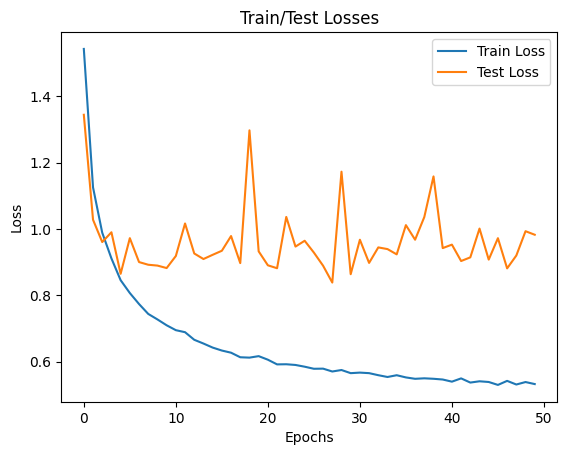

train_losses=[1.5429016842577192, 1.12540784883168, 0.9887477651321226, 0.9111789449407822, 0.8454726148247719, 0.8067683012224733, 0.773600759509123, 0.7437695555173689, 0.7271721789886554, 0.7095068142345796, 0.6947518362253904, 0.6886655448356437, 0.6657881155037838, 0.654464394763112, 0.6422806131545868, 0.633331005971051, 0.6268269178286816, 0.6130858453623951, 0.6119705525506288, 0.616462791983866, 0.605727899147715, 0.5915972128868, 0.5919884984542926, 0.5898591419192445, 0.5846230497595647, 0.5783725283021728, 0.5787529474333343, 0.5701551199124919, 0.57461520884869, 0.5651541295352702, 0.5667930527935839, 0.5651859255517936, 0.5590049084180242, 0.5535880265733641, 0.5589156128520973, 0.5522825339549324, 0.5481181080635741, 0.5495833063932498, 0.5481860090815462, 0.5459809720194381, 0.5395145596522424, 0.5493682979222051, 0.5367793917409532, 0.540622138230337, 0.5385166355839723, 0.5296684425225119, 0.5418741844519973, 0.5308968324015021, 0.538354780739432, 0.5322403253024031]


In [68]:
result_batch_norm_50 = pd.DataFrame(columns=['optimizer', 'learning_rate', 'weight_decay', 'test_accuracy'])
num_epochs = 50
params = [(optim.SGD, 0.01, 0.001), (optim.RMSprop, 0.0001, 0.0001), (optim.RMSprop, 0.0001, 0.0010), (optim.RMSprop, 0.0010, 0.0001)]

result_batch_norm_50 = run(params, num_epochs, result_batch_norm_50)

In [69]:
result_batch_norm_50_sorted = result_batch_norm_50.sort_values(by=['test_accuracy'], ascending=False)
result_batch_norm_50_sorted

,optimizer,learning_rate,weight_decay,test_accuracy
0,RMSprop,0.0001,0.0001,0.8210
0,SGD,0.0100,0.0010,0.8155
0,RMSprop,0.0001,0.0010,0.8090
0,RMSprop,0.0010,0.0001,0.7765


Лучшим выбором в качестве оптимизатора остался RMSprop, однако нормализация батчей не улучшила результаты.

# **Выводы**

* Простая нейронная сеть с одним нелинейным слоем довольно неплохо распознает цифры (82% точности)
* Среди двух выбранных оптимизаторов (RMSprop и SGD) лучше показал себя RMSprop с параметрами learning rate = 0.0001 и weight decay = 0.0001
* Нормализация батчей не улучшила результаты